# Armado base

In [ ]:
DONORS_FX = [
    # FX emergentes
    "USDTBRL","USDTMXN","USDTCOP","USDTTRY","USDTZAR",
    "USDTRUB","USDTUAH","USDTNGN",

    # FX desarrollados
    "EURUSDT","GBPUSDT","AUDUSDT","CADUSDT","JPYUSDT",
    "CHFUSDT","NZDUSDT",

    # stablecoins
    "USDCUSDT","DAIUSDT","BUSDUSDT","TUSDUSDT","FDUSDUSDT",

    # cripto proxies
    "BTCUSDT","ETHUSDT","AVAXUSDT","MATICUSDT","ADAUSDT",
    "XRPUSDT","LTCUSDT","TRXUSDT"
]
import requests

base = "https://api.binance.com/api/v3/klines"

for s in DONORS_FX:
    params = {"symbol": s, "interval": "5m", "limit": 5}
    r = requests.get(base, params=params)
    print(s, "OK" if r.status_code == 200 else "NOPE")


USDTBRL OK
USDTMXN OK
USDTCOP OK
USDTTRY OK
USDTZAR OK
USDTRUB OK
USDTUAH OK
USDTNGN OK
EURUSDT OK
GBPUSDT OK
AUDUSDT OK
CADUSDT NOPE
JPYUSDT NOPE
CHFUSDT NOPE
NZDUSDT NOPE
USDCUSDT OK
DAIUSDT OK
BUSDUSDT OK
TUSDUSDT OK
FDUSDUSDT OK
BTCUSDT OK
ETHUSDT OK
AVAXUSDT OK
MATICUSDT OK
ADAUSDT OK
XRPUSDT OK
LTCUSDT OK
TRXUSDT OK


In [ ]:

# PANEL MULTIPAR (5m) centrado en t=0


import time
import requests
import pandas as pd
import numpy as np
from datetime import timedelta


SYMBOLS_TREATED = ["USDTARS"]

SYMBOLS_CTRL_PRIMARY = [
    # FX emergentes reales
    "USDTBRL","USDTMXN","USDTCOP","USDTTRY","USDTZAR",
    "USDTRUB","USDTUAH","USDTNGN",

    # FX desarrollados reales
    "EURUSDT","GBPUSDT","AUDUSDT",
]

SYMBOLS_CTRL_STABLE = [
    "USDCUSDT","DAIUSDT","BUSDUSDT","TUSDUSDT","FDUSDUSDT"
]

SYMBOLS_CTRL_CRYPTO = [
    "BTCUSDT","ETHUSDT","AVAXUSDT","MATICUSDT",
    "ADAUSDT","XRPUSDT","LTCUSDT","TRXUSDT"
]


SYMBOLS = SYMBOLS_TREATED + SYMBOLS_CTRL_PRIMARY +SYMBOLS_CTRL_STABLE +SYMBOLS_CTRL_CRYPTO


INTERVAL  = "5m"
LIMIT     = 1000
TZ_LOCAL  = "America/Argentina/Buenos_Aires"
OUTFILE   = "PANEL_MULTIPAR_USDT_5m.xlsx"

PRE_MIN   = 360   # 6h antes
POST_MIN  = 360   # 6h después


# Eventos

EVENTS = [

    ("Caputo_A2Voces",          "2023-12-14", "22:00", "23:00"),
    ("Caputo_Majul1",            "2023-12-17", "20:30", "21:45"),
    ("Caputo_Conf_BCRA",        "2024-01-10", "21:00", "22:00"),
    ("Caputo_Conf_26ene",       "2024-01-26", "20:15", "21:00"),
    ("Caputo_Laje1",             "2025-03-18", "09:00", "09:30"),     
    ("Caputo_Majul2",            "2024-03-24", "20:45", "21:30"),
    ("Caputo_Majul3",            "2024-03-30", "20:45", "22:00"),
    ("Caputo_BCRA_28jun",       "2024-06-28", "18:05", "18:40"),
    ("Caputo_Feinmann1",         "2024-07-11", "07:50", "08:30"),
    ("Caputo_Laje2",             "2024-07-19", "08:30", "09:00"),
    ("Caputo_Cereales",         "2024-08-14", "18:00", "19:00"),     
    ("Caputo_Majul4",            "2024-10-06", "21:00", "21:45"),
    ("Caputo_RadioMitre",       "2024-11-12", "07:15", "07:45"),
    ("Caputo_Feinmann2",         "2025-02-17", "19:15", "20:00"),
]


# Helpers tiempo

def to_epoch_ms_local(date_str, time_str):
    ts_local = pd.Timestamp(f"{date_str} {time_str}:00", tz=TZ_LOCAL)
    return int(ts_local.tz_convert("UTC").timestamp() * 1000)

def add_minutes_epoch_ms(epoch_ms, minutes):
    return epoch_ms + int(minutes * 60_000)

def epoch_ms_to_local_naive(epoch_ms):
    dt = pd.to_datetime(epoch_ms, unit="ms", utc=True).tz_convert(TZ_LOCAL)
    return dt.tz_localize(None)

# API Binance

def fetch_klines(symbol, interval, start_ms, end_ms, limit=LIMIT, sleep_s=0.2, max_iters=100000):
    url = "https://api.binance.com/api/v3/klines"
    all_rows, curr_start, iters = [], start_ms, 0
    while curr_start <= end_ms:
        iters += 1
        if iters > max_iters:
            break
        params = {"symbol": symbol, "interval": interval, "limit": limit,
                  "startTime": curr_start, "endTime": end_ms}
        r = requests.get(url, params=params, timeout=30)
        if r.status_code != 200:
            time.sleep(1.0)
            continue
        rows = r.json()
        if not rows:
            break
        all_rows.extend(rows)
        last_close_ms = rows[-1][6]
        if last_close_ms == curr_start:
            break
        curr_start = last_close_ms + 1
        time.sleep(sleep_s)
    return all_rows

BASE_COLS = ["open_time_ms","open","high","low","close","volume","close_time_ms",
             "quote_asset_volume","number_of_trades","taker_buy_base_volume",
             "taker_buy_quote_volume","ignore"]

def rows_to_df(rows):
    df = pd.DataFrame(rows, columns=BASE_COLS)
    num_cols = ["open","high","low","close","volume","quote_asset_volume",
                "taker_buy_base_volume","taker_buy_quote_volume"]
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df["number_of_trades"] = pd.to_numeric(df["number_of_trades"], errors="coerce").astype("Int64")
    df = df.sort_values("open_time_ms").reset_index(drop=True)
    return df


# Métricas

def add_bar_metrics(df):
    df = df.sort_values("open_time_ms").reset_index(drop=True)

    # retornos log 15m
    df["ret_5m"] = np.log(df["close"].astype(float)).diff()
    df["abs_ret_5m"] = df["ret_5m"].abs()

    # volatilidades rolling
    df["roll_vol_1h"]   = df["ret_5m"].rolling(window=4, min_periods=4).std()
    df["roll_vol_1.5h"] = df["ret_5m"].rolling(window=6, min_periods=4).std()
    df["roll_vol_2h"]   = df["ret_5m"].rolling(window=8, min_periods=4).std()

    # logs de actividad (para evitar colas pesadas y comparar en %)
    df["log_trades"] = np.log1p(df["number_of_trades"].astype(float))
    df["log_quote_volume"] = np.log1p(df["quote_asset_volume"].astype(float))

    return df


panel_rows, meta_rows = [], []

for symbol in SYMBOLS:
    for name, date_str, hhmm_start, hhmm_end in EVENTS:
        start_evt_ms = to_epoch_ms_local(date_str, hhmm_start)
        end_evt_ms   = to_epoch_ms_local(date_str, hhmm_end) if hhmm_end else None
        fetch_start_ms = add_minutes_epoch_ms(start_evt_ms, -PRE_MIN)
        fetch_end_ms   = add_minutes_epoch_ms(start_evt_ms,  POST_MIN)

        rows = fetch_klines(symbol, INTERVAL, fetch_start_ms, fetch_end_ms)
        if not rows:
            continue

        df = rows_to_df(rows)
        df = add_bar_metrics(df)

        open_local_naive = df["open_time_ms"].apply(epoch_ms_to_local_naive)
        t_from_start_min = ((open_local_naive - epoch_ms_to_local_naive(start_evt_ms))
                            .dt.total_seconds() / 60).round().astype("Int64")

        df["time_local"] = open_local_naive
        df["t_min"] = t_from_start_min
        df["event"] = name
        df["symbol"] = symbol
        df["post"] = (df["t_min"] >= 0).astype(int)

        keep = [
            "event","symbol","time_local","t_min","post",
            "open","high","low","close","volume","quote_asset_volume","number_of_trades",
            "ret_5m","abs_ret_5m",
            "roll_vol_1h","roll_vol_1.5h","roll_vol_2h",
            "log_trades","log_quote_volume"
        ]

        panel_rows.append(df[keep].copy())

        meta_rows.append({
            "event": name, "symbol": symbol,
            "date_local": date_str, "start_local": hhmm_start, "end_local": hhmm_end or "",
            "bars": len(df), "window_pre_min": PRE_MIN, "window_post_min": POST_MIN
        })

panel = pd.concat(panel_rows, ignore_index=True) if panel_rows else pd.DataFrame()
panel = panel.sort_values(["event","symbol","t_min"]).reset_index(drop=True)
df_meta = pd.DataFrame(meta_rows)

# Exportar

with pd.ExcelWriter(OUTFILE, engine="openpyxl", datetime_format="yyyy-mm-dd hh:mm:ss") as xw:
    panel.to_excel(xw, index=False, sheet_name="panel_5m")
    xw.sheets["panel_5m"].freeze_panes = "A2"
    df_meta.to_excel(xw, index=False, sheet_name="metadata")
    xw.sheets["metadata"].freeze_panes = "A2"

print(f"Archivo generado: {OUTFILE}")


Archivo generado: PANEL_MULTIPAR_USDT_5m.xlsx


# B/A

## Dif. de medias (60 min)

In [ ]:

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy.stats import t as t_dist


try:
    panel
except NameError:
    PANEL_PATH = "PANEL_MULTIPAR_USDT_5m.xlsx"
    panel = pd.read_excel(PANEL_PATH, sheet_name="panel_5m", parse_dates=["time_local"])


WIN_MIN = 60
TREATED = "USDTARS"
EPS = 1e-8  # para logs de vol


df = panel[panel["symbol"] == TREATED].copy()
df["t_min"] = pd.to_numeric(df["t_min"], errors="coerce")


df = df.sort_values(["event","time_local"]).reset_index(drop=True)

if "log_trades" not in df.columns:
    df["log_trades"] = np.log1p(df["number_of_trades"].astype(float))

if "log_quote_volume" not in df.columns:
    df["log_quote_volume"] = np.log1p(df["quote_asset_volume"].astype(float))

if "log_roll_vol_1h" not in df.columns:
    df["log_roll_vol_1h"] = np.log(df["roll_vol_1h"].astype(float) + EPS)

if "log_roll_vol_1.5h" not in df.columns:
    df["log_roll_vol_1.5h"] = np.log(df["roll_vol_1.5h"].astype(float) + EPS)

if "log_roll_vol_2h" not in df.columns:
    df["log_roll_vol_2h"] = np.log(df["roll_vol_2h"].astype(float) + EPS)

METRICS = [
    "log_trades",
    "log_quote_volume",
    "log_roll_vol_1h",
    "log_roll_vol_1.5h",
    "log_roll_vol_2h"
]

# --------------------------------------------------

def split_pre_post(g):
    pre  = g[(g["t_min"] >= -WIN_MIN) & (g["t_min"] <= -1)]
    post = g[(g["t_min"] >= 0)        & (g["t_min"] <=  WIN_MIN)]
    return pre, post

def diff_log(g, metric):
    pre, post = split_pre_post(g)
    if pre[metric].empty or post[metric].empty:
        return np.nan
    return post[metric].mean() - pre[metric].mean()

def ttest(diffs):
    diffs = pd.Series(diffs).dropna()
    n = len(diffs)
    if n <= 1:
        return np.nan, np.nan, n
    mean = diffs.mean()
    sd   = diffs.std(ddof=1)
    tval = mean / (sd / np.sqrt(n))
    pval = 2 * (1 - t_dist.cdf(abs(tval), df=n-1))
    return mean, sd, tval, pval, n


results = []

for m in METRICS:
    diff_list = []
    for ev, g_ev in df.groupby("event"):
        diff = diff_log(g_ev, m)
        diff_list.append(diff)

    mean_log, sd_log, t_stat, p_val, n_ev = ttest(diff_list)

    results.append({
        "metric": m,
        "events_used": n_ev,
        "mean_diff_log": mean_log,
        "approx_pct_change": np.expm1(mean_log) if pd.notna(mean_log) else np.nan,
        "sd_diff_log": sd_log,
        "t_stat": t_stat,
        "p_value": p_val
    })


results_df = pd.DataFrame(results)
print("\n=== BEFORE/AFTER (±60 min) — SOLO USDTARS — LOGS ===\n")
print(results_df.to_string(index=False))



=== BEFORE/AFTER (±60 min) — SOLO USDTARS — LOGS ===

           metric  events_used  mean_diff_log  approx_pct_change  sd_diff_log    t_stat  p_value
       log_trades            9       0.021715           0.021952     0.325245  0.200295 0.846248
 log_quote_volume            9      -0.045970          -0.044929     0.378378 -0.364476 0.724949
  log_roll_vol_1h            9       0.479112           0.614640     0.769503  1.867876 0.098729
log_roll_vol_1.5h            9       0.363061           0.437724     0.507023  2.148193 0.063955
  log_roll_vol_2h            9       0.154993           0.167650     0.349349  1.330988 0.219875


## B/A

### 60 min

In [ ]:
# ============================================
# BEFORE/AFTER (±60 min) con FE por EVENTO
# ============================================

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf


WIN_MIN = 60
EPS = 1e-8
TREATED = "USDTARS"


try:
    panel
except NameError:
    PANEL_PATH = "PANEL_MULTIPAR_USDT_5m.xlsx"
    panel = pd.read_excel(PANEL_PATH, sheet_name="panel_5m", parse_dates=["time_local"])


d = panel.copy()


d = d[d.symbol == TREATED].copy()


d = d[(d["t_min"] >= -WIN_MIN) & (d["t_min"] <= WIN_MIN)].copy()

d["post"] = (d["t_min"] >= 0).astype(int)

# logs de métricas
d["log_trades"]        = np.log1p(d["number_of_trades"].astype(float))
d["log_quote_volume"]  = np.log1p(d["quote_asset_volume"].astype(float))
d["log_roll_vol_1h"]   = np.log(d["roll_vol_1h"].astype(float) + EPS)
d["log_roll_vol_1.5h"] = np.log(d["roll_vol_1.5h"].astype(float) + EPS)
d["log_roll_vol_2h"]   = np.log(d["roll_vol_2h"].astype(float) + EPS)

METRICS = [
    "log_trades",
    "log_quote_volume",
    "log_roll_vol_1h",
    "log_roll_vol_1.5h",
    "log_roll_vol_2h"
]


rows = []
for m in METRICS:

    # Subconjunto limpio
    sub = d[["event", "post", m]].dropna().copy()

    # Modelo:  Y_it = α_event + β post_it + ε_it
    model = smf.ols(f'Q("{m}") ~ post + C(event)', data=sub).fit()

    beta = model.params["post"]
    se   = model.bse["post"]
    tval = model.tvalues["post"]
    pval = model.pvalues["post"]

    rows.append({
        "metric": m,
        "coef_post_log": beta,
        "approx_pct": np.expm1(beta),
        "se": se,
        "t_stat": tval,
        "p_value": pval
    })


print("\n=== BEFORE/AFTER (±60 min) con FE por EVENTO ===")
print(pd.DataFrame(rows).to_string(index=False))



=== BEFORE/AFTER (±60 min) con FE por EVENTO ===
           metric  coef_post_log  approx_pct       se    t_stat  p_value
       log_trades       0.039766    0.040568 0.032748  1.214313 0.225484
 log_quote_volume      -0.017837   -0.017679 0.052303 -0.341039 0.733288
  log_roll_vol_1h       0.514099    0.672131 0.193012  2.663561 0.008105
log_roll_vol_1.5h       0.339096    0.403679 0.144306  2.349847 0.019361
  log_roll_vol_2h       0.065975    0.068200 0.075103  0.878457 0.380325


### 90 min

In [ ]:

# BEFORE/AFTER (±90 min) con FE por EVENTO


import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf


WIN_MIN = 90
EPS = 1e-8
TREATED = "USDTARS"


try:
    panel
except NameError:
    PANEL_PATH = "PANEL_MULTIPAR_USDT_5m.xlsx"
    panel = pd.read_excel(PANEL_PATH, sheet_name="panel_5m", parse_dates=["time_local"])


d = panel.copy()

# quedarnos solo con USDTARS
d = d[d.symbol == TREATED].copy()

# recortar la ventana a [-60, +60]
d = d[(d["t_min"] >= -WIN_MIN) & (d["t_min"] <= WIN_MIN)].copy()

# construir post
d["post"] = (d["t_min"] >= 0).astype(int)

# logs de métricas
d["log_trades"]        = np.log1p(d["number_of_trades"].astype(float))
d["log_quote_volume"]  = np.log1p(d["quote_asset_volume"].astype(float))
d["log_roll_vol_1h"]   = np.log(d["roll_vol_1h"].astype(float) + EPS)
d["log_roll_vol_1.5h"] = np.log(d["roll_vol_1.5h"].astype(float) + EPS)
d["log_roll_vol_2h"]   = np.log(d["roll_vol_2h"].astype(float) + EPS)

METRICS = [
    "log_trades",
    "log_quote_volume",
    "log_roll_vol_1h",
    "log_roll_vol_1.5h",
    "log_roll_vol_2h"
]

rows = []
for m in METRICS:

    # Subconjunto limpio
    sub = d[["event", "post", m]].dropna().copy()

    # Modelo:  Y_it = α_event + β post_it + ε_it
    model = smf.ols(f'Q("{m}") ~ post + C(event)', data=sub).fit()

    beta = model.params["post"]
    se   = model.bse["post"]
    tval = model.tvalues["post"]
    pval = model.pvalues["post"]

    rows.append({
        "metric": m,
        "coef_post_log": beta,
        "approx_pct": np.expm1(beta),
        "se": se,
        "t_stat": tval,
        "p_value": pval
    })

# ---------- Output ----------
print("\n=== BEFORE/AFTER (±90 min) con FE por EVENTO ===")
print(pd.DataFrame(rows).to_string(index=False))


=== BEFORE/AFTER (±90 min) con FE por EVENTO ===
           metric  coef_post_log  approx_pct       se   t_stat  p_value
       log_trades       0.101104    0.106392 0.029201 3.462348 0.000581
 log_quote_volume       0.017993    0.018156 0.045711 0.393626 0.694024
  log_roll_vol_1h       0.428650    0.535184 0.142482 3.008449 0.002757
log_roll_vol_1.5h       0.261203    0.298492 0.102395 2.550934 0.011038
  log_roll_vol_2h       0.098328    0.103325 0.055254 1.779562 0.075751


### 120 min

In [ ]:

# BEFORE/AFTER (±60 min) con FE por EVENTO


import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf


WIN_MIN = 120
EPS = 1e-8
TREATED = "USDTARS"


try:
    panel
except NameError:
    PANEL_PATH = "PANEL_MULTIPAR_USDT_5m.xlsx"
    panel = pd.read_excel(PANEL_PATH, sheet_name="panel_5m", parse_dates=["time_local"])

d = panel.copy()

# quedarnos solo con USDTARS
d = d[d.symbol == TREATED].copy()

# recortar la ventana a [-60, +60]
d = d[(d["t_min"] >= -WIN_MIN) & (d["t_min"] <= WIN_MIN)].copy()

# construir post
d["post"] = (d["t_min"] >= 0).astype(int)

# logs de métricas
d["log_trades"]        = np.log1p(d["number_of_trades"].astype(float))
d["log_quote_volume"]  = np.log1p(d["quote_asset_volume"].astype(float))
d["log_roll_vol_1h"]   = np.log(d["roll_vol_1h"].astype(float) + EPS)
d["log_roll_vol_1.5h"] = np.log(d["roll_vol_1.5h"].astype(float) + EPS)
d["log_roll_vol_2h"]   = np.log(d["roll_vol_2h"].astype(float) + EPS)

METRICS = [
    "log_trades",
    "log_quote_volume",
    "log_roll_vol_1h",
    "log_roll_vol_1.5h",
    "log_roll_vol_2h"
]

# ---------- Estimar modelo B/A con FE por evento ----------
rows = []
for m in METRICS:

    # Subconjunto limpio
    sub = d[["event", "post", m]].dropna().copy()

    # Modelo:  Y_it = α_event + β post_it + ε_it
    model = smf.ols(f'Q("{m}") ~ post + C(event)', data=sub).fit()

    beta = model.params["post"]
    se   = model.bse["post"]
    tval = model.tvalues["post"]
    pval = model.pvalues["post"]

    rows.append({
        "metric": m,
        "coef_post_log": beta,
        "approx_pct": np.expm1(beta),
        "se": se,
        "t_stat": tval,
        "p_value": pval
    })


print("\n=== BEFORE/AFTER (±120 min) con FE por EVENTO ===")
print(pd.DataFrame(rows).to_string(index=False))


=== BEFORE/AFTER (±120 min) con FE por EVENTO ===
           metric  coef_post_log  approx_pct       se   t_stat      p_value
       log_trades       0.135031    0.144572 0.026825 5.033686 6.187793e-07
 log_quote_volume       0.074062    0.076873 0.042186 1.755586 7.961543e-02
  log_roll_vol_1h       0.479546    0.615342 0.129149 3.713119 2.217278e-04
log_roll_vol_1.5h       0.312697    0.367107 0.096441 3.242353 1.244161e-03
  log_roll_vol_2h       0.101179    0.106475 0.047082 2.149010 3.199070e-02


### Controles por hora

In [ ]:
# ============================================
# BEFORE/AFTER (±WIN_MIN) con FE por EVENTO + FE por BIN de 5 MIN

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf


WIN_MIN = 60
EPS = 1e-8
TREATED = "USDTARS"

try:
    panel
except NameError:
    PANEL_PATH = "PANEL_MULTIPAR_USDT_5m.xlsx"
    panel = pd.read_excel(PANEL_PATH, sheet_name="panel_5m", parse_dates=["time_local"])


d = panel.copy()

# Solo USDTARS
d = d[d.symbol == TREATED].copy()

# Recortar ventana BA
d = d[(d["t_min"] >= -WIN_MIN) & (d["t_min"] <= WIN_MIN)].copy()

# Dummy POST
d["post"] = (d["t_min"] >= 0).astype(int)

# FE: bin de 5 minutos del día (0–287)
d["bin5m"] = d["time_local"].dt.hour * 12 + (d["time_local"].dt.minute // 5)

# Logs de métricas
d["log_trades"]        = np.log1p(d["number_of_trades"].astype(float))
d["log_quote_volume"]  = np.log1p(d["quote_asset_volume"].astype(float))
d["log_roll_vol_1h"]   = np.log(d["roll_vol_1h"].astype(float) + EPS)
d["log_roll_vol_1.5h"] = np.log(d["roll_vol_1.5h"].astype(float) + EPS)
d["log_roll_vol_2h"]   = np.log(d["roll_vol_2h"].astype(float) + EPS)

METRICS = [
    "log_trades",
    "log_quote_volume",
    "log_roll_vol_1h",
    "log_roll_vol_1.5h",
    "log_roll_vol_2h"
]

rows = []
print(f"\n=== BEFORE/AFTER (±{WIN_MIN} min) con FE por EVENTO + FE por bin de 5 min ===")

for m in METRICS:

    sub = d[["event", "bin5m", "post", m]].dropna().copy()

    # Modelo: Y = α_event + γ_bin5m + β post
    model = smf.ols(
        f'Q("{m}") ~ post + C(event) + C(bin5m)',
        data=sub
    ).fit()

    beta = model.params["post"]
    se   = model.bse["post"]
    tval = model.tvalues["post"]
    pval = model.pvalues["post"]

    rows.append({
        "metric": m,
        "coef_post_log": beta,
        "approx_pct": np.expm1(beta),
        "se": se,
        "t_stat": tval,
        "p_value": pval,
        "N_obs": len(sub),
        "N_events": sub["event"].nunique()
    })

print(pd.DataFrame(rows).to_string(index=False))



=== BEFORE/AFTER (±60 min) con FE por EVENTO + FE por bin de 5 min ===
           metric  coef_post_log  approx_pct       se    t_stat  p_value  N_obs  N_events
       log_trades      -0.039903   -0.039117 0.074050 -0.538861 0.590664    300        12
 log_quote_volume      -0.048285   -0.047138 0.131272 -0.367823 0.713447    300        12
  log_roll_vol_1h       0.799877    1.225267 0.521158  1.534808 0.126627    300        12
log_roll_vol_1.5h       0.129286    0.138016 0.435176  0.297089 0.766749    300        12
  log_roll_vol_2h      -0.147726   -0.137333 0.234566 -0.629785 0.529652    300        12


In [ ]:

# BEFORE/AFTER (±WIN_MIN) con FE por EVENTO + FE por MEDIA HORA DEL DÍA


import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

WIN_MIN = 120              # ventana en minutos
EPS = 1e-8
TREATED = "USDTARS"


try:
    panel
except NameError:
    PANEL_PATH = "PANEL_MULTIPAR_USDT_5m.xlsx"
    panel = pd.read_excel(PANEL_PATH, sheet_name="panel_5m", parse_dates=["time_local"])


d = panel.copy()
d = d[d.symbol == TREATED].copy()

# Cortar la ventana [-WIN, +WIN]
d = d[(d["t_min"] >= -WIN_MIN) & (d["t_min"] <= WIN_MIN)].copy()

# Dummy POST
d["post"] = (d["t_min"] >= 0).astype(int)

# FE de MEDIA HORA: 48 categorías
d["half_hour"] = d["time_local"].dt.hour * 2 + (d["time_local"].dt.minute >= 30).astype(int)

# Logs de métricas
d["log_trades"]        = np.log1p(d["number_of_trades"].astype(float))
d["log_quote_volume"]  = np.log1p(d["quote_asset_volume"].astype(float))
d["log_roll_vol_1h"]   = np.log(d["roll_vol_1h"].astype(float) + EPS)
d["log_roll_vol_1.5h"] = np.log(d["roll_vol_1.5h"].astype(float) + EPS)
d["log_roll_vol_2h"]   = np.log(d["roll_vol_2h"].astype(float) + EPS)

METRICS = [
    "log_trades",
    "log_quote_volume",
    "log_roll_vol_1h",
    "log_roll_vol_1.5h",
    "log_roll_vol_2h"
]


rows = []
print("\n=== BEFORE/AFTER 120 min con FE por EVENTO + FE por MEDIA HORA DEL DÍA ===")

for m in METRICS:
    sub = d[["event", "half_hour", "post", m]].dropna().copy()

    # Y_it = α_event + γ_halfhour + β post_it + ε
    model = smf.ols(
        f'Q("{m}") ~ post + C(event) + C(half_hour)',
        data=sub
    ).fit()

    beta = model.params["post"]
    se   = model.bse["post"]
    tval = model.tvalues["post"]
    pval = model.pvalues["post"]

    rows.append({
        "metric": m,
        "coef_post_log": beta,
        "approx_pct": np.expm1(beta),
        "se": se,
        "t_stat": tval,
        "p_value": pval,
        "N_obs": len(sub),
        "N_events": sub["event"].nunique()
    })

print(pd.DataFrame(rows).to_string(index=False))



=== BEFORE/AFTER 120 min con FE por EVENTO + FE por MEDIA HORA DEL DÍA ===
           metric  coef_post_log  approx_pct       se    t_stat  p_value  N_obs  N_events
       log_trades      -0.098758   -0.094038 0.053415 -1.848869 0.065200    444        12
 log_quote_volume      -0.205160   -0.185483 0.089315 -2.297026 0.022123    444        12
  log_roll_vol_1h       0.854258    1.349629 0.332728  2.567432 0.010601    444        12
log_roll_vol_1.5h       0.377574    0.458741 0.238823  1.580979 0.114658    444        12
  log_roll_vol_2h      -0.060256   -0.058477 0.129329 -0.465912 0.641527    444        12


In [ ]:
# ============================================
# BEFORE/AFTER (±WIN_MIN) con FE por EVENTO + FE por HORA DEL DÍA

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

WIN_MIN = 60                # ventana en minutos
EPS = 1e-8
TREATED = "USDTARS"

try:
    panel
except NameError:
    PANEL_PATH = "PANEL_MULTIPAR_USDT_5m.xlsx"
    panel = pd.read_excel(PANEL_PATH, sheet_name="panel_5m", parse_dates=["time_local"])

d = panel.copy()
d = d[d.symbol == TREATED].copy()

# Mantener solo [-WIN, +WIN]
d = d[(d["t_min"] >= -WIN_MIN) & (d["t_min"] <= WIN_MIN)].copy()

# Dummy post
d["post"] = (d["t_min"] >= 0).astype(int)

# FE por hora absoluta del día
d["hour"] = d["time_local"].dt.hour

# Logs de métricas
d["log_trades"]        = np.log1p(d["number_of_trades"].astype(float))
d["log_quote_volume"]  = np.log1p(d["quote_asset_volume"].astype(float))
d["log_roll_vol_1h"]   = np.log(d["roll_vol_1h"].astype(float) + EPS)
d["log_roll_vol_1.5h"] = np.log(d["roll_vol_1.5h"].astype(float) + EPS)
d["log_roll_vol_2h"]   = np.log(d["roll_vol_2h"].astype(float) + EPS)

METRICS = [
    "log_trades",
    "log_quote_volume",
    "log_roll_vol_1h",
    "log_roll_vol_1.5h",
    "log_roll_vol_2h"
]


rows = []
print("\n=== BEFORE/AFTER 60min con FE por EVENTO + FE por HORA DEL DÍA ===")

for m in METRICS:
    sub = d[["event", "hour", "post", m]].dropna().copy()

    # Y_it = α_event + γ_hour + β post_it + ε
    model = smf.ols(
        f'Q("{m}") ~ post + C(event) + C(hour)',
        data=sub
    ).fit()

    beta = model.params["post"]
    se   = model.bse["post"]
    tval = model.tvalues["post"]
    pval = model.pvalues["post"]

    rows.append({
        "metric": m,
        "coef_post_log": beta,
        "approx_pct": np.expm1(beta),
        "se": se,
        "t_stat": tval,
        "p_value": pval,
        "N_obs": len(sub),
        "N_events": sub["event"].nunique()
    })

print(pd.DataFrame(rows).to_string(index=False))



=== BEFORE/AFTER 60min con FE por EVENTO + FE por HORA DEL DÍA ===
           metric  coef_post_log  approx_pct       se    t_stat  p_value  N_obs  N_events
       log_trades       0.009446    0.009490 0.054898  0.172058 0.863517    300        12
 log_quote_volume      -0.052722   -0.051356 0.089425 -0.589560 0.555965    300        12
  log_roll_vol_1h       0.771727    1.163499 0.354156  2.179062 0.030167    300        12
log_roll_vol_1.5h       0.021760    0.021998 0.271566  0.080127 0.936194    300        12
  log_roll_vol_2h      -0.198650   -0.180163 0.145607 -1.364289 0.173580    300        12


### LOO

In [ ]:
# ============================================================
# Leave-One-Out PARA BEFORE/AFTER (±WIN_MIN)
# FE por EVENTO + FE por BIN5m


import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

WIN_MIN = 90    
EPS = 1e-8
TREATED = "USDTARS"

try:
    panel
except NameError:
    PANEL_PATH = "PANEL_MULTIPAR_USDT_5m.xlsx"
    panel = pd.read_excel(PANEL_PATH, sheet_name="panel_5m", parse_dates=["time_local"])


d0 = panel.copy()
d0 = d0[d0.symbol == TREATED].copy()
d0 = d0[(d0["t_min"] >= -WIN_MIN) & (d0["t_min"] <= WIN_MIN)].copy()

# POST dummy
d0["post"] = (d0["t_min"] >= 0).astype(int)

# Bin de 5 minutos
d0["bin5m"] = d0["time_local"].dt.hour * 12 + (d0["time_local"].dt.minute // 5)

# Logs
d0["log_trades"]        = np.log1p(d0["number_of_trades"].astype(float))
d0["log_quote_volume"]  = np.log1p(d0["quote_asset_volume"].astype(float))
d0["log_roll_vol_1h"]   = np.log(d0["roll_vol_1h"].astype(float) + EPS)
d0["log_roll_vol_1.5h"] = np.log(d0["roll_vol_1.5h"].astype(float) + EPS)
d0["log_roll_vol_2h"]   = np.log(d0["roll_vol_2h"].astype(float) + EPS)

METRICS = [
    "log_trades",
    "log_quote_volume",
    "log_roll_vol_1h",
    "log_roll_vol_1.5h",
    "log_roll_vol_2h"
]

events = sorted(d0["event"].unique())


def run_regression(df, metric):
    sub = df[["event", "bin5m", "post", metric]].dropna()
    model = smf.ols(f'Q("{metric}") ~ post + C(event) + C(bin5m)', data=sub).fit()
    beta = model.params.get("post", np.nan)
    se   = model.bse.get("post", np.nan)
    tval = model.tvalues.get("post", np.nan)
    pval = model.pvalues.get("post", np.nan)
    return beta, se, tval, pval, len(sub), sub["event"].nunique()


rows = []

for m in METRICS:

    # full sample
    beta, se, tval, pval, nobs, nevents = run_regression(d0, m)
    rows.append({
        "metric": m,
        "excluded_event": "NONE",
        "coef_post_log": beta,
        "approx_pct": np.expm1(beta),
        "se": se,
        "t_stat": tval,
        "p_value": pval,
        "N_obs": nobs,
        "N_events": nevents
    })

    # cada exclusión
    for ev in events:
        d_loo = d0[d0["event"] != ev].copy()
        beta, se, tval, pval, nobs, nevents = run_regression(d_loo, m)
        rows.append({
            "metric": m,
            "excluded_event": ev,
            "coef_post_log": beta,
            "approx_pct": np.expm1(beta),
            "se": se,
            "t_stat": tval,
            "p_value": pval,
            "N_obs": nobs,
            "N_events": nevents
        })


df_loo = pd.DataFrame(rows)
print("\n=== LEAVE-ONE-OUT RESULTS ===")
print(df_loo.to_string(index=False))



=== LEAVE-ONE-OUT RESULTS ===
           metric    excluded_event  coef_post_log  approx_pct       se    t_stat  p_value  N_obs  N_events
       log_trades              NONE      -0.112520   -0.106420 0.048322 -2.328558 0.020433    518        14
       log_trades    Caputo_A2Voces      -0.050304   -0.049060 0.051137 -0.983717 0.325959    481        13
       log_trades Caputo_BCRA_28jun      -0.083762   -0.080350 0.049383 -1.696161 0.090810    481        13
       log_trades   Caputo_Cereales      -0.095991   -0.091528 0.048772 -1.968170 0.049893    481        13
       log_trades Caputo_Conf_26ene      -0.135526   -0.126744 0.052334 -2.589648 0.010038    481        13
       log_trades  Caputo_Conf_BCRA      -0.120930   -0.113904 0.050053 -2.416019 0.016240    481        13
       log_trades  Caputo_Feinmann1      -0.126197   -0.118559 0.051244 -2.462668 0.014307    481        13
       log_trades  Caputo_Feinmann2      -0.100964   -0.096035 0.053990 -1.870043 0.062374    481        

In [ ]:

# LEAVE-ONE-OUT PARA BEFORE/AFTER (±WIN_MIN)
# FE por EVENTO + FE por MEDIA HORA DEL DÍA


import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf


WIN_MIN = 90      # o 60, o lo que quieras probar
EPS = 1e-8
TREATED = "USDTARS"


try:
    panel
except NameError:
    PANEL_PATH = "PANEL_MULTIPAR_USDT_5m.xlsx"
    panel = pd.read_excel(PANEL_PATH, sheet_name="panel_5m", parse_dates=["time_local"])


d0 = panel.copy()
d0 = d0[d0["symbol"] == TREATED].copy()

# recortar ventana [-WIN_MIN, +WIN_MIN]
d0 = d0[(d0["t_min"] >= -WIN_MIN) & (d0["t_min"] <= WIN_MIN)].copy()

# dummy post (inicio del discurso)
d0["post"] = (d0["t_min"] >= 0).astype(int)

# FE de MEDIA HORA DEL DÍA (0..47)
d0["half_hour"] = d0["time_local"].dt.hour * 2 + (d0["time_local"].dt.minute >= 30).astype(int)

# logs
d0["log_trades"]        = np.log1p(d0["number_of_trades"].astype(float))
d0["log_quote_volume"]  = np.log1p(d0["quote_asset_volume"].astype(float))
d0["log_roll_vol_1h"]   = np.log(d0["roll_vol_1h"].astype(float) + EPS)
d0["log_roll_vol_1.5h"] = np.log(d0["roll_vol_1.5h"].astype(float) + EPS)
d0["log_roll_vol_2h"]   = np.log(d0["roll_vol_2h"].astype(float) + EPS)

METRICS = [
    "log_trades",
    "log_quote_volume",
    "log_roll_vol_1h",
    "log_roll_vol_1.5h",
    "log_roll_vol_2h"
]

events = sorted(d0["event"].unique())


def run_regression(df, metric):
    sub = df[["event", "half_hour", "post", metric]].dropna().copy()
    if sub.empty:
        return np.nan, np.nan, np.nan, np.nan, 0, 0
    model = smf.ols(
        f'Q("{metric}") ~ post + C(event) + C(half_hour)',
        data=sub
    ).fit()
    beta = model.params.get("post", np.nan)
    se   = model.bse.get("post", np.nan)
    tval = model.tvalues.get("post", np.nan)
    pval = model.pvalues.get("post", np.nan)
    return beta, se, tval, pval, len(sub), sub["event"].nunique()

# ---------- loop LOO ----------
rows = []

for m in METRICS:

    # full sample
    beta, se, tval, pval, nobs, nevents = run_regression(d0, m)
    rows.append({
        "metric": m,
        "excluded_event": "NONE",
        "coef_post_log": beta,
        "approx_pct": np.expm1(beta) if pd.notna(beta) else np.nan,
        "se": se,
        "t_stat": tval,
        "p_value": pval,
        "N_obs": nobs,
        "N_events": nevents
    })

    # leave-one-out por evento
    for ev in events:
        d_loo = d0[d0["event"] != ev].copy()
        beta, se, tval, pval, nobs, nevents = run_regression(d_loo, m)
        rows.append({
            "metric": m,
            "excluded_event": ev,
            "coef_post_log": beta,
            "approx_pct": np.expm1(beta) if pd.notna(beta) else np.nan,
            "se": se,
            "t_stat": tval,
            "p_value": pval,
            "N_obs": nobs,
            "N_events": nevents
        })

df_loo = pd.DataFrame(rows)

print(f"\n=== LEAVE-ONE-OUT B/A (±{WIN_MIN} min) — FE evento + FE media hora del día ===")
print(df_loo.to_string(index=False))



=== LEAVE-ONE-OUT B/A (±90 min) — FE evento + FE media hora del día ===
           metric    excluded_event  coef_post_log  approx_pct       se    t_stat  p_value  N_obs  N_events
       log_trades              NONE      -0.099966   -0.095131 0.048839 -2.046825 0.041220    518        14
       log_trades    Caputo_A2Voces      -0.041741   -0.040882 0.051073 -0.817271 0.414211    481        13
       log_trades Caputo_BCRA_28jun      -0.082872   -0.079531 0.049979 -1.658143 0.097996    481        13
       log_trades   Caputo_Cereales      -0.089396   -0.085516 0.048328 -1.849768 0.065013    481        13
       log_trades Caputo_Conf_26ene      -0.106597   -0.101112 0.052266 -2.039485 0.041994    481        13
       log_trades  Caputo_Conf_BCRA      -0.105109   -0.099774 0.050365 -2.086930 0.037466    481        13
       log_trades  Caputo_Feinmann1      -0.120816   -0.113803 0.052846 -2.286192 0.022714    481        13
       log_trades  Caputo_Feinmann2      -0.097560   -0.092952 

### Cluster robust inference

In [ ]:

# ARTs (Approximate Randomization Tests) para B/A con FE_evento
# Basado en Cai, Canay, Kim y Shaikh (2023, JEM)

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from numpy.random import default_rng

rng = default_rng(123)   # semilla reproducible

# 1) Preparar panel USDTARS y ventana [-60, +60]

d = panel.copy()
d = d[d["symbol"] == "USDTARS"].copy()
d["t_min"] = pd.to_numeric(d["t_min"], errors="coerce")
d = d[(d["t_min"] >= -60) & (d["t_min"] <= 60)].copy()
d["post"] = (d["t_min"] >= 0).astype(int)

EPS = 1e-9

# logs (por si faltan)
if "log_trades" not in d.columns:
    d["log_trades"] = np.log1p(d["number_of_trades"].astype(float))
if "log_quote_volume" not in d.columns:
    d["log_quote_volume"] = np.log1p(d["quote_asset_volume"].astype(float))
if "log_roll_vol_1h" not in d.columns:
    d["log_roll_vol_1h"] = np.log(d["roll_vol_1h"].astype(float) + EPS)
if "log_roll_vol_1.5h" not in d.columns:
    d["log_roll_vol_1.5h"] = np.log(d["roll_vol_1.5h"].astype(float) + EPS)
if "log_roll_vol_2h" not in d.columns:
    d["log_roll_vol_2h"] = np.log(d["roll_vol_2h"].astype(float) + EPS)

METRICS = [
    "log_trades",
    "log_quote_volume",
    "log_roll_vol_1h",
    "log_roll_vol_1.5h",
    "log_roll_vol_2h"
]

# Función ARTs (Algoritmo 2.1, implementación estocástica)


def arts_for_metric(df, y_col, B=2000, alpha=0.10):
    """
    df: data con columnas ['event','post', y_col]
    y_col: nombre de la variable dependiente (log)
    B: cantidad de permutaciones (Rademacher draws)
    alpha: nivel de significancia (para referencia)
    Devuelve: dict con beta_FE, p_ARTs, etc.
    """

    mod_fe = smf.ols(f'Q("{y_col}") ~ post + C(event)', data=df).fit()
    beta_hat = mod_fe.params["post"]
    se_ols   = mod_fe.bse["post"]

    Sn_list = []
    events = []

    for ev, g in df.groupby("event"):

        if g["post"].nunique() < 2:
            continue

        # Y_it = a_e + b_e post_it + u_it  (solo intercept + post)
        reg_ev = smf.ols(f'Q("{y_col}") ~ post', data=g).fit()

        b_ev = reg_ev.params["post"]
        n_ev = len(g)

        # Step 2: S_nj = sqrt(n_j) * (b_j - lambda); lambda = 0 bajo H0
        Sn = np.sqrt(n_ev) * (b_ev - 0.0)
        Sn_list.append(Sn)
        events.append(ev)

    Sn_array = np.array(Sn_list)
    q = len(Sn_array)        # número de clusters (eventos)

    # Test statistic T_n = | (1/q) * sum_j S_nj |
    Tn = np.abs(Sn_array.mean())

    # 3) Paso 3: generar signos Rademacher por cluster y construir T_n(g)
    Tn_g = np.empty(B)

    # g1 = (1,...,1) para garantizar validez (Remark 2.2 en el paper)
    Tn_g[0] = Tn

    for b in range(1, B):
        signs = rng.choice([-1, 1], size=q)
        Tn_g[b] = np.abs((signs * Sn_array).mean())

    # 4) p-value ARTs bilateral: proporción de Tn(g) ≥ Tn
    p_arts = np.mean(Tn_g >= Tn)

    return {
        "beta_FE_log": beta_hat,
        "approx_pct": np.expm1(beta_hat),
        "se_OLS": se_ols,
        "Tn": Tn,
        "p_ARTs": p_arts,
        "q_clusters": q,
        "B_draws": B
    }

# Correr ARTs para todas las métricas y mostrar tabla


rows = []
for m in METRICS:
    sub = d[["event", "post", m]].dropna().copy()
    res_m = arts_for_metric(sub, y_col=m, B=2000, alpha=0.10)
    res_m["metric"] = m
    rows.append(res_m)

arts_results = pd.DataFrame(rows)[[
    "metric",
    "beta_FE_log",
    "approx_pct",
    "se_OLS",
    "Tn",
    "p_ARTs",
    "q_clusters",
    "B_draws"
]]

print("\n=== BEFORE/AFTER con FE_evento + ARTs (small #clusters) ===")
print(arts_results.to_string(index=False))



=== BEFORE/AFTER con FE_evento + ARTs (small #clusters) ===
           metric  beta_FE_log  approx_pct   se_OLS       Tn  p_ARTs  q_clusters  B_draws
       log_trades     0.039766    0.040568 0.032748 0.198832  0.6605          14     2000
 log_quote_volume    -0.017837   -0.017679 0.052303 0.089186  0.8685          14     2000
  log_roll_vol_1h     0.611167    0.842580 0.227335 3.055835  0.2900          14     2000
log_roll_vol_1.5h     0.407623    0.503240 0.171014 2.038114  0.2560          14     2000
  log_roll_vol_2h     0.079678    0.082938 0.086309 0.398390  0.5660          14     2000


In [ ]:

# BEFORE/AFTER (±60 min) con FE por EVENTO + Wild Cluster Bootstrap-t

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from numpy.random import default_rng

rng = default_rng(123)   # reproducible bootstrap



d = panel[(panel["symbol"] == "USDTARS")].copy()
d["t_min"] = pd.to_numeric(d["t_min"], errors="coerce")
d = d[(d["t_min"] >= -60) & (d["t_min"] <= 60)].copy()
d["post"] = (d["t_min"] >= 0).astype(int)

# métricas
EPS = 1e-9
if "log_trades" not in d.columns:
    d["log_trades"] = np.log1p(d["number_of_trades"])
if "log_quote_volume" not in d.columns:
    d["log_quote_volume"] = np.log1p(d["quote_asset_volume"])
if "log_roll_vol_1h" not in d.columns:
    d["log_roll_vol_1h"] = np.log(d["roll_vol_1h"] + EPS)
if "log_roll_vol_1.5h" not in d.columns:
    d["log_roll_vol_1.5h"] = np.log(d["roll_vol_1.5h"] + EPS)
if "log_roll_vol_2h" not in d.columns:
    d["log_roll_vol_2h"] = np.log(d["roll_vol_2h"] + EPS)

METRICS = [
    "log_trades",
    "log_quote_volume",
    "log_roll_vol_1h",
    "log_roll_vol_1.5h",
    "log_roll_vol_2h"
]

# FUNCIÓN WILD CLUSTER BOOTSTRAP-T (MacKinnon & Webb)


def wild_cluster_bootstrap_t(df, formula, cluster, param, B=999):
    """
    df: data frame
    formula: modelo original (ols)
    cluster: variable de clustering (event)
    param: parámetro cuyo p-value queremos (post)
    B: repeticiones
    """

    # modelo original
    model = smf.ols(formula, data=df).fit()
    beta_hat = model.params[param]
    t_obs = model.tvalues[param]

    # residuos del modelo original
    df = df.copy()
    df["resid"] = model.resid

    clusters = df[cluster].unique()
    G = len(clusters)

    t_boot = np.zeros(B)

    for b in range(B):
        # asignar a cada cluster un +1 o -1 (Rademacher)
        signs = {g: rng.choice([-1, 1]) for g in clusters}

        # generar residuo bootstrap
        df["resid_star"] = df.apply(lambda r: r["resid"] * signs[r[cluster]], axis=1)

        # generar y* = y_hat + resid_star
        df["y_star"] = model.fittedvalues + df["resid_star"]

        # re-estimar con y_star
        model_star = smf.ols(formula.replace("y ~", "y_star ~"), data=df).fit()

        # t-bootstrap para ese b
        if param in model_star.params:
            beta_star = model_star.params[param]
            se_star = model_star.bse[param]
            t_boot[b] = (beta_star - beta_hat) / se_star
        else:
            t_boot[b] = 0

    # p-value bootstrap bilateral
    p_boot = np.mean(np.abs(t_boot) >= np.abs(t_obs))

    return beta_hat, model.bse[param], t_obs, p_boot

results = []

for m in METRICS:
    print(f"Bootstrapping {m} ...")

    formula = f"{m} ~ post + C(event)"
    beta, se, tstat, pboot = wild_cluster_bootstrap_t(
        df=d.rename(columns={m: "y"}),     # renombrar y
        formula="y ~ post + C(event)",
        cluster="event",
        param="post",
        B=999
    )

    results.append({
        "metric": m,
        "coef_post_log": beta,
        "approx_pct": np.expm1(beta),
        "se_OLS": se,
        "t_stat_OLS": tstat,
        "p_value_bootstrap": pboot
    })
res = pd.DataFrame(results)
print("\n=== BEFORE/AFTER con FE EVENTO + Wild Cluster Bootstrap-t ===")
print(res.to_string(index=False))


Bootstrapping log_trades ...
Bootstrapping log_quote_volume ...
Bootstrapping log_roll_vol_1h ...
Bootstrapping log_roll_vol_1.5h ...
Bootstrapping log_roll_vol_2h ...

=== BEFORE/AFTER con FE EVENTO + Wild Cluster Bootstrap-t ===
           metric  coef_post_log  approx_pct   se_OLS  t_stat_OLS  p_value_bootstrap
       log_trades       0.039766    0.040568 0.032748    1.214313           0.643644
 log_quote_volume      -0.017837   -0.017679 0.052303   -0.341039           0.867868
  log_roll_vol_1h       0.611167    0.842580 0.227335    2.688396           0.204204
log_roll_vol_1.5h       0.407623    0.503240 0.171014    2.383563           0.176176
  log_roll_vol_2h       0.079678    0.082938 0.086309    0.923174           0.558559


## DiD

### Test de tendencias paralelas

In [ ]:

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

try:
    panel
except NameError:
    PANEL_PATH = "PANEL_MULTIPAR_USDT_5m.xlsx"
    panel = pd.read_excel(PANEL_PATH, sheet_name="panel_5m", parse_dates=["time_local"])

panel = panel.copy()
panel["t_min"] = pd.to_numeric(panel["t_min"], errors="coerce")
panel = panel.dropna(subset=["t_min"])

EPS = 1e-8

# ---- Asegurar logs de actividad ----
if "log_trades" not in panel.columns:
    panel["log_trades"] = np.log1p(panel["number_of_trades"].astype(float))

if "log_quote_volume" not in panel.columns:
    panel["log_quote_volume"] = np.log1p(panel["quote_asset_volume"].astype(float))

# ---- Asegurar logs de volatilidad ----
if "log_roll_vol_1h" not in panel.columns:
    panel["log_roll_vol_1h"] = np.log(panel["roll_vol_1h"].astype(float) + EPS)

if "log_roll_vol_1.5h" not in panel.columns:
    panel["log_roll_vol_1.5h"] = np.log(panel["roll_vol_1.5h"].astype(float) + EPS)

if "log_roll_vol_2h" not in panel.columns:
    panel["log_roll_vol_2h"] = np.log(panel["roll_vol_2h"].astype(float) + EPS)


TREATED = "USDTARS"

CONTROLS_BASE = ["treat"]
CONTROLS_PLUS = ["treat", "C(symbol)"]

METRICS = [
    "log_trades",
    "log_quote_volume",
    "log_roll_vol_1h",
    "log_roll_vol_1.5h",
    "log_roll_vol_2h",
]




def build_parallel_data(df, controls, W):

    d = df.copy()
    d = d[(d["t_min"] >= -W) & (d["t_min"] <= -1)]   # SOLO PRE-PERÍODO
    d = d.copy()

    # dummy de tratamiento
    d["treat"] = (d["symbol"] == TREATED).astype(int)

    # bin temporal
    d["bin"] = d["t_min"] // 5
    d["bin_str"] = d["bin"].astype(str)

    # --- IMPORTANTE ---
    # si la lista de controles incluye "C(symbol)", NO intentamos incluirlo
    cleaned_controls = [c for c in controls if c != "C(symbol)"]

    COLS = ["event", "symbol", "treat", "bin", "bin_str"] + METRICS + cleaned_controls

    return d[COLS].dropna()



def parallel_regression(dW, metric, controls):

    # fórmula completa, FE por evento
    rhs = " + ".join(controls + ["C(bin_str):treat", "C(event)"])
    formula = f'Q("{metric}") ~ {rhs}'

    model = smf.ols(formula, data=dW).fit()

    # Extraemos solo los coeficientes relevantes
    keep = [c for c in model.params.index if "C(bin_str)" in c]
    out = pd.DataFrame({
        "coef_name": keep,
        "coef": model.params[keep].values,
        "se": model.bse[keep].values,
        "t": model.tvalues[keep].values,
        "p": model.pvalues[keep].values
    })

    # extraer el número de bin
    def parse_bin(x):
        # ejemplo: C(bin_str)[T.-7]:treat
        try:
            return int(x.split("[T.")[1].split("]")[0])
        except:
            return np.nan

    out["bin"] = out["coef_name"].apply(parse_bin)
    out = out.sort_values("bin")

    return out, model



def run_parallel_tests(panel, windows=[60, 90, 120]):

    for W in windows:

        print("\n" + "="*80)
        print(f"=== TEST DE TENDENCIAS PARALELAS — VENTANA {W} min ===")
        print("="*80)

        print("\n--- Controles BASE (solo treat + FE evento) ---")
        dW = build_parallel_data(panel, CONTROLS_BASE, W)

        for metric in METRICS:
            out, model = parallel_regression(dW, metric, CONTROLS_BASE)
            print(f"\n### {metric} ###")
            print(out.to_string(index=False))

        print("\n--- Controles COMPLETOS (treat + FE evento + FE symbol) ---")
        dW2 = build_parallel_data(panel, CONTROLS_PLUS, W)

        for metric in METRICS:
            out, model = parallel_regression(dW2, metric, CONTROLS_PLUS)
            print(f"\n### {metric} ###")
            print(out.to_string(index=False))



run_parallel_tests(panel, windows=[60, 90, 120])



=== TEST DE TENDENCIAS PARALELAS — VENTANA 60 min ===

--- Controles BASE (solo treat + FE evento) ---

### log_trades ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-12]:treat[0] -0.061482 0.498008 -0.123456 0.901769  -12
C(bin_str)[T.-12]:treat[1] -0.061482 0.498008 -0.123456 0.901769  -12
C(bin_str)[T.-11]:treat[0] -0.028333 0.498008 -0.056893 0.954641  -11
C(bin_str)[T.-11]:treat[1] -0.028333 0.498008 -0.056893 0.954641  -11
C(bin_str)[T.-10]:treat[0] -0.047332 0.498008 -0.095043 0.924298  -10
C(bin_str)[T.-10]:treat[1] -0.047332 0.498008 -0.095043 0.924298  -10
 C(bin_str)[T.-9]:treat[0]  0.049131 0.498008  0.098656 0.921430   -9
 C(bin_str)[T.-9]:treat[1]  0.049131 0.498008  0.098656 0.921430   -9
 C(bin_str)[T.-8]:treat[0] -0.022660 0.498008 -0.045502 0.963716   -8
 C(bin_str)[T.-8]:treat[1] -0.022660 0.498008 -0.045502 0.963716   -8
 C(bin_str)[T.-7]:treat[0] -0.058890 0.498008 -0.118250 0.905891   -7
 C(bin_str)[T.-7]:treat[1] -0.058890


=== TEST DE TENDENCIAS PARALELAS — VENTANA 60 min ===

--- Controles BASE (treat + FE evento) ---

### log_trades ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-12]:treat[0] -0.061482 0.498008 -0.123456 0.901769  -12
C(bin_str)[T.-12]:treat[1] -0.061482 0.498008 -0.123456 0.901769  -12
C(bin_str)[T.-11]:treat[0] -0.028333 0.498008 -0.056893 0.954641  -11
C(bin_str)[T.-11]:treat[1] -0.028333 0.498008 -0.056893 0.954641  -11
C(bin_str)[T.-10]:treat[0] -0.047332 0.498008 -0.095043 0.924298  -10
C(bin_str)[T.-10]:treat[1] -0.047332 0.498008 -0.095043 0.924298  -10
 C(bin_str)[T.-9]:treat[0]  0.049131 0.498008  0.098656 0.921430   -9
 C(bin_str)[T.-9]:treat[1]  0.049131 0.498008  0.098656 0.921430   -9
 C(bin_str)[T.-8]:treat[0] -0.022660 0.498008 -0.045502 0.963716   -8
 C(bin_str)[T.-8]:treat[1] -0.022660 0.498008 -0.045502 0.963716   -8
 C(bin_str)[T.-7]:treat[0] -0.058890 0.498008 -0.118250 0.905891   -7
 C(bin_str)[T.-7]:treat[1] -0.058890 0.49

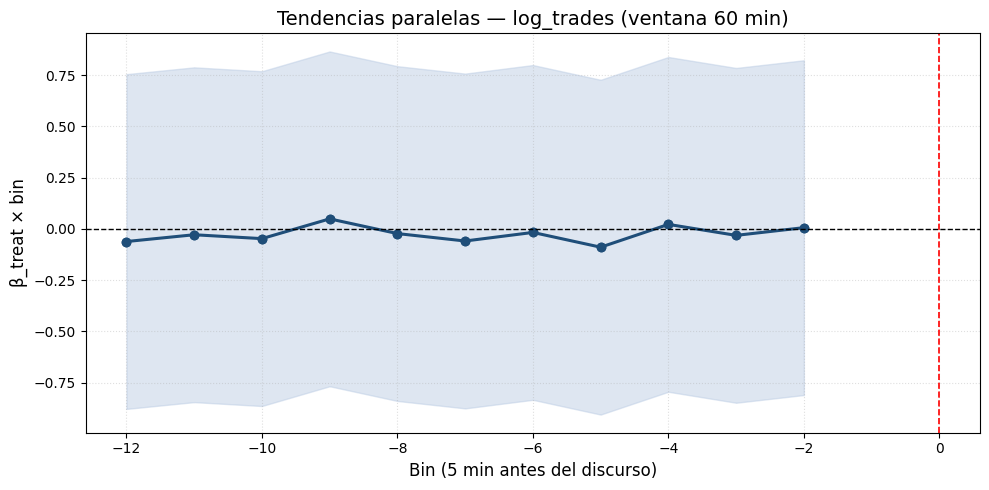


### log_quote_volume ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-12]:treat[0] -0.084515 0.647751 -0.130475 0.896215  -12
C(bin_str)[T.-12]:treat[1] -0.084515 0.647751 -0.130475 0.896215  -12
C(bin_str)[T.-11]:treat[0] -0.021515 0.647751 -0.033215 0.973509  -11
C(bin_str)[T.-11]:treat[1] -0.021515 0.647751 -0.033215 0.973509  -11
C(bin_str)[T.-10]:treat[0]  0.032321 0.647751  0.049898 0.960213  -10
C(bin_str)[T.-10]:treat[1]  0.032321 0.647751  0.049898 0.960213  -10
 C(bin_str)[T.-9]:treat[0]  0.139411 0.647751  0.215223 0.829634   -9
 C(bin_str)[T.-9]:treat[1]  0.139411 0.647751  0.215223 0.829634   -9
 C(bin_str)[T.-8]:treat[0]  0.002688 0.647751  0.004150 0.996689   -8
 C(bin_str)[T.-8]:treat[1]  0.002688 0.647751  0.004150 0.996689   -8
 C(bin_str)[T.-7]:treat[0]  0.026764 0.647751  0.041319 0.967049   -7
 C(bin_str)[T.-7]:treat[1]  0.026764 0.647751  0.041319 0.967049   -7
 C(bin_str)[T.-6]:treat[0]  0.024818 0.647751  0.038314 0.969444

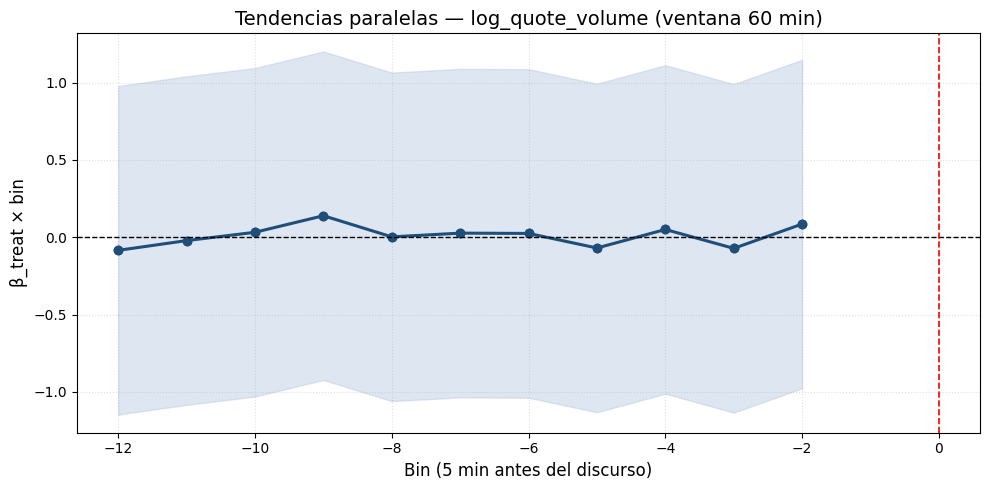


### log_roll_vol_1h ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-12]:treat[0] -0.310093 0.379858 -0.816339 0.414487  -12
C(bin_str)[T.-12]:treat[1] -0.310093 0.379858 -0.816339 0.414487  -12
C(bin_str)[T.-11]:treat[0] -0.205893 0.379858 -0.542026 0.587912  -11
C(bin_str)[T.-11]:treat[1] -0.205893 0.379858 -0.542026 0.587912  -11
C(bin_str)[T.-10]:treat[0] -0.179298 0.379858 -0.472014 0.637012  -10
C(bin_str)[T.-10]:treat[1] -0.179298 0.379858 -0.472014 0.637012  -10
 C(bin_str)[T.-9]:treat[0] -0.104483 0.379858 -0.275057 0.783325   -9
 C(bin_str)[T.-9]:treat[1] -0.104483 0.379858 -0.275057 0.783325   -9
 C(bin_str)[T.-8]:treat[0]  0.310806 0.379858  0.818216 0.413414   -8
 C(bin_str)[T.-8]:treat[1]  0.310806 0.379858  0.818216 0.413414   -8
 C(bin_str)[T.-7]:treat[0] -0.105529 0.379858 -0.277812 0.781210   -7
 C(bin_str)[T.-7]:treat[1] -0.105529 0.379858 -0.277812 0.781210   -7
 C(bin_str)[T.-6]:treat[0] -0.130485 0.379858 -0.343511 0.731281 

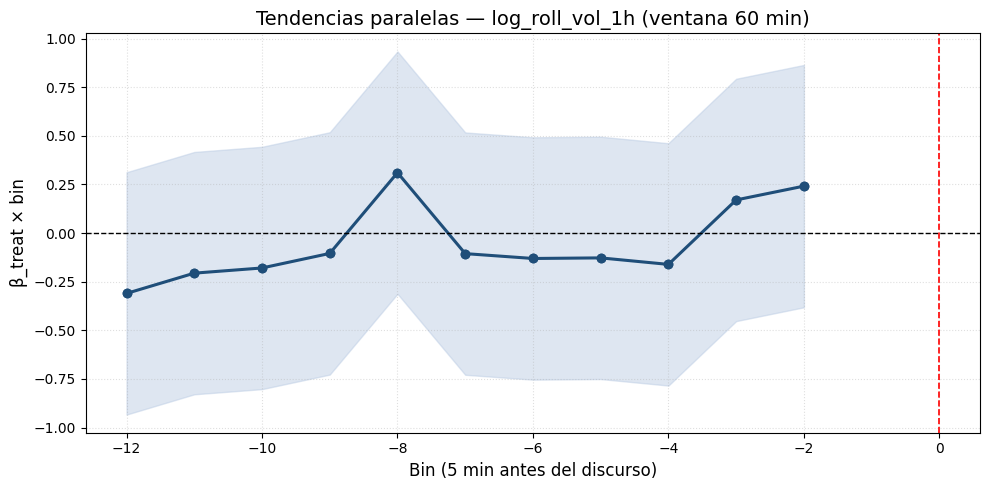


### log_roll_vol_1.5h ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-12]:treat[0] -0.078104 0.240709 -0.324474 0.745642  -12
C(bin_str)[T.-12]:treat[1] -0.078104 0.240709 -0.324474 0.745642  -12
C(bin_str)[T.-11]:treat[0] -0.396351 0.240709 -1.646594 0.099933  -11
C(bin_str)[T.-11]:treat[1] -0.396351 0.240709 -1.646594 0.099933  -11
C(bin_str)[T.-10]:treat[0] -0.397299 0.240709 -1.650534 0.099125  -10
C(bin_str)[T.-10]:treat[1] -0.397299 0.240709 -1.650534 0.099125  -10
 C(bin_str)[T.-9]:treat[0] -0.336895 0.240709 -1.399591 0.161923   -9
 C(bin_str)[T.-9]:treat[1] -0.336895 0.240709 -1.399591 0.161923   -9
 C(bin_str)[T.-8]:treat[0]  0.060354 0.240709  0.250732 0.802069   -8
 C(bin_str)[T.-8]:treat[1]  0.060354 0.240709  0.250732 0.802069   -8
 C(bin_str)[T.-7]:treat[0]  0.048137 0.240709  0.199980 0.841534   -7
 C(bin_str)[T.-7]:treat[1]  0.048137 0.240709  0.199980 0.841534   -7
 C(bin_str)[T.-6]:treat[0]  0.051911 0.240709  0.215658 0.82929

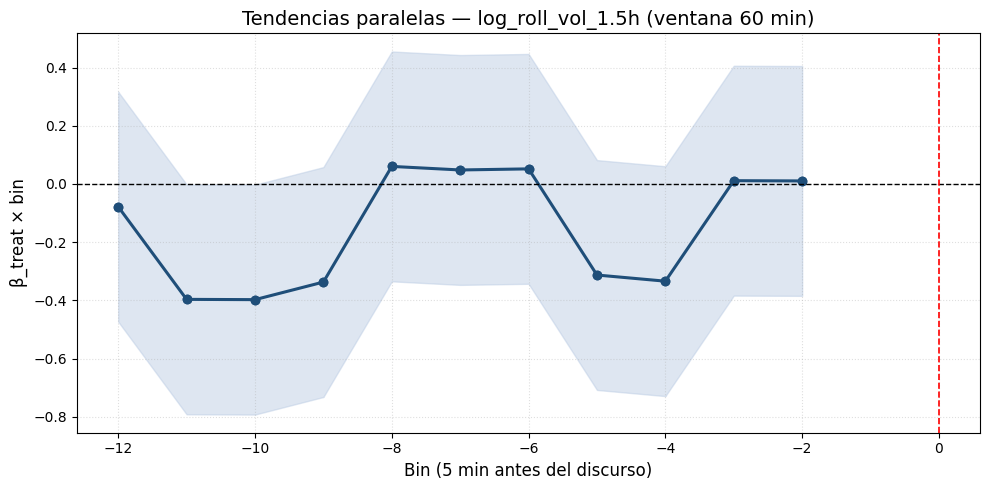


### log_roll_vol_2h ###
                 coef_name      coef      se         t        p  bin
C(bin_str)[T.-12]:treat[0] -0.069666 0.16417 -0.424354 0.671392  -12
C(bin_str)[T.-12]:treat[1] -0.069666 0.16417 -0.424354 0.671392  -12
C(bin_str)[T.-11]:treat[0] -0.066745 0.16417 -0.406559 0.684413  -11
C(bin_str)[T.-11]:treat[1] -0.066745 0.16417 -0.406559 0.684413  -11
C(bin_str)[T.-10]:treat[0] -0.081163 0.16417 -0.494384 0.621136  -10
C(bin_str)[T.-10]:treat[1] -0.081163 0.16417 -0.494384 0.621136  -10
 C(bin_str)[T.-9]:treat[0] -0.402890 0.16417 -2.454104 0.014281   -9
 C(bin_str)[T.-9]:treat[1] -0.402890 0.16417 -2.454104 0.014281   -9
 C(bin_str)[T.-8]:treat[0]  0.006448 0.16417  0.039278 0.968676   -8
 C(bin_str)[T.-8]:treat[1]  0.006448 0.16417  0.039278 0.968676   -8
 C(bin_str)[T.-7]:treat[0]  0.002401 0.16417  0.014626 0.988333   -7
 C(bin_str)[T.-7]:treat[1]  0.002401 0.16417  0.014626 0.988333   -7
 C(bin_str)[T.-6]:treat[0] -0.009311 0.16417 -0.056716 0.954782   -6
 C(bin_st

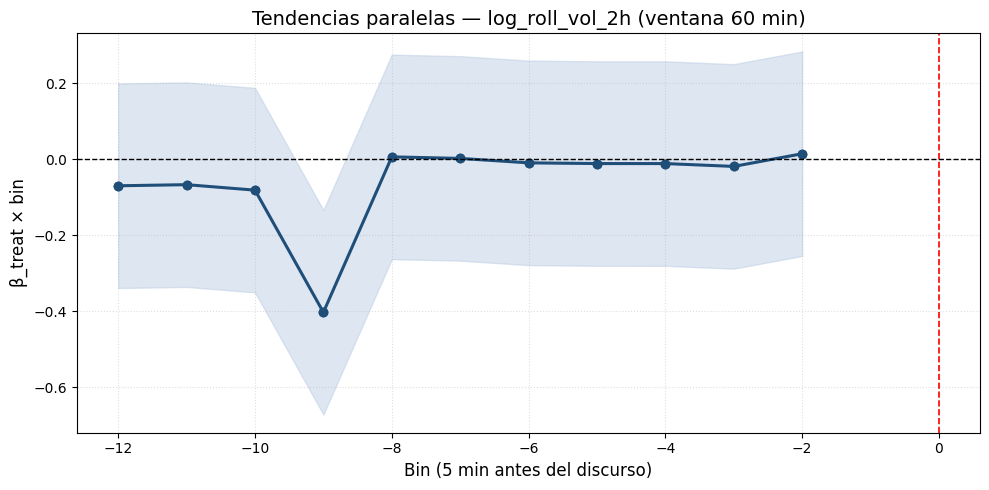


--- Controles COMPLETOS (treat + FE evento + FE símbolo) ---

### log_trades ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-12]:treat[0] -0.061482 0.139683 -0.440153 0.659915  -12
C(bin_str)[T.-12]:treat[1] -0.061482 0.139683 -0.440153 0.659915  -12
C(bin_str)[T.-11]:treat[0] -0.028333 0.139683 -0.202840 0.839299  -11
C(bin_str)[T.-11]:treat[1] -0.028333 0.139683 -0.202840 0.839299  -11
C(bin_str)[T.-10]:treat[0] -0.047332 0.139683 -0.338854 0.734786  -10
C(bin_str)[T.-10]:treat[1] -0.047332 0.139683 -0.338854 0.734786  -10
 C(bin_str)[T.-9]:treat[0]  0.049131 0.139683  0.351734 0.725107   -9
 C(bin_str)[T.-9]:treat[1]  0.049131 0.139683  0.351734 0.725107   -9
 C(bin_str)[T.-8]:treat[0] -0.022660 0.139683 -0.162227 0.871158   -8
 C(bin_str)[T.-8]:treat[1] -0.022660 0.139683 -0.162227 0.871158   -8
 C(bin_str)[T.-7]:treat[0] -0.058890 0.139683 -0.421593 0.673406   -7
 C(bin_str)[T.-7]:treat[1] -0.058890 0.139683 -0.421593 0.673406   -7
 C(bin_s

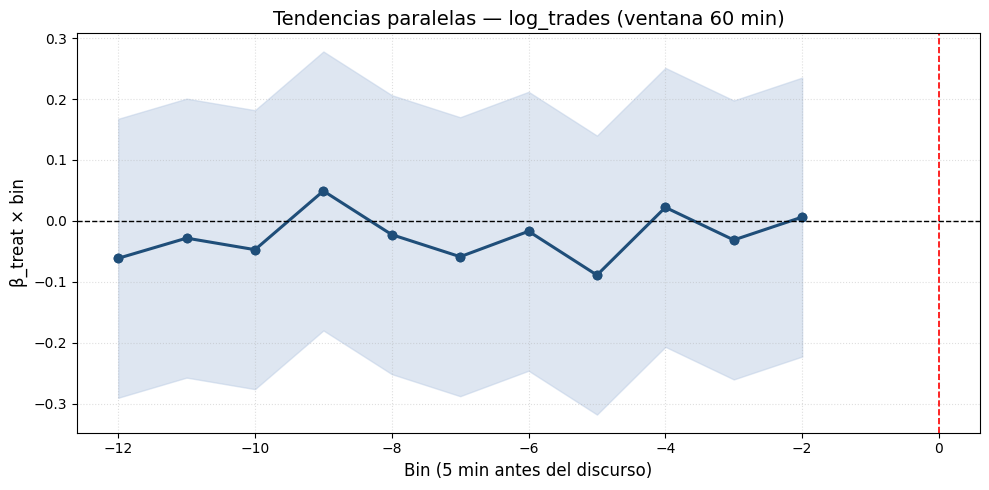


### log_quote_volume ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-12]:treat[0] -0.084515 0.309916 -0.272704 0.785134  -12
C(bin_str)[T.-12]:treat[1] -0.084515 0.309916 -0.272704 0.785134  -12
C(bin_str)[T.-11]:treat[0] -0.021515 0.309916 -0.069423 0.944666  -11
C(bin_str)[T.-11]:treat[1] -0.021515 0.309916 -0.069423 0.944666  -11
C(bin_str)[T.-10]:treat[0]  0.032321 0.309916  0.104291 0.916958  -10
C(bin_str)[T.-10]:treat[1]  0.032321 0.309916  0.104291 0.916958  -10
 C(bin_str)[T.-9]:treat[0]  0.139411 0.309916  0.449835 0.652920   -9
 C(bin_str)[T.-9]:treat[1]  0.139411 0.309916  0.449835 0.652920   -9
 C(bin_str)[T.-8]:treat[0]  0.002688 0.309916  0.008675 0.993080   -8
 C(bin_str)[T.-8]:treat[1]  0.002688 0.309916  0.008675 0.993080   -8
 C(bin_str)[T.-7]:treat[0]  0.026764 0.309916  0.086360 0.931197   -7
 C(bin_str)[T.-7]:treat[1]  0.026764 0.309916  0.086360 0.931197   -7
 C(bin_str)[T.-6]:treat[0]  0.024818 0.309916  0.080079 0.936189

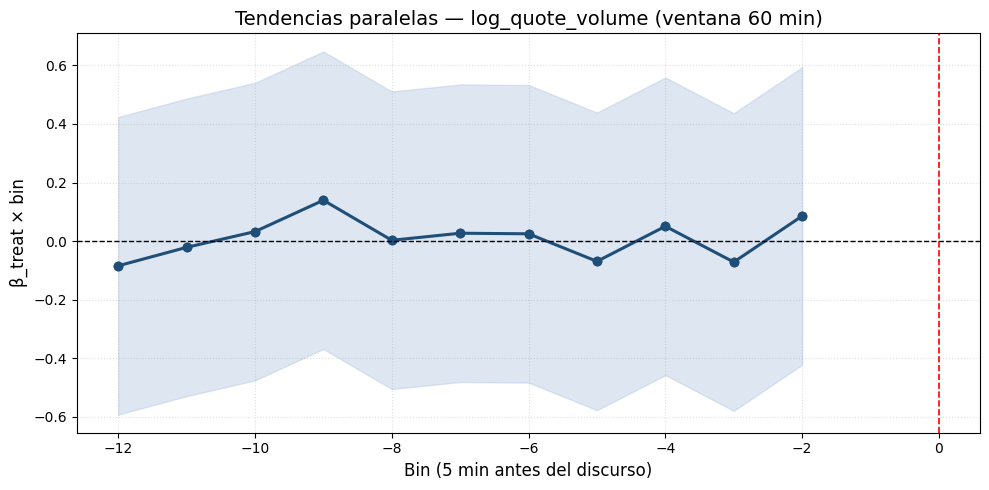


### log_roll_vol_1h ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-12]:treat[0] -0.310093 0.352249 -0.880323 0.378881  -12
C(bin_str)[T.-12]:treat[1] -0.310093 0.352249 -0.880323 0.378881  -12
C(bin_str)[T.-11]:treat[0] -0.205893 0.352249 -0.584510 0.559000  -11
C(bin_str)[T.-11]:treat[1] -0.205893 0.352249 -0.584510 0.559000  -11
C(bin_str)[T.-10]:treat[0] -0.179298 0.352249 -0.509010 0.610850  -10
C(bin_str)[T.-10]:treat[1] -0.179298 0.352249 -0.509010 0.610850  -10
 C(bin_str)[T.-9]:treat[0] -0.104483 0.352249 -0.296616 0.766817   -9
 C(bin_str)[T.-9]:treat[1] -0.104483 0.352249 -0.296616 0.766817   -9
 C(bin_str)[T.-8]:treat[0]  0.310806 0.352249  0.882348 0.377786   -8
 C(bin_str)[T.-8]:treat[1]  0.310806 0.352249  0.882348 0.377786   -8
 C(bin_str)[T.-7]:treat[0] -0.105529 0.352249 -0.299587 0.764551   -7
 C(bin_str)[T.-7]:treat[1] -0.105529 0.352249 -0.299587 0.764551   -7
 C(bin_str)[T.-6]:treat[0] -0.130485 0.352249 -0.370435 0.711132 

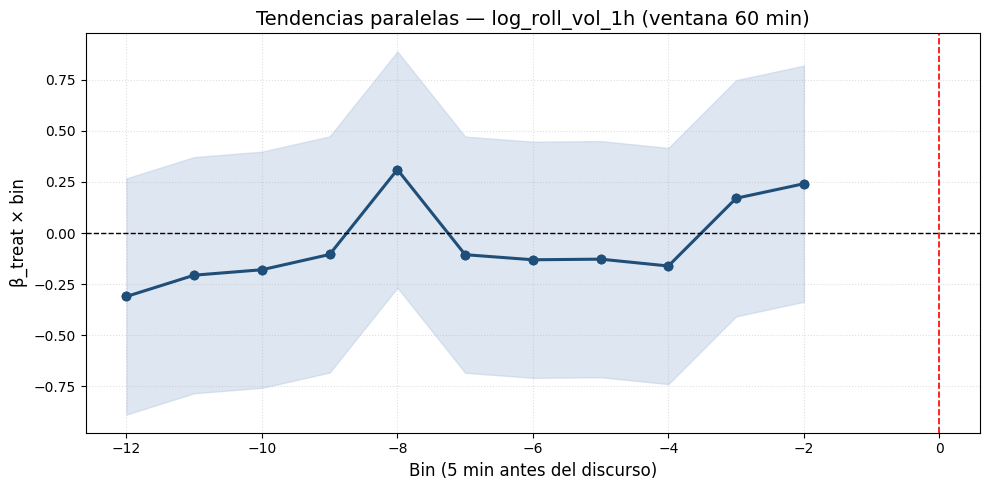


### log_roll_vol_1.5h ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-12]:treat[0] -0.078104 0.207575 -0.376268 0.706792  -12
C(bin_str)[T.-12]:treat[1] -0.078104 0.207575 -0.376268 0.706792  -12
C(bin_str)[T.-11]:treat[0] -0.396351 0.207575 -1.909431 0.056473  -11
C(bin_str)[T.-11]:treat[1] -0.396351 0.207575 -1.909431 0.056473  -11
C(bin_str)[T.-10]:treat[0] -0.397299 0.207575 -1.914000 0.055886  -10
C(bin_str)[T.-10]:treat[1] -0.397299 0.207575 -1.914000 0.055886  -10
 C(bin_str)[T.-9]:treat[0] -0.336895 0.207575 -1.623001 0.104883   -9
 C(bin_str)[T.-9]:treat[1] -0.336895 0.207575 -1.623001 0.104883   -9
 C(bin_str)[T.-8]:treat[0]  0.060354 0.207575  0.290755 0.771295   -8
 C(bin_str)[T.-8]:treat[1]  0.060354 0.207575  0.290755 0.771295   -8
 C(bin_str)[T.-7]:treat[0]  0.048137 0.207575  0.231902 0.816658   -7
 C(bin_str)[T.-7]:treat[1]  0.048137 0.207575  0.231902 0.816658   -7
 C(bin_str)[T.-6]:treat[0]  0.051911 0.207575  0.250082 0.80257

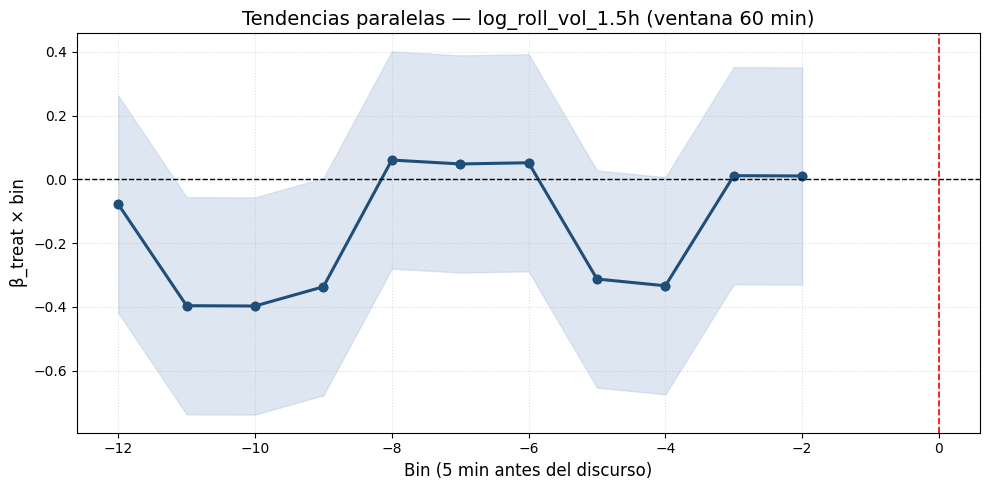


### log_roll_vol_2h ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-12]:treat[0] -0.069666 0.108387 -0.642752 0.520522  -12
C(bin_str)[T.-12]:treat[1] -0.069666 0.108387 -0.642752 0.520522  -12
C(bin_str)[T.-11]:treat[0] -0.066745 0.108387 -0.615798 0.538158  -11
C(bin_str)[T.-11]:treat[1] -0.066745 0.108387 -0.615798 0.538158  -11
C(bin_str)[T.-10]:treat[0] -0.081163 0.108387 -0.748824 0.454128  -10
C(bin_str)[T.-10]:treat[1] -0.081163 0.108387 -0.748824 0.454128  -10
 C(bin_str)[T.-9]:treat[0] -0.402890 0.108387 -3.717131 0.000212   -9
 C(bin_str)[T.-9]:treat[1] -0.402890 0.108387 -3.717131 0.000212   -9
 C(bin_str)[T.-8]:treat[0]  0.006448 0.108387  0.059493 0.952571   -8
 C(bin_str)[T.-8]:treat[1]  0.006448 0.108387  0.059493 0.952571   -8
 C(bin_str)[T.-7]:treat[0]  0.002401 0.108387  0.022153 0.982330   -7
 C(bin_str)[T.-7]:treat[1]  0.002401 0.108387  0.022153 0.982330   -7
 C(bin_str)[T.-6]:treat[0] -0.009311 0.108387 -0.085905 0.931558 

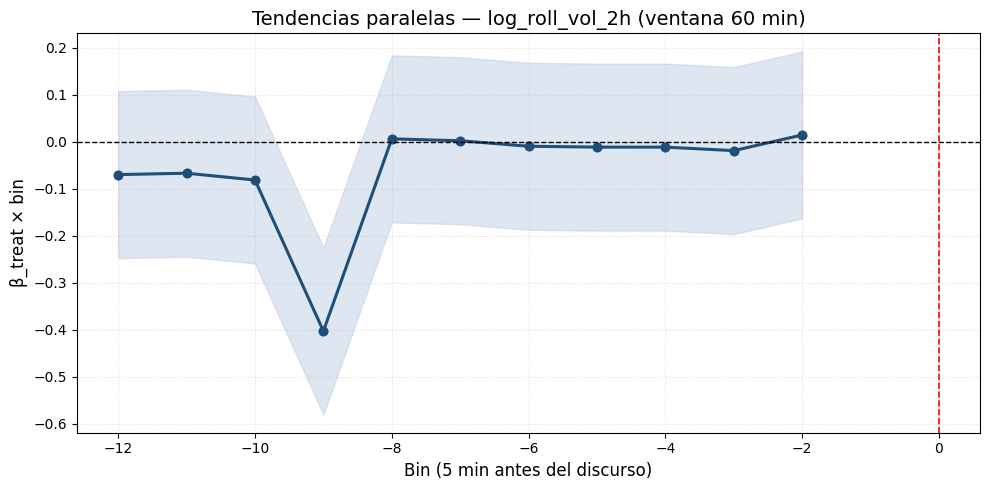


=== TEST DE TENDENCIAS PARALELAS — VENTANA 90 min ===

--- Controles BASE (treat + FE evento) ---

### log_trades ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-18]:treat[0] -0.101622 0.496456 -0.204694 0.837837  -18
C(bin_str)[T.-18]:treat[1] -0.101622 0.496456 -0.204694 0.837837  -18
C(bin_str)[T.-17]:treat[0] -0.054984 0.496456 -0.110754 0.911825  -17
C(bin_str)[T.-17]:treat[1] -0.054984 0.496456 -0.110754 0.911825  -17
C(bin_str)[T.-16]:treat[0] -0.111829 0.496456 -0.225254 0.821810  -16
C(bin_str)[T.-16]:treat[1] -0.111829 0.496456 -0.225254 0.821810  -16
C(bin_str)[T.-15]:treat[0] -0.110836 0.496456 -0.223254 0.823366  -15
C(bin_str)[T.-15]:treat[1] -0.110836 0.496456 -0.223254 0.823366  -15
C(bin_str)[T.-14]:treat[0] -0.036656 0.496456 -0.073835 0.941151  -14
C(bin_str)[T.-14]:treat[1] -0.036656 0.496456 -0.073835 0.941151  -14
C(bin_str)[T.-13]:treat[0] -0.097140 0.496456 -0.195666 0.844896  -13
C(bin_str)[T.-13]:treat[1] -0.097140 0.49

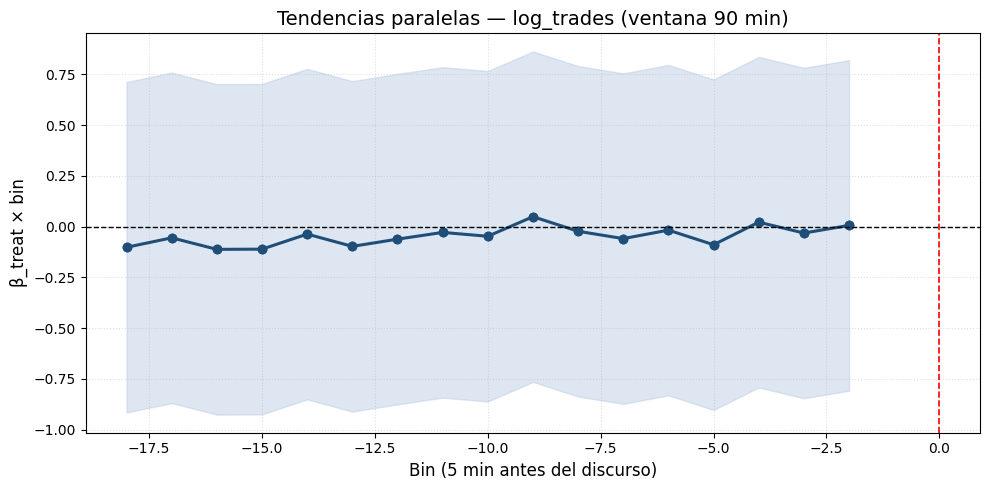


### log_quote_volume ###
                 coef_name      coef      se         t        p  bin
C(bin_str)[T.-18]:treat[0] -0.066729 0.64797 -0.102981 0.917991  -18
C(bin_str)[T.-18]:treat[1] -0.066729 0.64797 -0.102981 0.917991  -18
C(bin_str)[T.-17]:treat[0]  0.074197 0.64797  0.114507 0.908850  -17
C(bin_str)[T.-17]:treat[1]  0.074197 0.64797  0.114507 0.908850  -17
C(bin_str)[T.-16]:treat[0] -0.104136 0.64797 -0.160711 0.872341  -16
C(bin_str)[T.-16]:treat[1] -0.104136 0.64797 -0.160711 0.872341  -16
C(bin_str)[T.-15]:treat[0] -0.005700 0.64797 -0.008797 0.992982  -15
C(bin_str)[T.-15]:treat[1] -0.005700 0.64797 -0.008797 0.992982  -15
C(bin_str)[T.-14]:treat[0]  0.036463 0.64797  0.056273 0.955131  -14
C(bin_str)[T.-14]:treat[1]  0.036463 0.64797  0.056273 0.955131  -14
C(bin_str)[T.-13]:treat[0] -0.083331 0.64797 -0.128603 0.897687  -13
C(bin_str)[T.-13]:treat[1] -0.083331 0.64797 -0.128603 0.897687  -13
C(bin_str)[T.-12]:treat[0] -0.084515 0.64797 -0.130431 0.896242  -12
C(bin_st

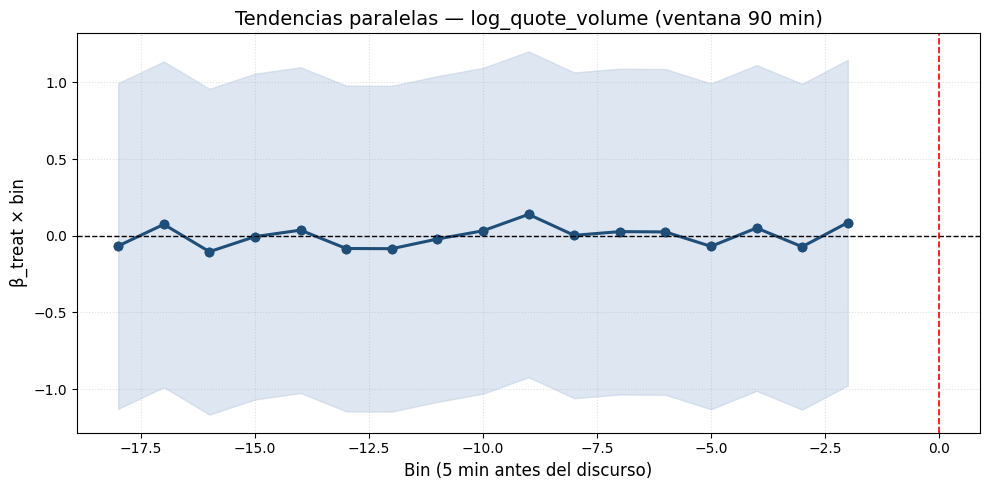


### log_roll_vol_1h ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-18]:treat[0]  0.178769 0.376281  0.475093 0.634784  -18
C(bin_str)[T.-18]:treat[1]  0.178769 0.376281  0.475093 0.634784  -18
C(bin_str)[T.-17]:treat[0]  0.260563 0.376281  0.692470 0.488741  -17
C(bin_str)[T.-17]:treat[1]  0.260563 0.376281  0.692470 0.488741  -17
C(bin_str)[T.-16]:treat[0]  0.131748 0.376281  0.350131 0.726286  -16
C(bin_str)[T.-16]:treat[1]  0.131748 0.376281  0.350131 0.726286  -16
C(bin_str)[T.-15]:treat[0]  0.206045 0.376281  0.547583 0.584054  -15
C(bin_str)[T.-15]:treat[1]  0.206045 0.376281  0.547583 0.584054  -15
C(bin_str)[T.-14]:treat[0]  0.189663 0.376281  0.504046 0.614297  -14
C(bin_str)[T.-14]:treat[1]  0.189663 0.376281  0.504046 0.614297  -14
C(bin_str)[T.-13]:treat[0] -0.246640 0.376281 -0.655467 0.512260  -13
C(bin_str)[T.-13]:treat[1] -0.246640 0.376281 -0.655467 0.512260  -13
C(bin_str)[T.-12]:treat[0] -0.310093 0.376281 -0.824100 0.410004 

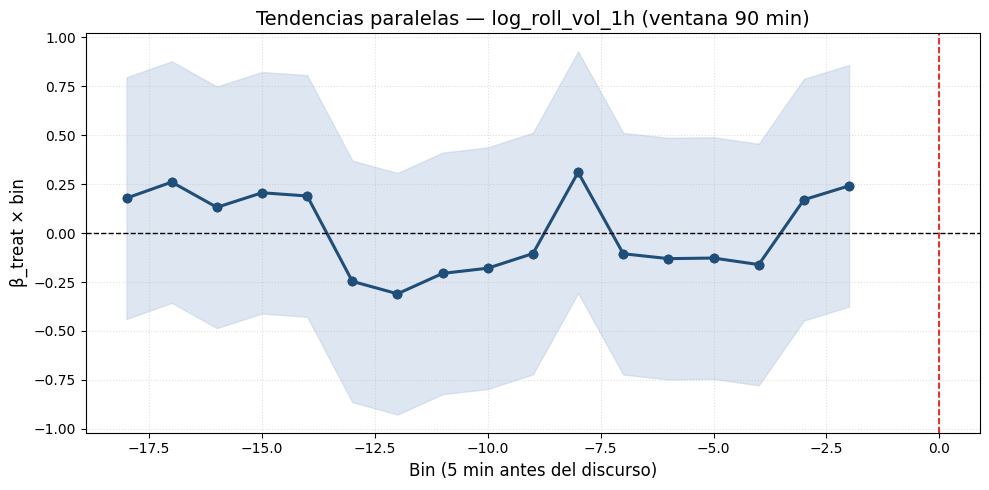


### log_roll_vol_1.5h ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-18]:treat[0] -0.023361 0.237279 -0.098455 0.921583  -18
C(bin_str)[T.-18]:treat[1] -0.023361 0.237279 -0.098455 0.921583  -18
C(bin_str)[T.-17]:treat[0]  0.071742 0.237279  0.302351 0.762423  -17
C(bin_str)[T.-17]:treat[1]  0.071742 0.237279  0.302351 0.762423  -17
C(bin_str)[T.-16]:treat[0]  0.014596 0.237279  0.061515 0.950957  -16
C(bin_str)[T.-16]:treat[1]  0.014596 0.237279  0.061515 0.950957  -16
C(bin_str)[T.-15]:treat[0]  0.012121 0.237279  0.051081 0.959267  -15
C(bin_str)[T.-15]:treat[1]  0.012121 0.237279  0.051081 0.959267  -15
C(bin_str)[T.-14]:treat[0]  0.010583 0.237279  0.044601 0.964431  -14
C(bin_str)[T.-14]:treat[1]  0.010583 0.237279  0.044601 0.964431  -14
C(bin_str)[T.-13]:treat[0] -0.011754 0.237279 -0.049535 0.960499  -13
C(bin_str)[T.-13]:treat[1] -0.011754 0.237279 -0.049535 0.960499  -13
C(bin_str)[T.-12]:treat[0] -0.078104 0.237279 -0.329164 0.74207

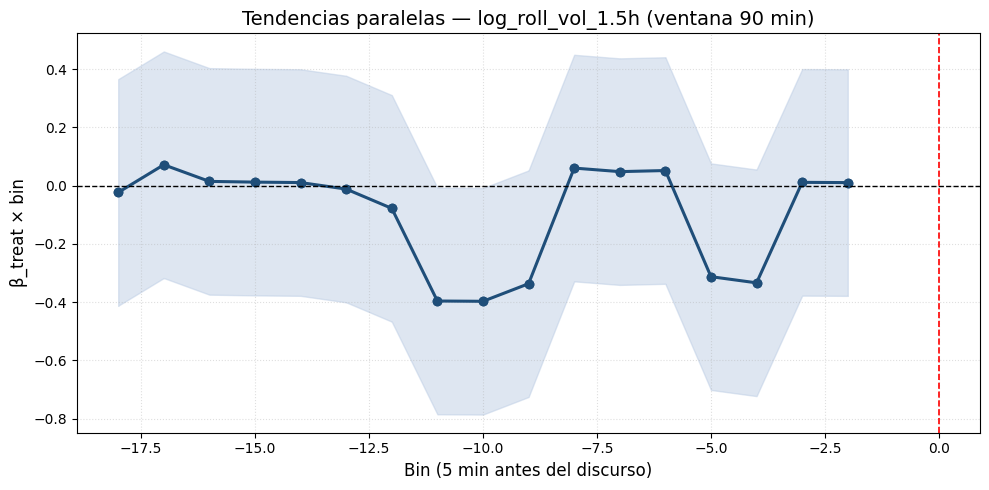


### log_roll_vol_2h ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-18]:treat[0] -0.107376 0.165547 -0.648616 0.516678  -18
C(bin_str)[T.-18]:treat[1] -0.107376 0.165547 -0.648616 0.516678  -18
C(bin_str)[T.-17]:treat[0] -0.021981 0.165547 -0.132776 0.894387  -17
C(bin_str)[T.-17]:treat[1] -0.021981 0.165547 -0.132776 0.894387  -17
C(bin_str)[T.-16]:treat[0] -0.027644 0.165547 -0.166987 0.867401  -16
C(bin_str)[T.-16]:treat[1] -0.027644 0.165547 -0.166987 0.867401  -16
C(bin_str)[T.-15]:treat[0] -0.017308 0.165547 -0.104553 0.916743  -15
C(bin_str)[T.-15]:treat[1] -0.017308 0.165547 -0.104553 0.916743  -15
C(bin_str)[T.-14]:treat[0] -0.042813 0.165547 -0.258614 0.795966  -14
C(bin_str)[T.-14]:treat[1] -0.042813 0.165547 -0.258614 0.795966  -14
C(bin_str)[T.-13]:treat[0] -0.030440 0.165547 -0.183878 0.854132  -13
C(bin_str)[T.-13]:treat[1] -0.030440 0.165547 -0.183878 0.854132  -13
C(bin_str)[T.-12]:treat[0] -0.069666 0.165547 -0.420825 0.673938 

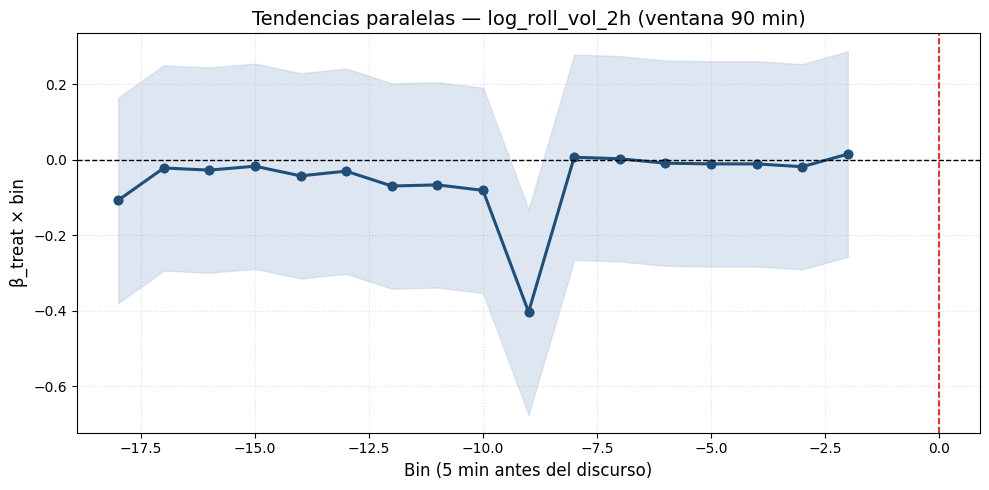


--- Controles COMPLETOS (treat + FE evento + FE símbolo) ---

### log_trades ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-18]:treat[0] -0.101622 0.139911 -0.726332 0.467740  -18
C(bin_str)[T.-18]:treat[1] -0.101622 0.139911 -0.726332 0.467740  -18
C(bin_str)[T.-17]:treat[0] -0.054984 0.139911 -0.392996 0.694375  -17
C(bin_str)[T.-17]:treat[1] -0.054984 0.139911 -0.392996 0.694375  -17
C(bin_str)[T.-16]:treat[0] -0.111829 0.139911 -0.799287 0.424241  -16
C(bin_str)[T.-16]:treat[1] -0.111829 0.139911 -0.799287 0.424241  -16
C(bin_str)[T.-15]:treat[0] -0.110836 0.139911 -0.792190 0.428366  -15
C(bin_str)[T.-15]:treat[1] -0.110836 0.139911 -0.792190 0.428366  -15
C(bin_str)[T.-14]:treat[0] -0.036656 0.139911 -0.261994 0.793359  -14
C(bin_str)[T.-14]:treat[1] -0.036656 0.139911 -0.261994 0.793359  -14
C(bin_str)[T.-13]:treat[0] -0.097140 0.139911 -0.694297 0.487595  -13
C(bin_str)[T.-13]:treat[1] -0.097140 0.139911 -0.694297 0.487595  -13
C(bin_st

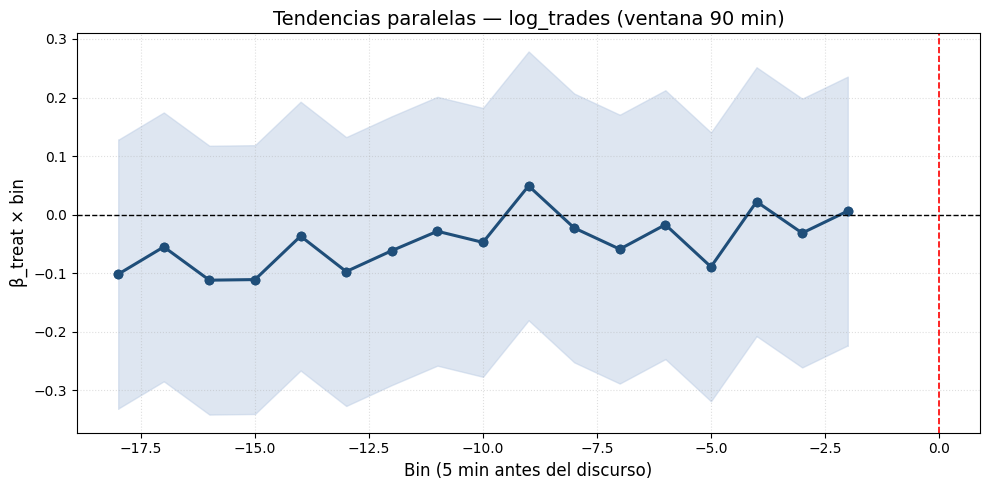


### log_quote_volume ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-18]:treat[0] -0.066729 0.312875 -0.213276 0.831139  -18
C(bin_str)[T.-18]:treat[1] -0.066729 0.312875 -0.213276 0.831139  -18
C(bin_str)[T.-17]:treat[0]  0.074197 0.312875  0.237146 0.812574  -17
C(bin_str)[T.-17]:treat[1]  0.074197 0.312875  0.237146 0.812574  -17
C(bin_str)[T.-16]:treat[0] -0.104136 0.312875 -0.332836 0.739301  -16
C(bin_str)[T.-16]:treat[1] -0.104136 0.312875 -0.332836 0.739301  -16
C(bin_str)[T.-15]:treat[0] -0.005700 0.312875 -0.018219 0.985466  -15
C(bin_str)[T.-15]:treat[1] -0.005700 0.312875 -0.018219 0.985466  -15
C(bin_str)[T.-14]:treat[0]  0.036463 0.312875  0.116542 0.907238  -14
C(bin_str)[T.-14]:treat[1]  0.036463 0.312875  0.116542 0.907238  -14
C(bin_str)[T.-13]:treat[0] -0.083331 0.312875 -0.266340 0.790011  -13
C(bin_str)[T.-13]:treat[1] -0.083331 0.312875 -0.266340 0.790011  -13
C(bin_str)[T.-12]:treat[0] -0.084515 0.312875 -0.270124 0.787099

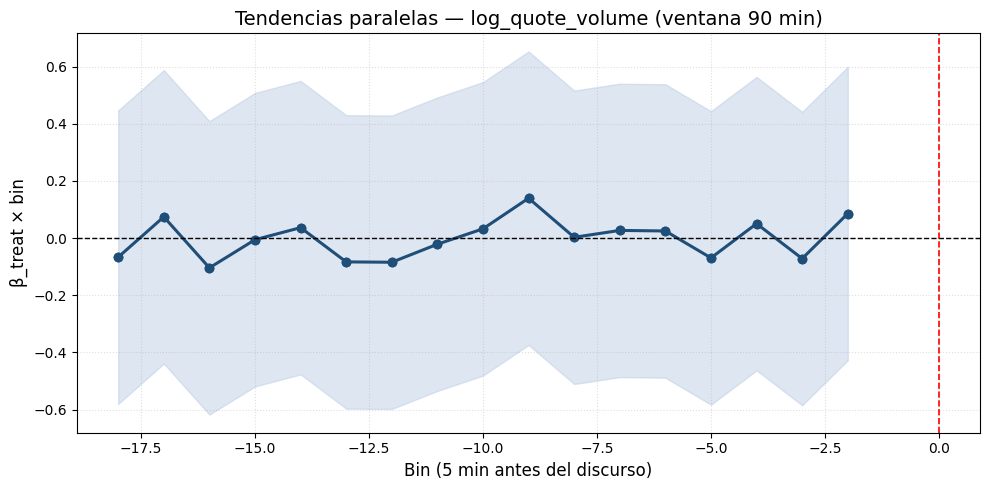


### log_roll_vol_1h ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-18]:treat[0]  0.178769 0.348248  0.513337 0.607786  -18
C(bin_str)[T.-18]:treat[1]  0.178769 0.348248  0.513337 0.607786  -18
C(bin_str)[T.-17]:treat[0]  0.260563 0.348248  0.748211 0.454442  -17
C(bin_str)[T.-17]:treat[1]  0.260563 0.348248  0.748211 0.454442  -17
C(bin_str)[T.-16]:treat[0]  0.131748 0.348248  0.378315 0.705246  -16
C(bin_str)[T.-16]:treat[1]  0.131748 0.348248  0.378315 0.705246  -16
C(bin_str)[T.-15]:treat[0]  0.206045 0.348248  0.591661 0.554160  -15
C(bin_str)[T.-15]:treat[1]  0.206045 0.348248  0.591661 0.554160  -15
C(bin_str)[T.-14]:treat[0]  0.189663 0.348248  0.544620 0.586090  -14
C(bin_str)[T.-14]:treat[1]  0.189663 0.348248  0.544620 0.586090  -14
C(bin_str)[T.-13]:treat[0] -0.246640 0.348248 -0.708230 0.478904  -13
C(bin_str)[T.-13]:treat[1] -0.246640 0.348248 -0.708230 0.478904  -13
C(bin_str)[T.-12]:treat[0] -0.310093 0.348248 -0.890437 0.373363 

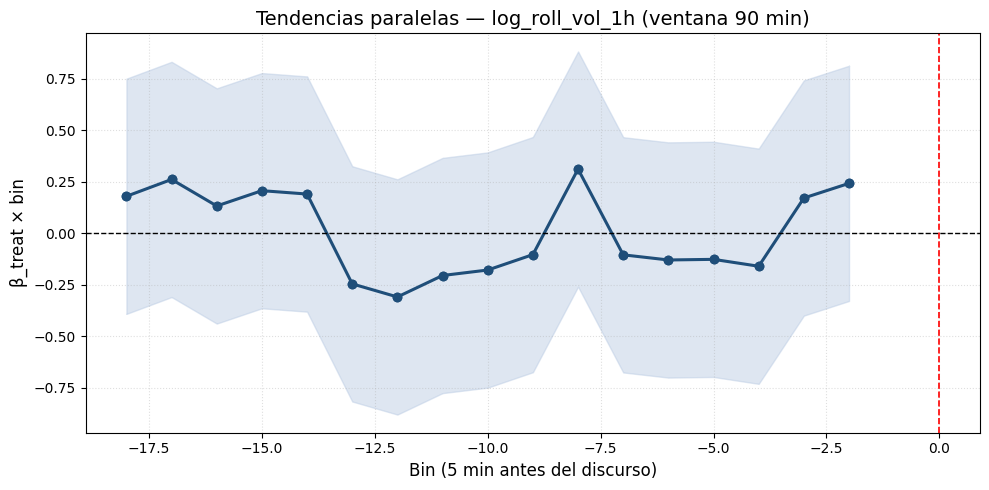


### log_roll_vol_1.5h ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-18]:treat[0] -0.023361 0.203975 -0.114531 0.908831  -18
C(bin_str)[T.-18]:treat[1] -0.023361 0.203975 -0.114531 0.908831  -18
C(bin_str)[T.-17]:treat[0]  0.071742 0.203975  0.351718 0.725095  -17
C(bin_str)[T.-17]:treat[1]  0.071742 0.203975  0.351718 0.725095  -17
C(bin_str)[T.-16]:treat[0]  0.014596 0.203975  0.071559 0.942962  -16
C(bin_str)[T.-16]:treat[1]  0.014596 0.203975  0.071559 0.942962  -16
C(bin_str)[T.-15]:treat[0]  0.012121 0.203975  0.059422 0.952623  -15
C(bin_str)[T.-15]:treat[1]  0.012121 0.203975  0.059422 0.952623  -15
C(bin_str)[T.-14]:treat[0]  0.010583 0.203975  0.051883 0.958628  -14
C(bin_str)[T.-14]:treat[1]  0.010583 0.203975  0.051883 0.958628  -14
C(bin_str)[T.-13]:treat[0] -0.011754 0.203975 -0.057623 0.954056  -13
C(bin_str)[T.-13]:treat[1] -0.011754 0.203975 -0.057623 0.954056  -13
C(bin_str)[T.-12]:treat[0] -0.078104 0.203975 -0.382909 0.70183

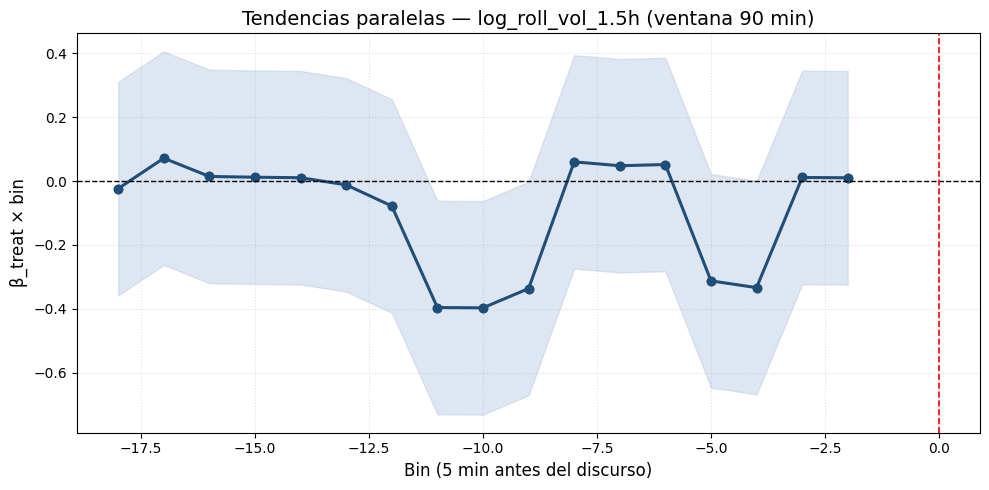


### log_roll_vol_2h ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-18]:treat[0] -0.107376 0.113087 -0.949503 0.342507  -18
C(bin_str)[T.-18]:treat[1] -0.107376 0.113087 -0.949503 0.342507  -18
C(bin_str)[T.-17]:treat[0] -0.021981 0.113087 -0.194369 0.845911  -17
C(bin_str)[T.-17]:treat[1] -0.021981 0.113087 -0.194369 0.845911  -17
C(bin_str)[T.-16]:treat[0] -0.027644 0.113087 -0.244450 0.806913  -16
C(bin_str)[T.-16]:treat[1] -0.027644 0.113087 -0.244450 0.806913  -16
C(bin_str)[T.-15]:treat[0] -0.017308 0.113087 -0.153054 0.878375  -15
C(bin_str)[T.-15]:treat[1] -0.017308 0.113087 -0.153054 0.878375  -15
C(bin_str)[T.-14]:treat[0] -0.042813 0.113087 -0.378583 0.705048  -14
C(bin_str)[T.-14]:treat[1] -0.042813 0.113087 -0.378583 0.705048  -14
C(bin_str)[T.-13]:treat[0] -0.030440 0.113087 -0.269177 0.787828  -13
C(bin_str)[T.-13]:treat[1] -0.030440 0.113087 -0.269177 0.787828  -13
C(bin_str)[T.-12]:treat[0] -0.069666 0.113087 -0.616042 0.537953 

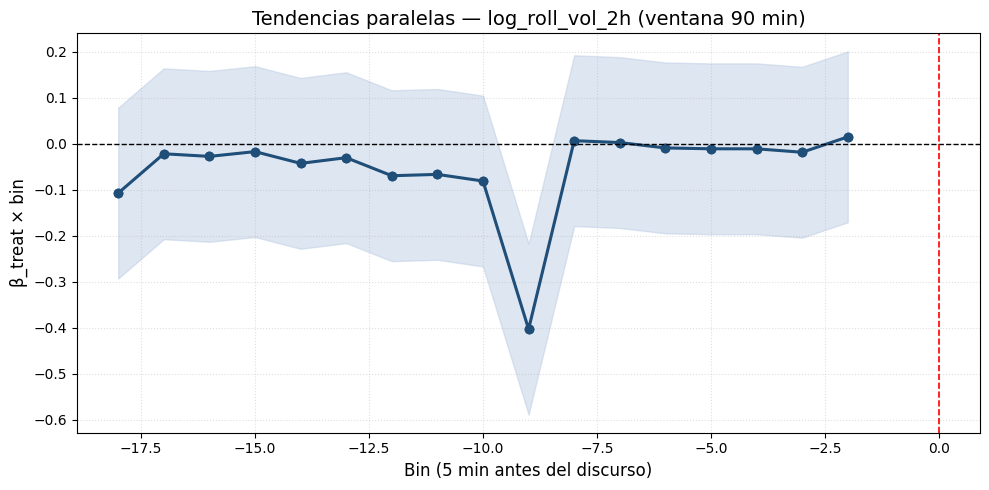


=== TEST DE TENDENCIAS PARALELAS — VENTANA 120 min ===

--- Controles BASE (treat + FE evento) ---

### log_trades ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-24]:treat[1] -0.124189 0.494387 -0.251197 0.801686  -24
C(bin_str)[T.-24]:treat[0] -0.124189 0.494387 -0.251197 0.801686  -24
C(bin_str)[T.-23]:treat[0] -0.144041 0.494387 -0.291353 0.770809  -23
C(bin_str)[T.-23]:treat[1] -0.144041 0.494387 -0.291353 0.770809  -23
C(bin_str)[T.-22]:treat[1] -0.101932 0.494387 -0.206178 0.836671  -22
C(bin_str)[T.-22]:treat[0] -0.101932 0.494387 -0.206178 0.836671  -22
C(bin_str)[T.-21]:treat[1] -0.126765 0.494387 -0.256409 0.797659  -21
C(bin_str)[T.-21]:treat[0] -0.126765 0.494387 -0.256409 0.797659  -21
C(bin_str)[T.-20]:treat[1] -0.089503 0.494387 -0.181038 0.856354  -20
C(bin_str)[T.-20]:treat[0] -0.089503 0.494387 -0.181038 0.856354  -20
C(bin_str)[T.-19]:treat[1] -0.138529 0.494387 -0.280203 0.779348  -19
C(bin_str)[T.-19]:treat[0] -0.138529 0.4

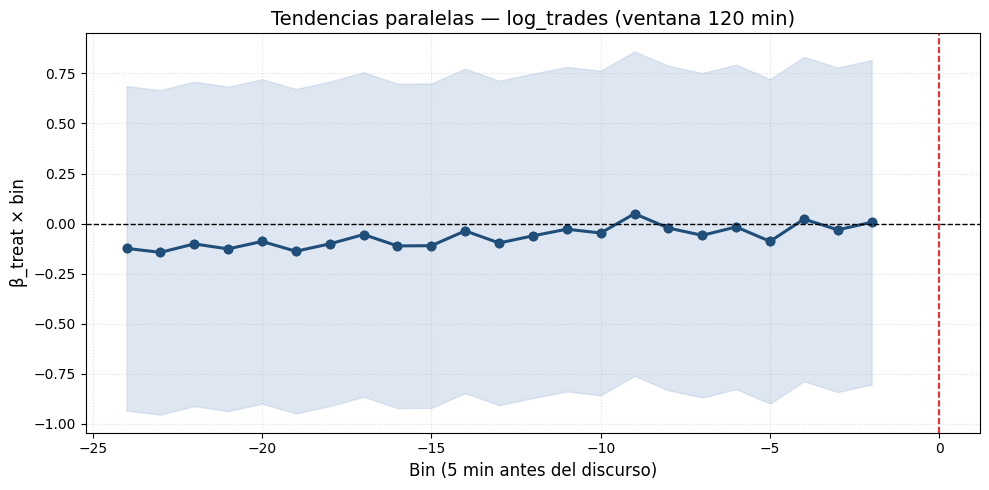


### log_quote_volume ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-24]:treat[1] -0.105307 0.648132 -0.162477 0.870945  -24
C(bin_str)[T.-24]:treat[0] -0.105307 0.648132 -0.162477 0.870945  -24
C(bin_str)[T.-23]:treat[0] -0.144530 0.648132 -0.222995 0.823561  -23
C(bin_str)[T.-23]:treat[1] -0.144530 0.648132 -0.222995 0.823561  -23
C(bin_str)[T.-22]:treat[1] -0.038886 0.648132 -0.059996 0.952164  -22
C(bin_str)[T.-22]:treat[0] -0.038886 0.648132 -0.059996 0.952164  -22
C(bin_str)[T.-21]:treat[1] -0.074468 0.648132 -0.114896 0.908538  -21
C(bin_str)[T.-21]:treat[0] -0.074468 0.648132 -0.114896 0.908538  -21
C(bin_str)[T.-20]:treat[1] -0.058364 0.648132 -0.090050 0.928256  -20
C(bin_str)[T.-20]:treat[0] -0.058364 0.648132 -0.090050 0.928256  -20
C(bin_str)[T.-19]:treat[1] -0.193296 0.648132 -0.298235 0.765553  -19
C(bin_str)[T.-19]:treat[0] -0.193296 0.648132 -0.298235 0.765553  -19
C(bin_str)[T.-18]:treat[1] -0.066729 0.648132 -0.102955 0.918008

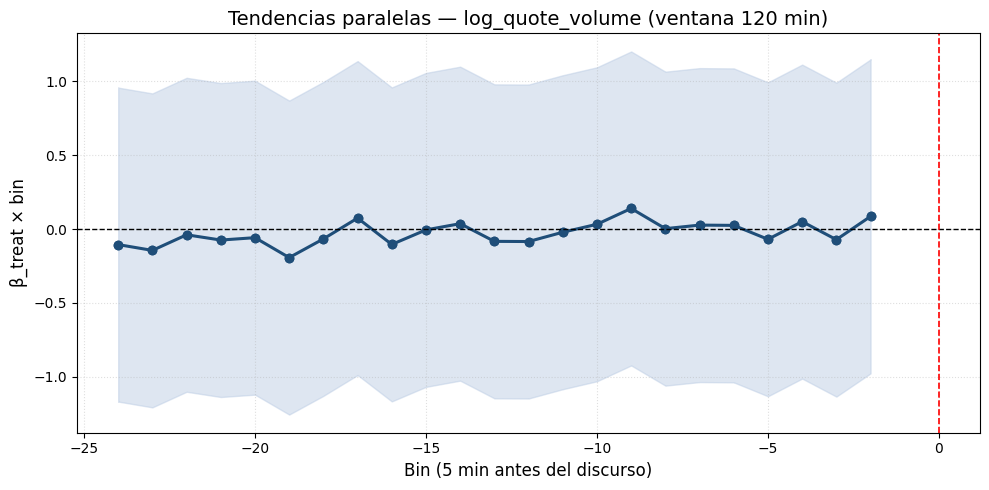


### log_roll_vol_1h ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-24]:treat[1] -0.179925 0.407388 -0.441655 0.658783  -24
C(bin_str)[T.-24]:treat[0] -0.179925 0.407388 -0.441655 0.658783  -24
C(bin_str)[T.-23]:treat[0] -0.240029 0.407388 -0.589191 0.555795  -23
C(bin_str)[T.-23]:treat[1] -0.240029 0.407388 -0.589191 0.555795  -23
C(bin_str)[T.-22]:treat[1] -0.256637 0.407388 -0.629957 0.528789  -22
C(bin_str)[T.-22]:treat[0] -0.256637 0.407388 -0.629957 0.528789  -22
C(bin_str)[T.-21]:treat[1] -0.278786 0.407388 -0.684326 0.493842  -21
C(bin_str)[T.-21]:treat[0] -0.278786 0.407388 -0.684326 0.493842  -21
C(bin_str)[T.-20]:treat[1] -0.183493 0.407388 -0.450414 0.652457  -20
C(bin_str)[T.-20]:treat[0] -0.183493 0.407388 -0.450414 0.652457  -20
C(bin_str)[T.-19]:treat[1]  0.176300 0.407388  0.432756 0.665235  -19
C(bin_str)[T.-19]:treat[0]  0.176300 0.407388  0.432756 0.665235  -19
C(bin_str)[T.-18]:treat[1]  0.178769 0.407388  0.438817 0.660838 

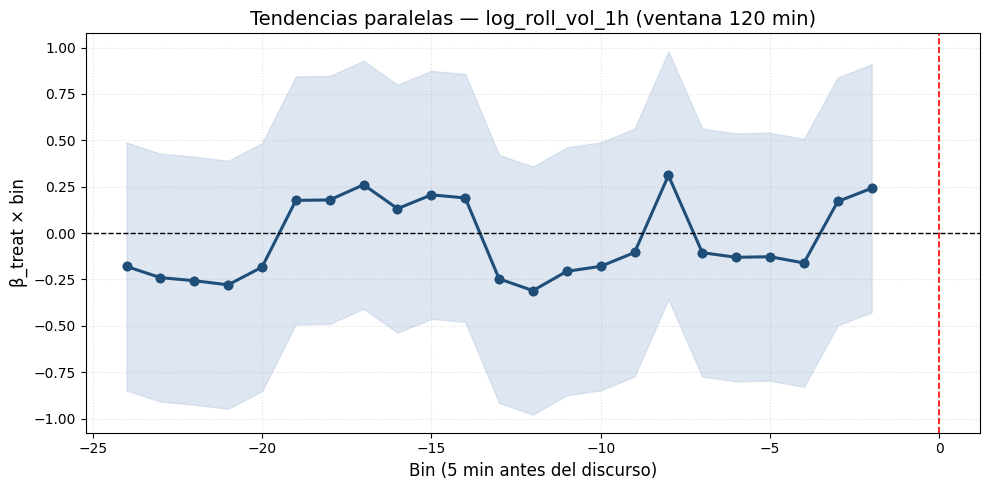


### log_roll_vol_1.5h ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-24]:treat[1] -0.415524 0.272165 -1.526733 0.126973  -24
C(bin_str)[T.-24]:treat[0] -0.415524 0.272165 -1.526733 0.126973  -24
C(bin_str)[T.-23]:treat[0] -0.082712 0.272165 -0.303903 0.761231  -23
C(bin_str)[T.-23]:treat[1] -0.082712 0.272165 -0.303903 0.761231  -23
C(bin_str)[T.-22]:treat[1] -0.045764 0.272165 -0.168147 0.866483  -22
C(bin_str)[T.-22]:treat[0] -0.045764 0.272165 -0.168147 0.866483  -22
C(bin_str)[T.-21]:treat[1] -0.436201 0.272165 -1.602707 0.109145  -21
C(bin_str)[T.-21]:treat[0] -0.436201 0.272165 -1.602707 0.109145  -21
C(bin_str)[T.-20]:treat[1] -0.446104 0.272165 -1.639091 0.101339  -20
C(bin_str)[T.-20]:treat[0] -0.446104 0.272165 -1.639091 0.101339  -20
C(bin_str)[T.-19]:treat[1] -0.066800 0.272165 -0.245437 0.806141  -19
C(bin_str)[T.-19]:treat[0] -0.066800 0.272165 -0.245437 0.806141  -19
C(bin_str)[T.-18]:treat[1] -0.023361 0.272165 -0.085836 0.93160

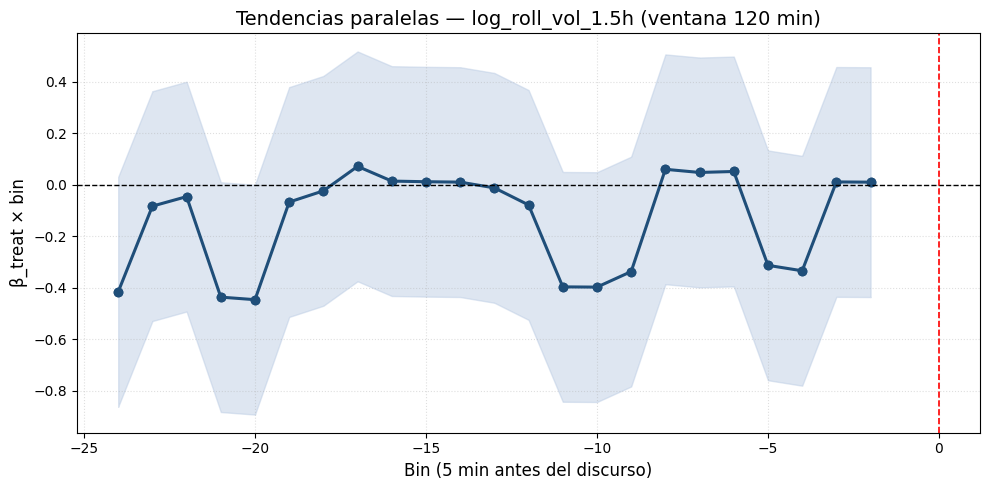


### log_roll_vol_2h ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-24]:treat[1] -0.140803 0.178625 -0.788261 0.430630  -24
C(bin_str)[T.-24]:treat[0] -0.140803 0.178625 -0.788261 0.430630  -24
C(bin_str)[T.-23]:treat[0] -0.085877 0.178625 -0.480765 0.630732  -23
C(bin_str)[T.-23]:treat[1] -0.085877 0.178625 -0.480765 0.630732  -23
C(bin_str)[T.-22]:treat[1] -0.103885 0.178625 -0.581581 0.560909  -22
C(bin_str)[T.-22]:treat[0] -0.103885 0.178625 -0.581581 0.560909  -22
C(bin_str)[T.-21]:treat[1] -0.122512 0.178625 -0.685860 0.492875  -21
C(bin_str)[T.-21]:treat[0] -0.122512 0.178625 -0.685860 0.492875  -21
C(bin_str)[T.-20]:treat[1] -0.089694 0.178625 -0.502135 0.615624  -20
C(bin_str)[T.-20]:treat[0] -0.089694 0.178625 -0.502135 0.615624  -20
C(bin_str)[T.-19]:treat[1] -0.084193 0.178625 -0.471337 0.637447  -19
C(bin_str)[T.-19]:treat[0] -0.084193 0.178625 -0.471337 0.637447  -19
C(bin_str)[T.-18]:treat[1] -0.107376 0.178625 -0.601126 0.547819 

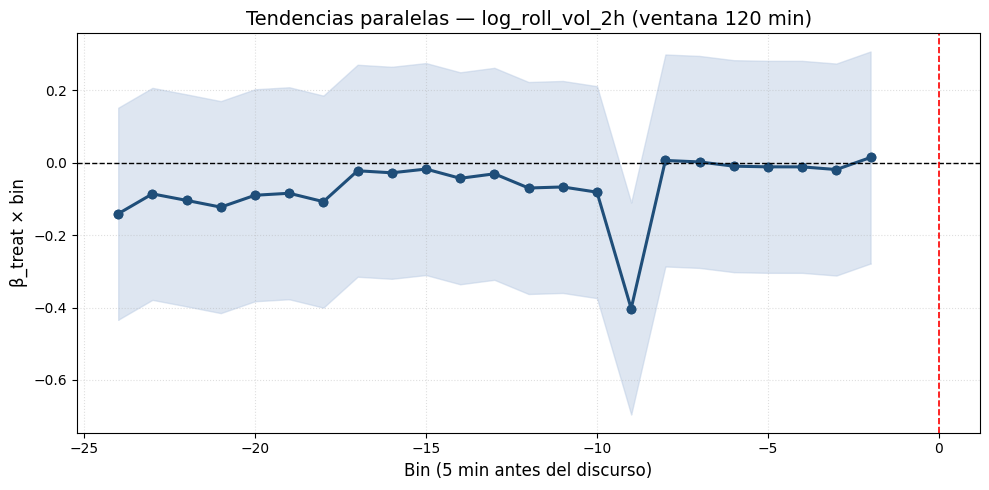


--- Controles COMPLETOS (treat + FE evento + FE símbolo) ---

### log_trades ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-24]:treat[1] -0.124189 0.138892 -0.894136 0.371348  -24
C(bin_str)[T.-24]:treat[0] -0.124189 0.138892 -0.894136 0.371348  -24
C(bin_str)[T.-23]:treat[0] -0.144041 0.138892 -1.037072 0.299818  -23
C(bin_str)[T.-23]:treat[1] -0.144041 0.138892 -1.037072 0.299818  -23
C(bin_str)[T.-22]:treat[1] -0.101932 0.138892 -0.733891 0.463095  -22
C(bin_str)[T.-22]:treat[0] -0.101932 0.138892 -0.733891 0.463095  -22
C(bin_str)[T.-21]:treat[1] -0.126765 0.138892 -0.912689 0.361508  -21
C(bin_str)[T.-21]:treat[0] -0.126765 0.138892 -0.912689 0.361508  -21
C(bin_str)[T.-20]:treat[1] -0.089503 0.138892 -0.644406 0.519381  -20
C(bin_str)[T.-20]:treat[0] -0.089503 0.138892 -0.644406 0.519381  -20
C(bin_str)[T.-19]:treat[1] -0.138529 0.138892 -0.997384 0.318690  -19
C(bin_str)[T.-19]:treat[0] -0.138529 0.138892 -0.997384 0.318690  -19
C(bin_st

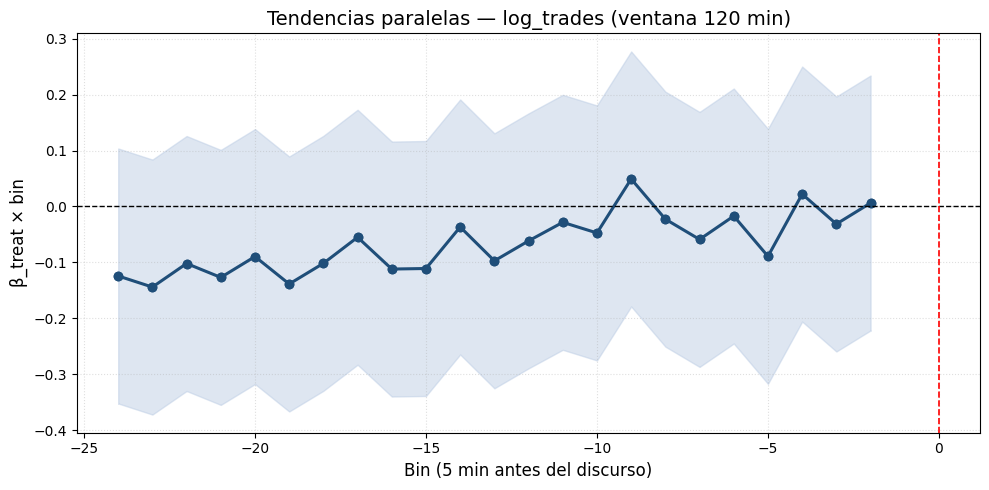


### log_quote_volume ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-24]:treat[1] -0.105307 0.317089 -0.332105 0.739842  -24
C(bin_str)[T.-24]:treat[0] -0.105307 0.317089 -0.332105 0.739842  -24
C(bin_str)[T.-23]:treat[0] -0.144530 0.317089 -0.455803 0.648577  -23
C(bin_str)[T.-23]:treat[1] -0.144530 0.317089 -0.455803 0.648577  -23
C(bin_str)[T.-22]:treat[1] -0.038886 0.317089 -0.122633 0.902409  -22
C(bin_str)[T.-22]:treat[0] -0.038886 0.317089 -0.122633 0.902409  -22
C(bin_str)[T.-21]:treat[1] -0.074468 0.317089 -0.234848 0.814349  -21
C(bin_str)[T.-21]:treat[0] -0.074468 0.317089 -0.234848 0.814349  -21
C(bin_str)[T.-20]:treat[1] -0.058364 0.317089 -0.184062 0.853982  -20
C(bin_str)[T.-20]:treat[0] -0.058364 0.317089 -0.184062 0.853982  -20
C(bin_str)[T.-19]:treat[1] -0.193296 0.317089 -0.609594 0.542194  -19
C(bin_str)[T.-19]:treat[0] -0.193296 0.317089 -0.609594 0.542194  -19
C(bin_str)[T.-18]:treat[1] -0.066729 0.317089 -0.210442 0.833343

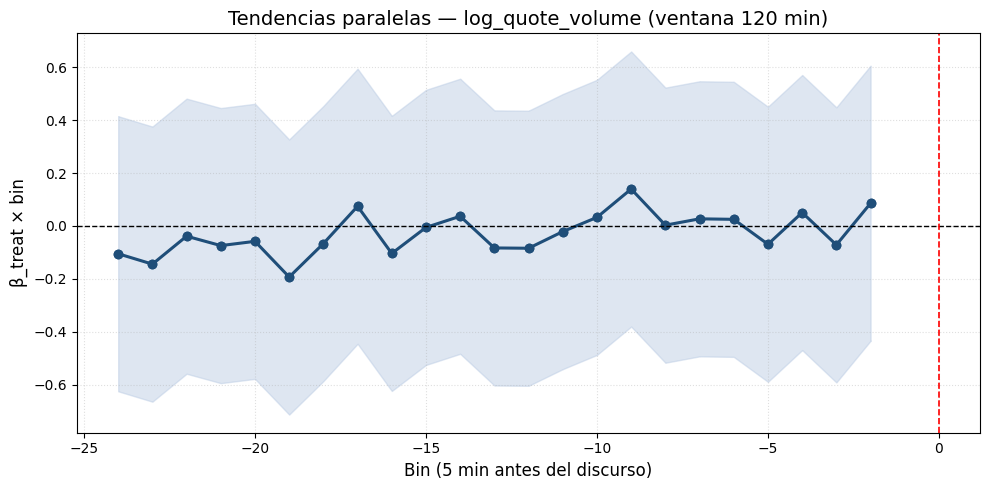


### log_roll_vol_1h ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-24]:treat[1] -0.179925 0.380202 -0.473236 0.636093  -24
C(bin_str)[T.-24]:treat[0] -0.179925 0.380202 -0.473236 0.636093  -24
C(bin_str)[T.-23]:treat[0] -0.240029 0.380202 -0.631321 0.527897  -23
C(bin_str)[T.-23]:treat[1] -0.240029 0.380202 -0.631321 0.527897  -23
C(bin_str)[T.-22]:treat[1] -0.256637 0.380202 -0.675002 0.499746  -22
C(bin_str)[T.-22]:treat[0] -0.256637 0.380202 -0.675002 0.499746  -22
C(bin_str)[T.-21]:treat[1] -0.278786 0.380202 -0.733259 0.463480  -21
C(bin_str)[T.-21]:treat[0] -0.278786 0.380202 -0.733259 0.463480  -21
C(bin_str)[T.-20]:treat[1] -0.183493 0.380202 -0.482621 0.629414  -20
C(bin_str)[T.-20]:treat[0] -0.183493 0.380202 -0.482621 0.629414  -20
C(bin_str)[T.-19]:treat[1]  0.176300 0.380202  0.463700 0.642909  -19
C(bin_str)[T.-19]:treat[0]  0.176300 0.380202  0.463700 0.642909  -19
C(bin_str)[T.-18]:treat[1]  0.178769 0.380202  0.470194 0.638264 

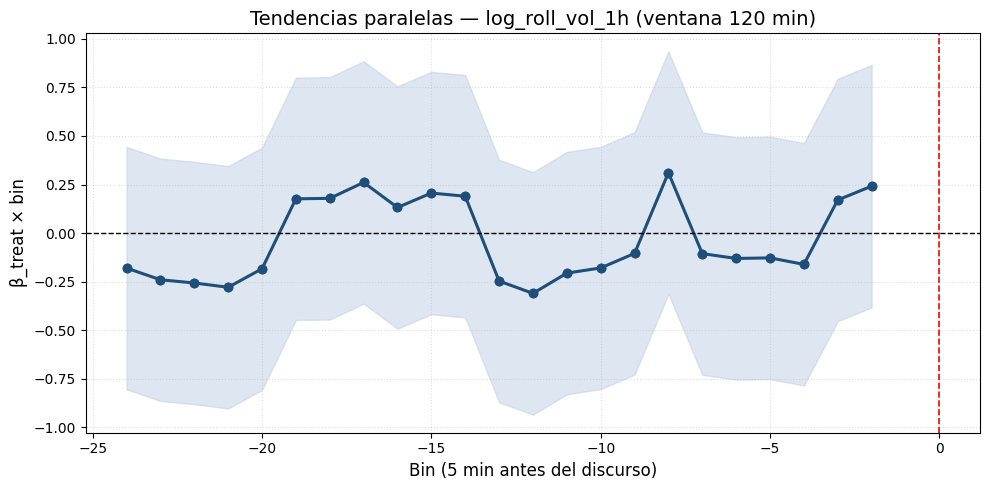


### log_roll_vol_1.5h ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-24]:treat[1] -0.415524 0.243435 -1.706921 0.087980  -24
C(bin_str)[T.-24]:treat[0] -0.415524 0.243435 -1.706921 0.087980  -24
C(bin_str)[T.-23]:treat[0] -0.082712 0.243435 -0.339770 0.734063  -23
C(bin_str)[T.-23]:treat[1] -0.082712 0.243435 -0.339770 0.734063  -23
C(bin_str)[T.-22]:treat[1] -0.045764 0.243435 -0.187992 0.850901  -22
C(bin_str)[T.-22]:treat[0] -0.045764 0.243435 -0.187992 0.850901  -22
C(bin_str)[T.-21]:treat[1] -0.436201 0.243435 -1.791860 0.073295  -21
C(bin_str)[T.-21]:treat[0] -0.436201 0.243435 -1.791860 0.073295  -21
C(bin_str)[T.-20]:treat[1] -0.446104 0.243435 -1.832538 0.067009  -20
C(bin_str)[T.-20]:treat[0] -0.446104 0.243435 -1.832538 0.067009  -20
C(bin_str)[T.-19]:treat[1] -0.066800 0.243435 -0.274404 0.783800  -19
C(bin_str)[T.-19]:treat[0] -0.066800 0.243435 -0.274404 0.783800  -19
C(bin_str)[T.-18]:treat[1] -0.023361 0.243435 -0.095966 0.92355

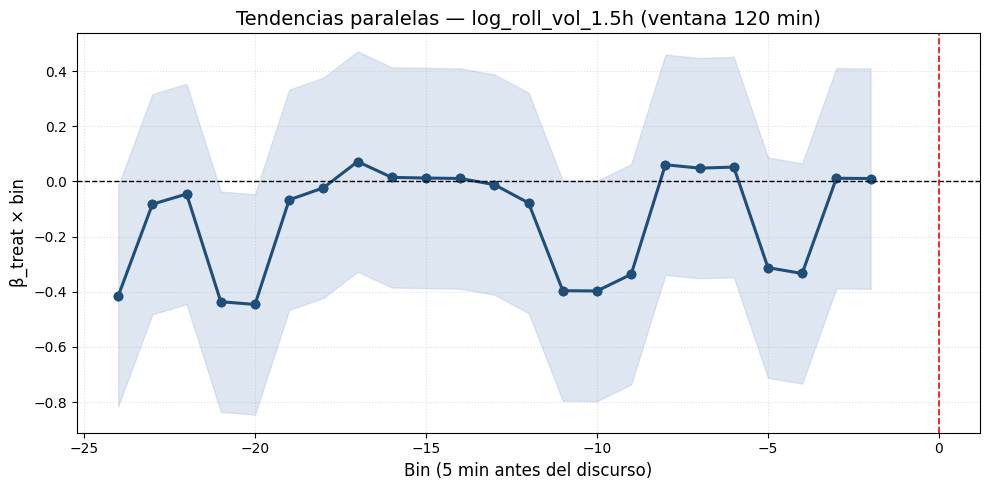


### log_roll_vol_2h ###
                 coef_name      coef       se         t        p  bin
C(bin_str)[T.-24]:treat[1] -0.140803 0.133593 -1.053973 0.292013  -24
C(bin_str)[T.-24]:treat[0] -0.140803 0.133593 -1.053973 0.292013  -24
C(bin_str)[T.-23]:treat[0] -0.085877 0.133593 -0.642824 0.520406  -23
C(bin_str)[T.-23]:treat[1] -0.085877 0.133593 -0.642824 0.520406  -23
C(bin_str)[T.-22]:treat[1] -0.103885 0.133593 -0.777624 0.436876  -22
C(bin_str)[T.-22]:treat[0] -0.103885 0.133593 -0.777624 0.436876  -22
C(bin_str)[T.-21]:treat[1] -0.122512 0.133593 -0.917053 0.359217  -21
C(bin_str)[T.-21]:treat[0] -0.122512 0.133593 -0.917053 0.359217  -21
C(bin_str)[T.-20]:treat[1] -0.089694 0.133593 -0.671397 0.502039  -20
C(bin_str)[T.-20]:treat[0] -0.089694 0.133593 -0.671397 0.502039  -20
C(bin_str)[T.-19]:treat[1] -0.084193 0.133593 -0.630218 0.528618  -19
C(bin_str)[T.-19]:treat[0] -0.084193 0.133593 -0.630218 0.528618  -19
C(bin_str)[T.-18]:treat[1] -0.107376 0.133593 -0.803757 0.421625 

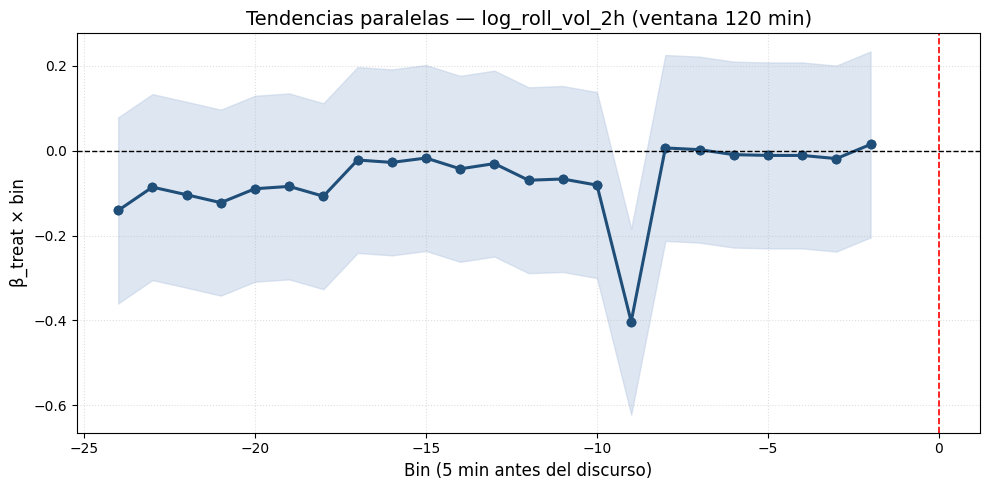

In [ ]:

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# =====================================================
# 1. Cargar PANEL 
# =====================================================

try:
    panel
except NameError:
    PANEL_PATH = "PANEL_MULTIPAR_USDT_5m.xlsx"
    panel = pd.read_excel(PANEL_PATH, sheet_name="panel_5m", parse_dates=["time_local"])

panel = panel.copy()
panel["t_min"] = pd.to_numeric(panel["t_min"], errors="coerce")
panel = panel.dropna(subset=["t_min"])

EPS = 1e-8

# Logs
panel["log_trades"]        = np.log1p(panel["number_of_trades"].astype(float))
panel["log_quote_volume"]  = np.log1p(panel["quote_asset_volume"].astype(float))
panel["log_roll_vol_1h"]   = np.log(panel["roll_vol_1h"].astype(float) + EPS)
panel["log_roll_vol_1.5h"] = np.log(panel["roll_vol_1.5h"].astype(float) + EPS)
panel["log_roll_vol_2h"]   = np.log(panel["roll_vol_2h"].astype(float) + EPS)



TREATED = "USDTARS"

CONTROLS_BASE = ["treat"]                   # treat + FE evento
CONTROLS_PLUS = ["treat", "C(symbol)"]      # treat + FE evento + FE símbolo

METRICS = [
    "log_trades",
    "log_quote_volume",
    "log_roll_vol_1h",
    "log_roll_vol_1.5h",
    "log_roll_vol_2h"
]

def build_parallel_data(df, controls, W):

    d = df.copy()
    d = d[(d["t_min"] >= -W) & (d["t_min"] <= -1)]

    d["treat"] = (d["symbol"] == TREATED).astype(int)

    # bin temporal (en unidades de 5 minutos)
    d["bin"] = (d["t_min"] // 5).astype(int)
    d["bin_str"] = d["bin"].astype(str)

    cleaned_controls = [c for c in controls if c != "C(symbol)"]

    COLS = ["event", "symbol", "treat", "bin", "bin_str"] + METRICS + cleaned_controls
    return d[COLS].dropna()


# 4. Regresión de tendencias paralelas


def parallel_regression(dW, metric, controls):

    rhs = " + ".join(controls + ["C(bin_str):treat", "C(event)"])
    formula = f'Q("{metric}") ~ {rhs}'
    model = smf.ols(formula, data=dW).fit()

    keep = [c for c in model.params.index if "C(bin_str)" in c]

    out = pd.DataFrame({
        "coef_name": keep,
        "coef": model.params[keep].values,
        "se": model.bse[keep].values,
        "t": model.tvalues[keep].values,
        "p": model.pvalues[keep].values
    })

    def parse_bin(name):
        try:
            return int(name.split("[T.")[1].split("]")[0])
        except:
            return np.nan

    out["bin"] = out["coef_name"].apply(parse_bin)
    out = out.sort_values("bin")

    return out, model




def coefplot_parallel(out, metric="", window=60):

    df = out.dropna(subset=["bin"]).sort_values("bin").copy()

    bins = df["bin"]
    coef = df["coef"]
    se   = df["se"]

    z = 1.64
    upper = coef + z * se
    lower = coef - z * se

    plt.figure(figsize=(10,5))

    plt.fill_between(bins, lower, upper,
                     color="#b7c9e2", alpha=0.45, label="IC 90%")

    plt.plot(bins, coef, color="#1f4e79", linewidth=2.2, marker="o")

    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.axvline(0, color="red", linestyle="--", linewidth=1.2)

    plt.title(f"Tendencias paralelas — {metric} (ventana {window} min)", fontsize=14)
    plt.xlabel("Bin (5 min antes del discurso)", fontsize=12)
    plt.ylabel("β_treat × bin", fontsize=12)
    plt.grid(True, linestyle=":", alpha=0.4)
    plt.tight_layout()
    plt.show()


# =====================================================
# 6. Ejecutar tests + plots para todas las ventanas
# =====================================================

def run_parallel_tests(panel, windows=[60, 90, 120]):

    for W in windows:

        print("\n" + "="*80)
        print(f"=== TEST DE TENDENCIAS PARALELAS — VENTANA {W} min ===")
        print("="*80)

        print("\n--- Controles BASE (treat + FE evento) ---")
        dW = build_parallel_data(panel, CONTROLS_BASE, W)

        for metric in METRICS:
            out, model = parallel_regression(dW, metric, CONTROLS_BASE)
            print(f"\n### {metric} ###")
            print(out.to_string(index=False))
            coefplot_parallel(out, metric=metric, window=W)

        print("\n--- Controles COMPLETOS (treat + FE evento + FE símbolo) ---")
        dW2 = build_parallel_data(panel, CONTROLS_PLUS, W)

        for metric in METRICS:
            out, model = parallel_regression(dW2, metric, CONTROLS_PLUS)
            print(f"\n### {metric} ###")
            print(out.to_string(index=False))
            coefplot_parallel(out, metric=metric, window=W)


run_parallel_tests(panel, windows=[60, 90, 120])


### DiD


=== TWFE DiD Results ===
           metric  coef_post_treat  approx_pct      p_value       se
       log_trades         0.200412    0.221906 3.723770e-07 0.039411
 log_quote_volume         0.280522    0.323820 4.276902e-04 0.079620
  log_roll_vol_1h         0.378706    0.460394 1.673469e-04 0.100588
log_roll_vol_1.5h         0.250101    0.284155 1.037235e-04 0.064410


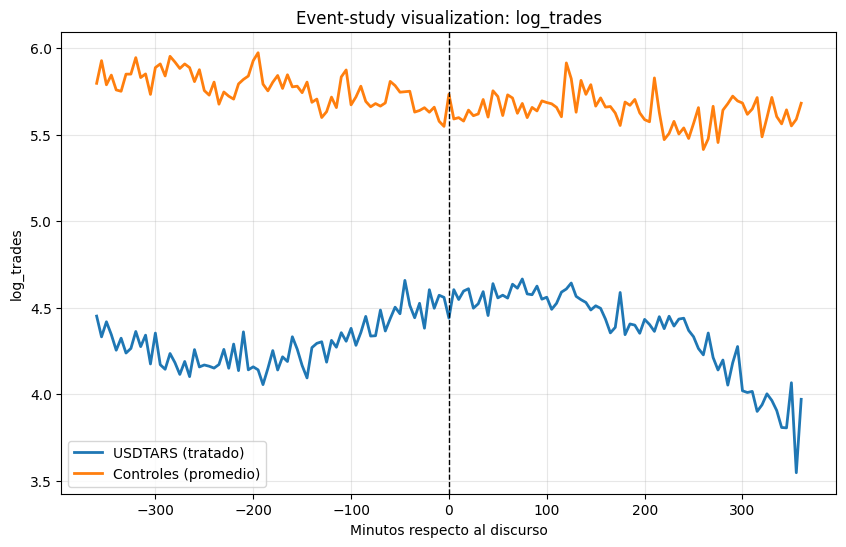

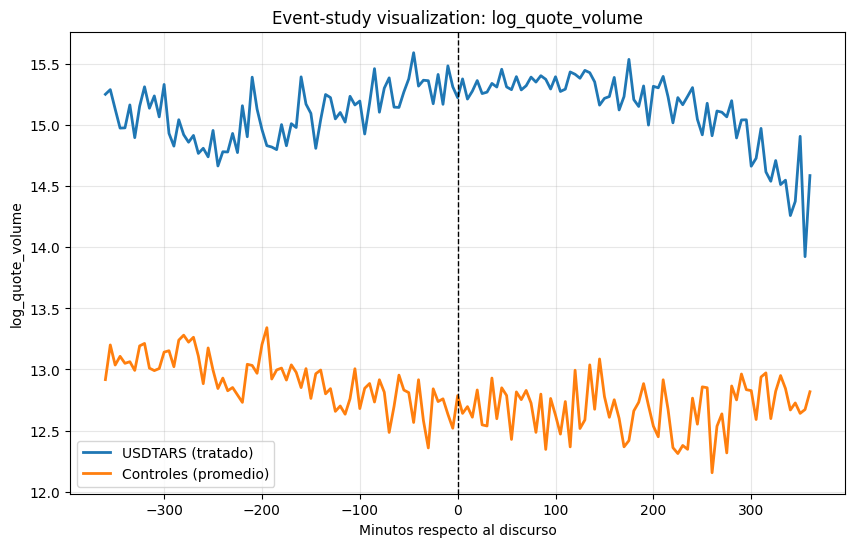

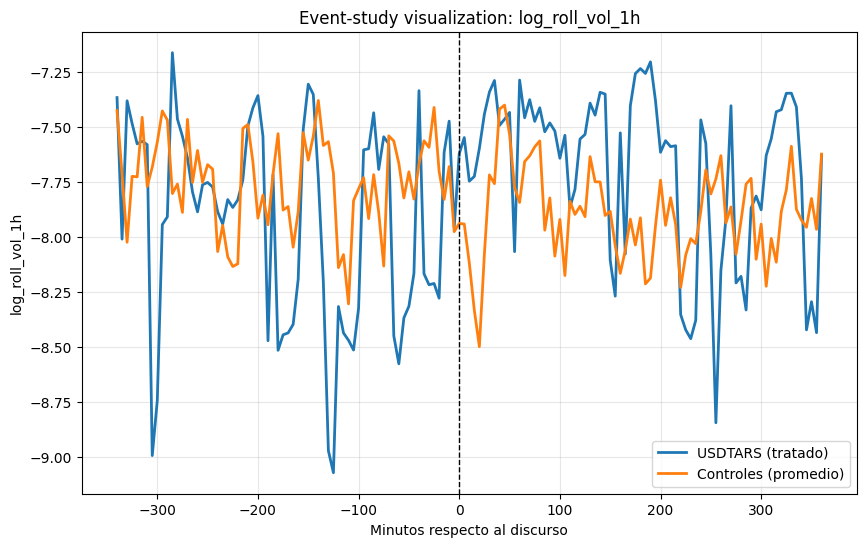

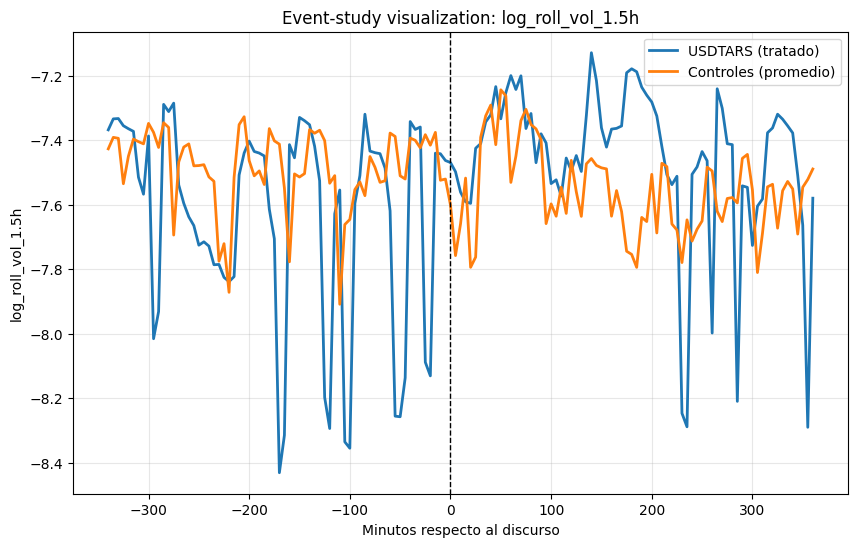

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

EPS = 1e-8
TREATED = "USDTARS"


d = panel.copy()
d = d[d["symbol"].isin(panel["symbol"].unique())]

# post dummy según t_min
d["post"] = (d["t_min"] >= 0).astype(int)
d["treat"] = (d["symbol"] == TREATED).astype(int)

# logs
d["log_trades"]       = np.log1p(d["number_of_trades"])
d["log_quote_volume"] = np.log1p(d["quote_asset_volume"])
d["log_roll_vol_1h"]  = np.log(d["roll_vol_1h"] + EPS)
d["log_roll_vol_1.5h"] = np.log(d["roll_vol_1.5h"] + EPS)

METRICS = ["log_trades", "log_quote_volume", "log_roll_vol_1h", "log_roll_vol_1.5h"]

# -----------------------------------------------------
# 2) Estimación DiD TWFE

results = []
for m in METRICS:
    
    model = smf.ols(
        f'Q("{m}") ~ post*treat + C(event) + C(symbol)',
        data=d
    ).fit()
    
    beta = model.params["post:treat"]
    results.append({
        "metric": m,
        "coef_post_treat": beta,
        "approx_pct": np.expm1(beta),
        "p_value": model.pvalues["post:treat"],
        "se": model.bse["post:treat"]
    })

res_df = pd.DataFrame(results)
print("\n=== TWFE DiD Results ===")
print(res_df.to_string(index=False))


def plot_event_study(metric):

    df = d[d["symbol"].isin([TREATED] + list(panel["symbol"].unique()))]

    treated = df[df["symbol"] == TREATED].groupby("t_min")[metric].mean()
    control = df[df["symbol"] != TREATED].groupby("t_min")[metric].mean()

    plt.figure(figsize=(10,6))
    plt.plot(treated.index, treated.values, label="USDTARS (tratado)", linewidth=2)
    plt.plot(control.index, control.values, label="Controles (promedio)", linewidth=2)
    
    plt.axvline(0, color="black", linestyle="--", linewidth=1)
    
    plt.title(f"Event-study visualization: {metric}")
    plt.xlabel("Minutos respecto al discurso")
    plt.ylabel(f"{metric}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


for m in METRICS:
    plot_event_study(m)


# SC DiD


=== PROCESANDO EVENTOS ===

>>> EVENTO: Caputo_BCRA_28jun


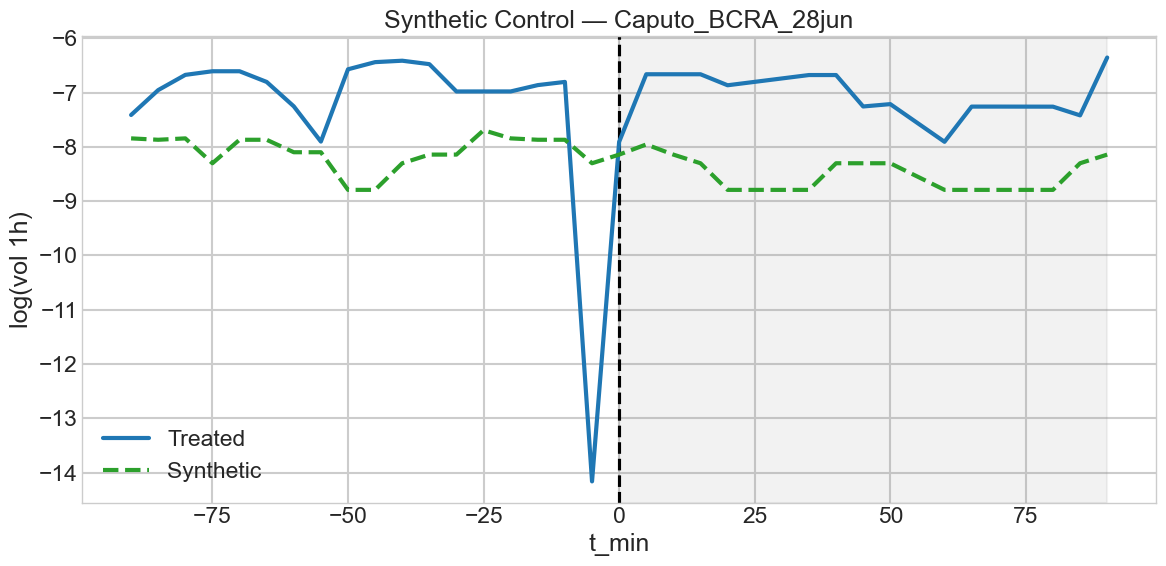

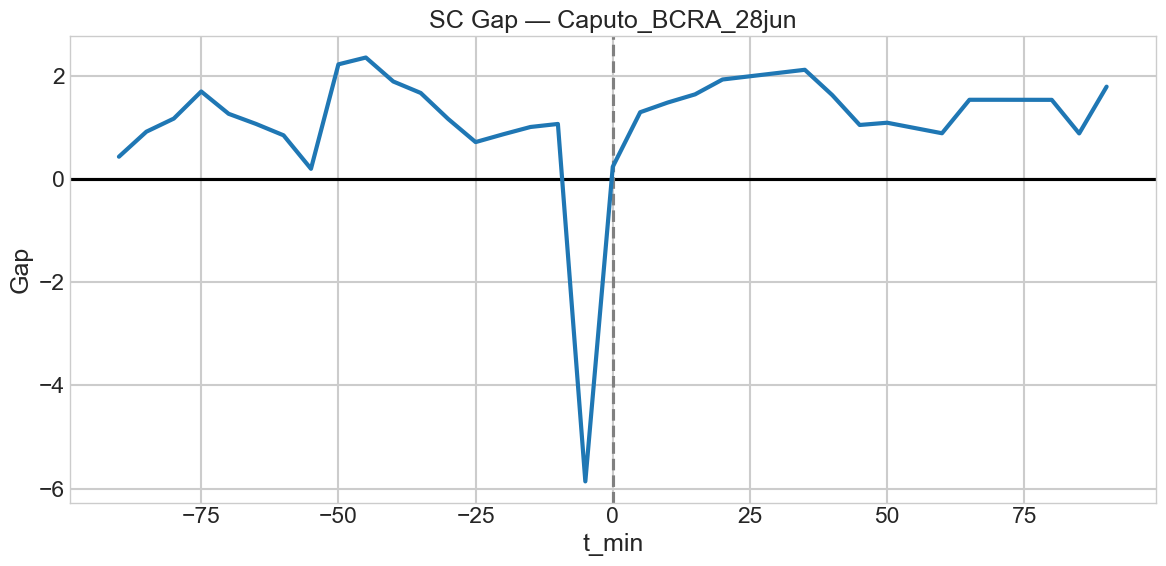


>>> EVENTO: Caputo_Cereales


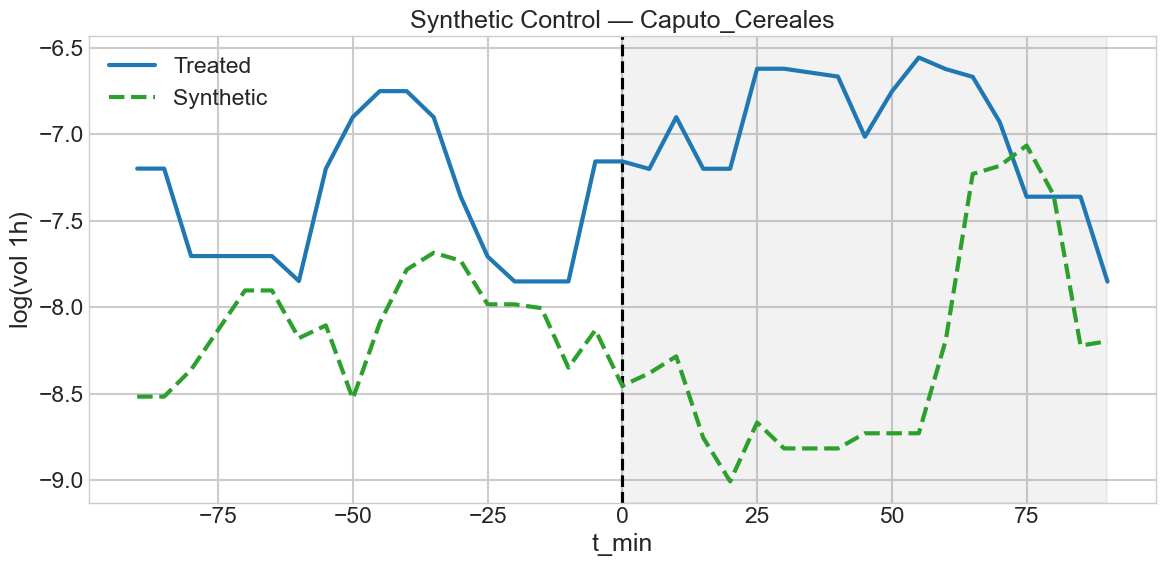

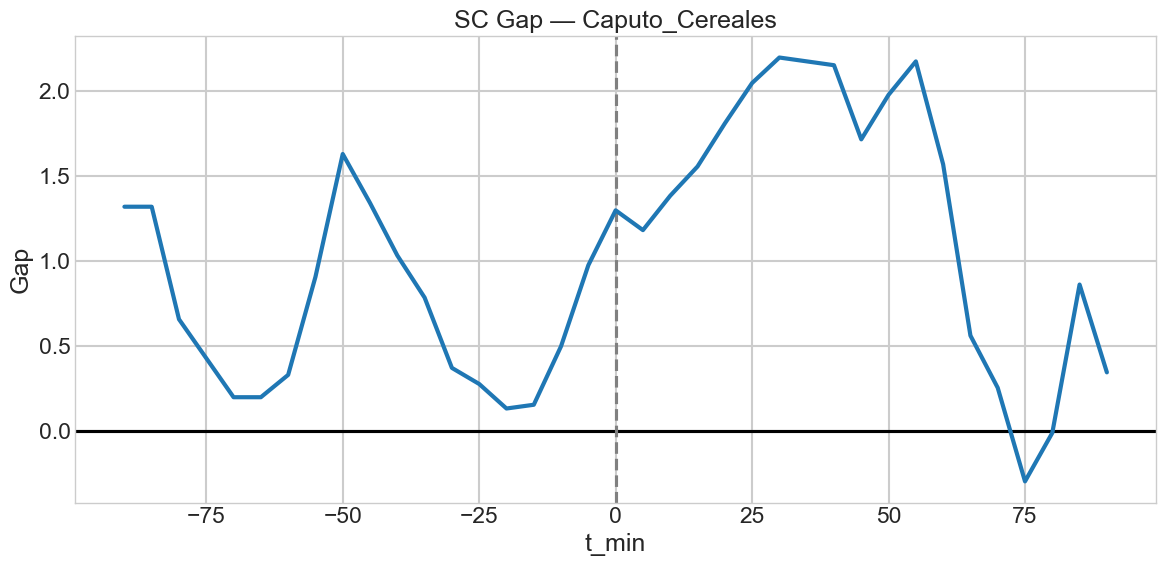


>>> EVENTO: Caputo_Conf_26ene


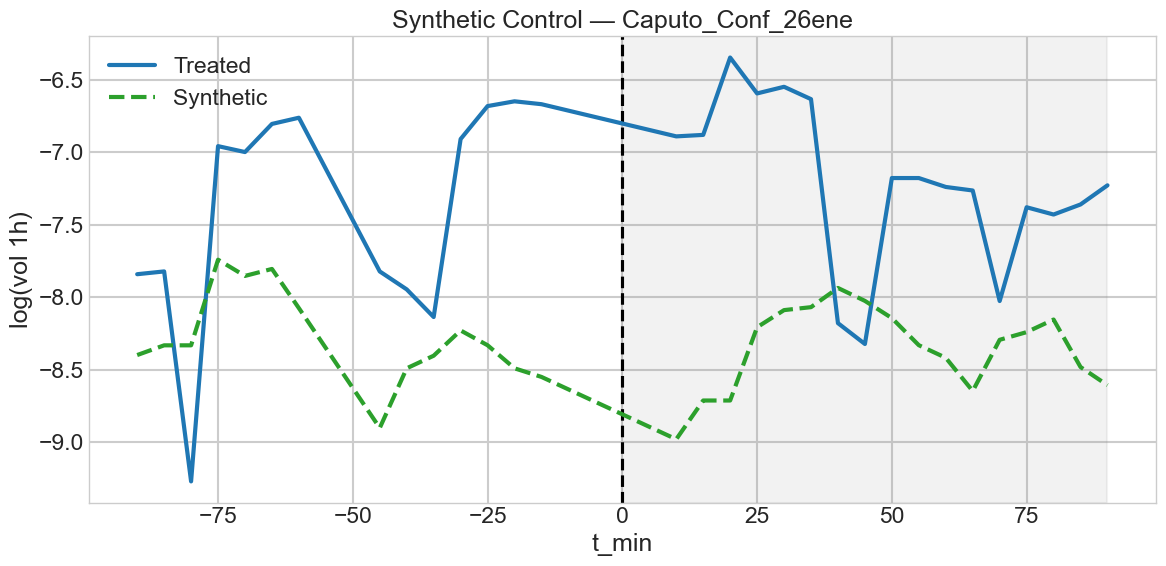

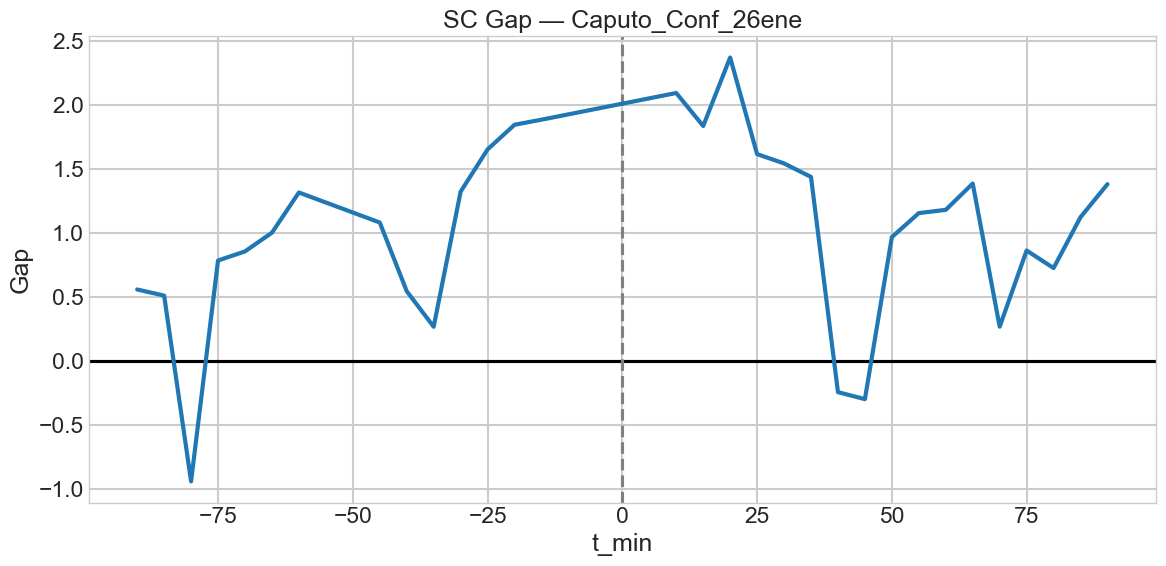


>>> EVENTO: Caputo_Conf_BCRA


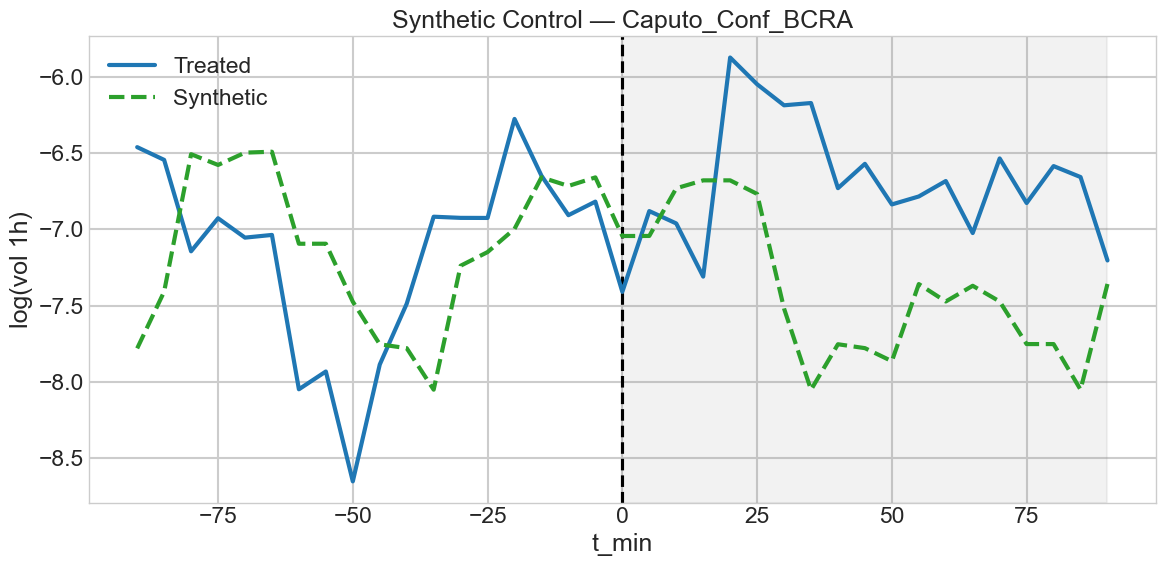

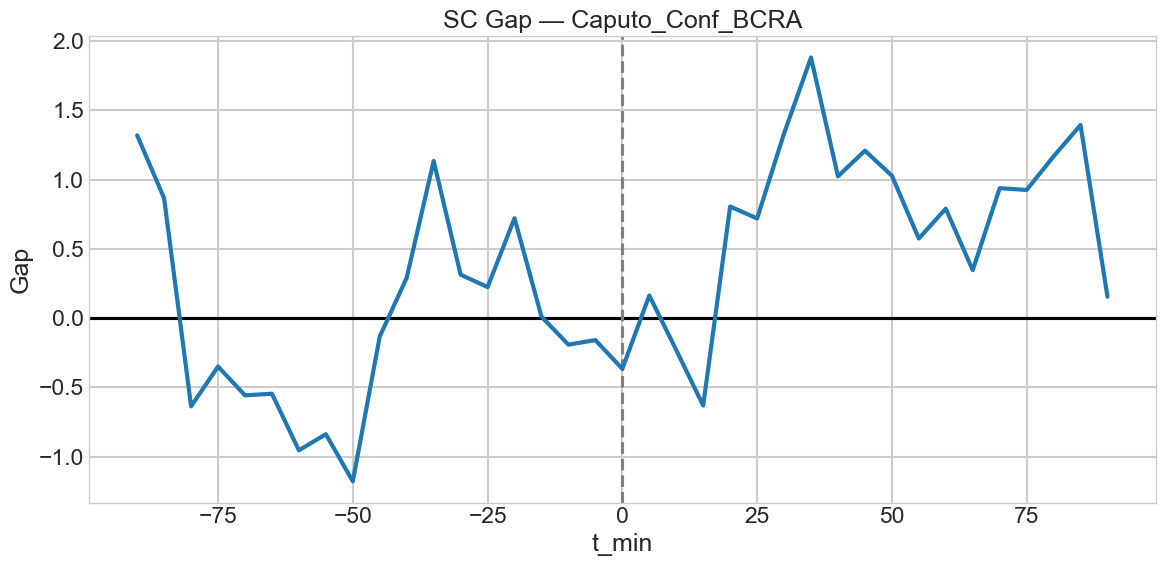


>>> EVENTO: Caputo_Feinmann1


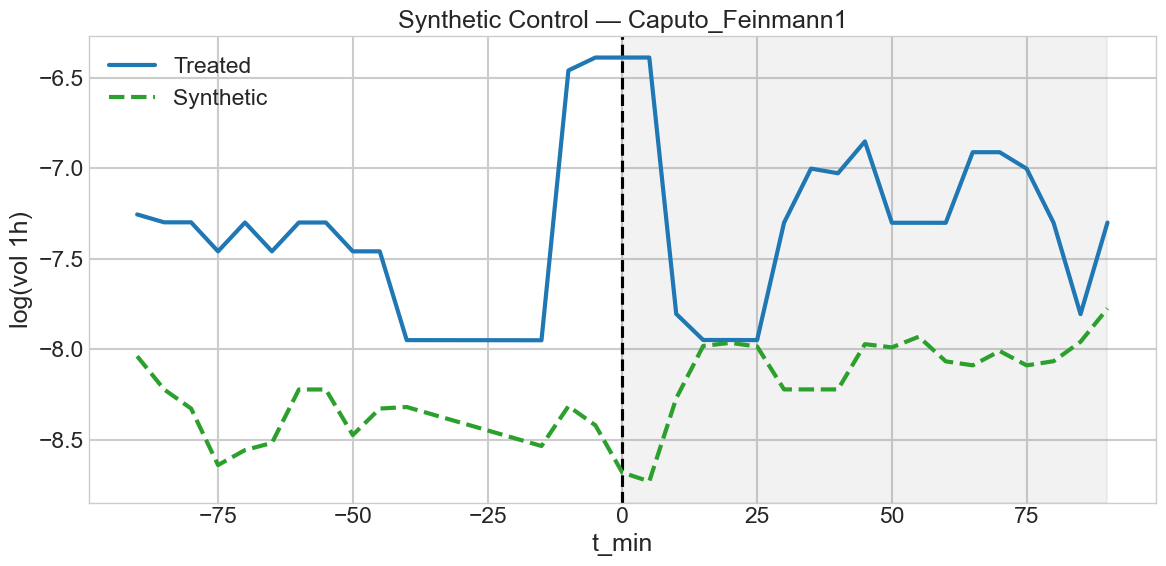

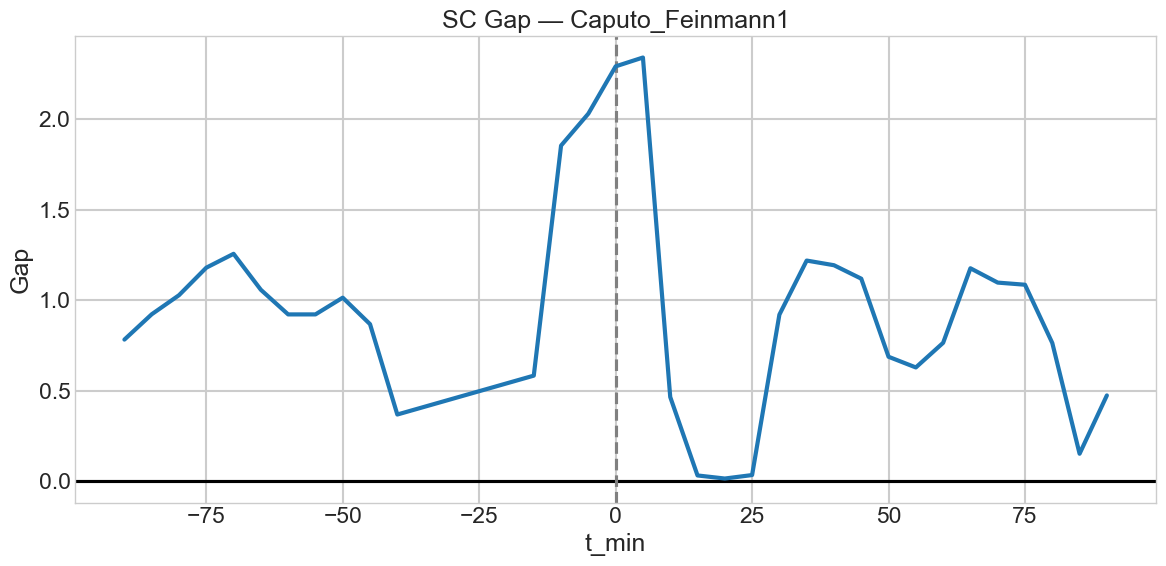


>>> EVENTO: Caputo_Feinmann2


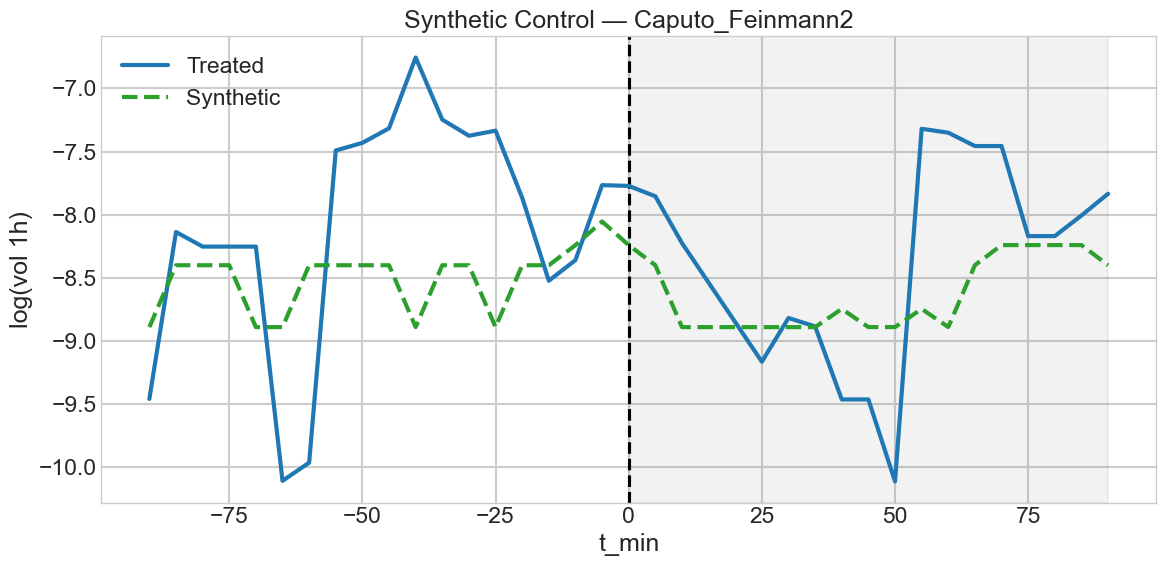

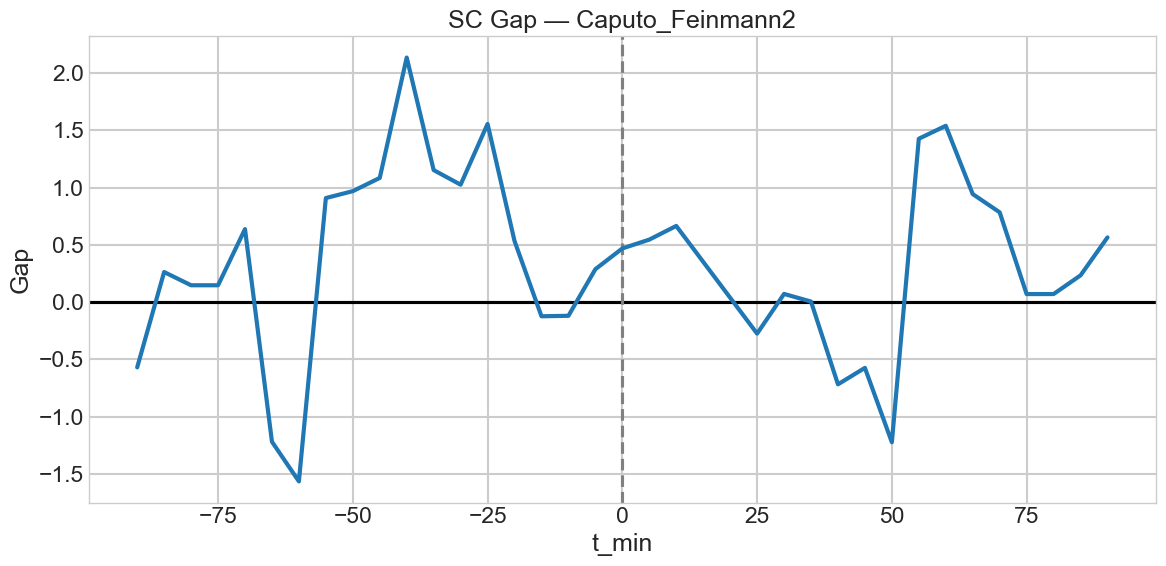


>>> EVENTO: Caputo_Laje1


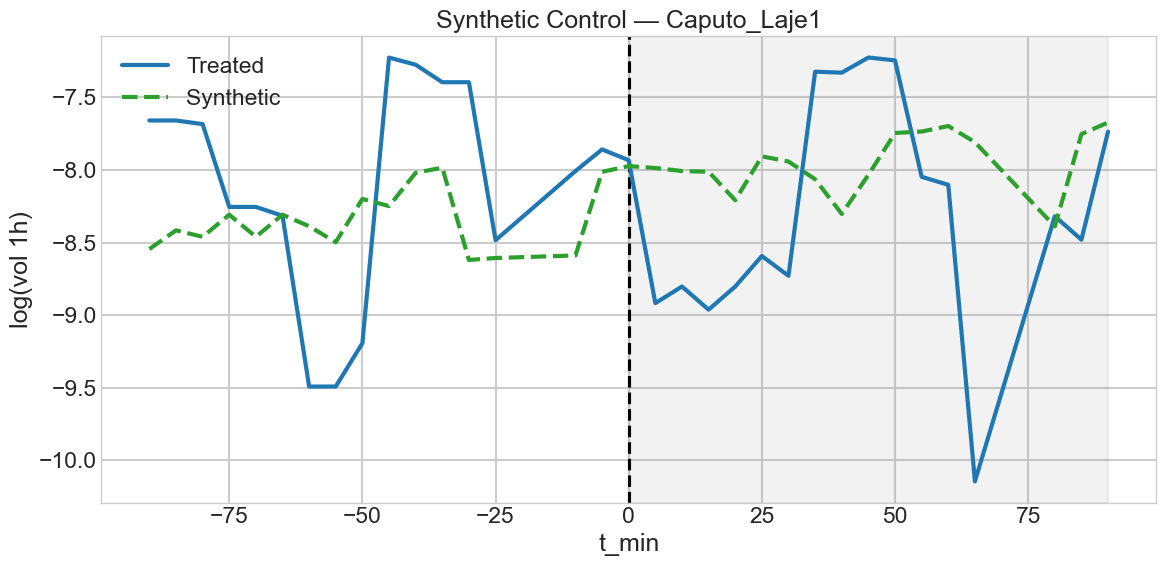

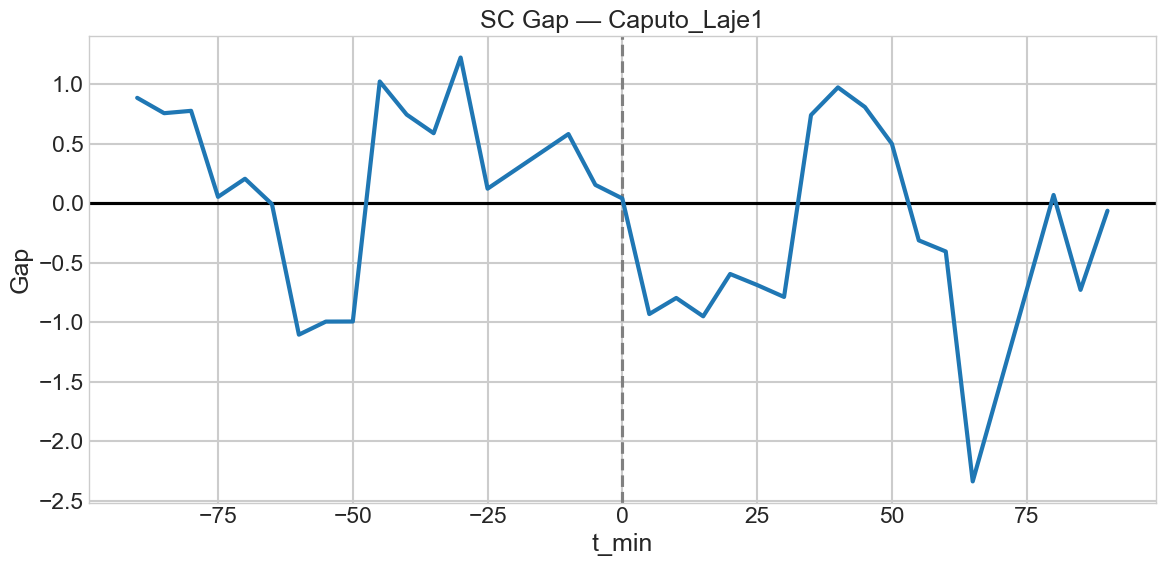


>>> EVENTO: Caputo_Laje2


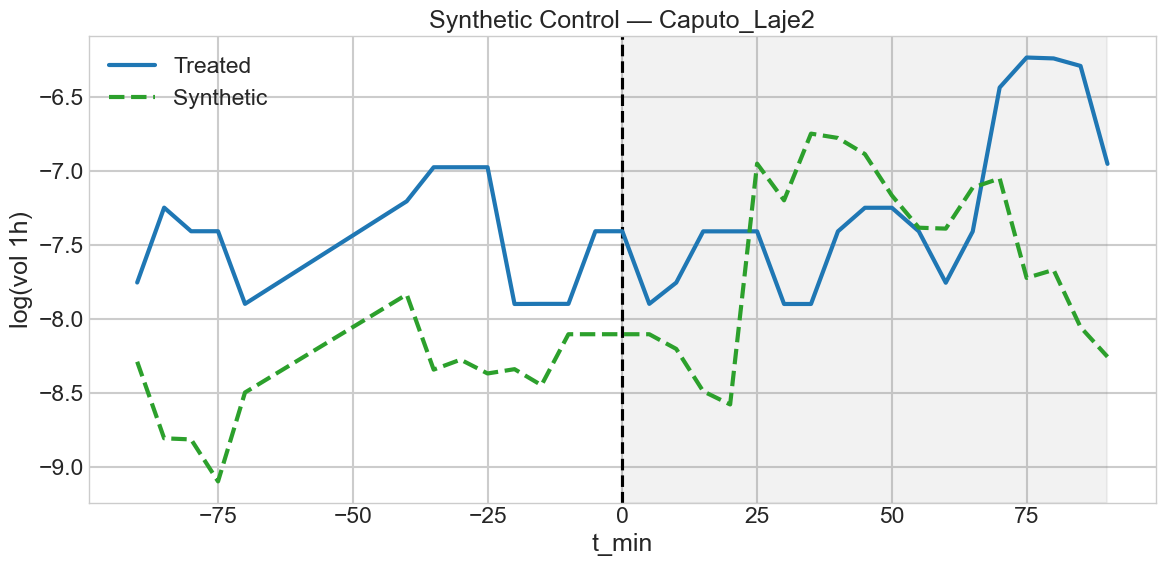

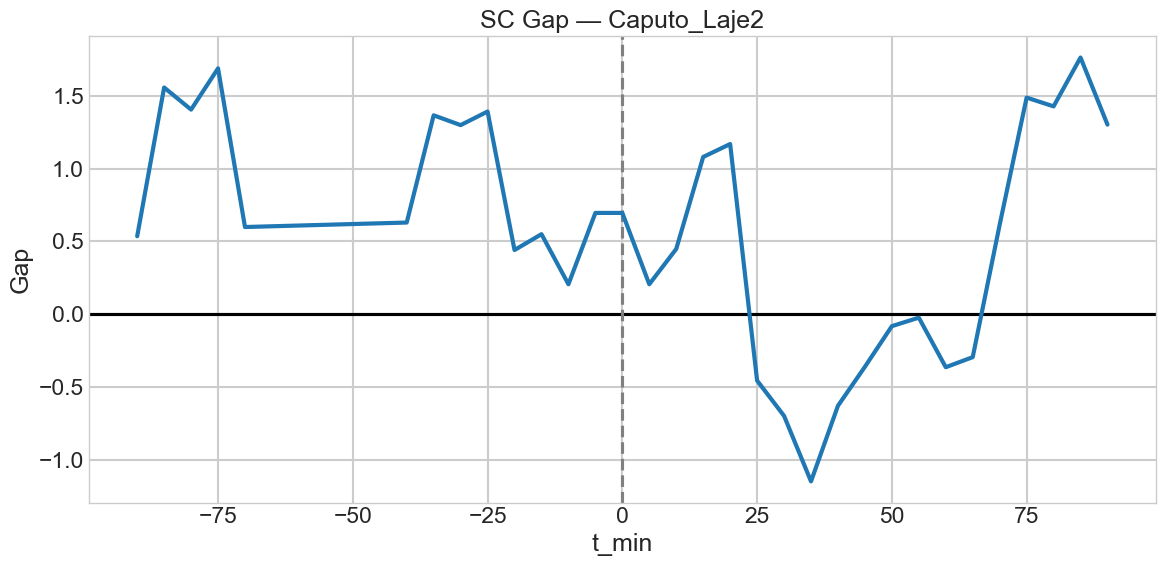


>>> EVENTO: Caputo_Majul1


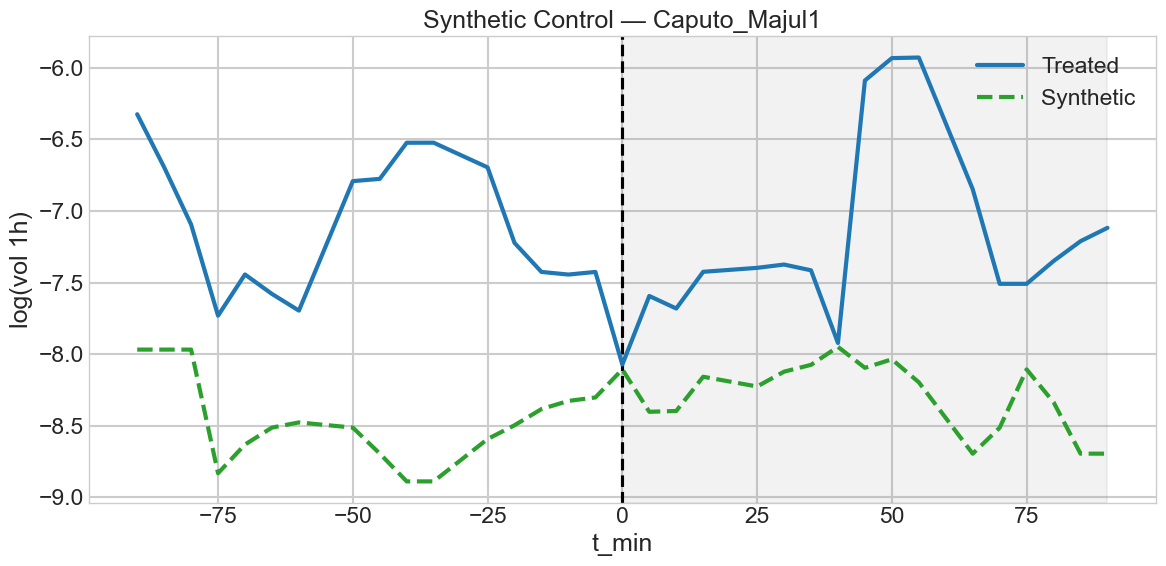

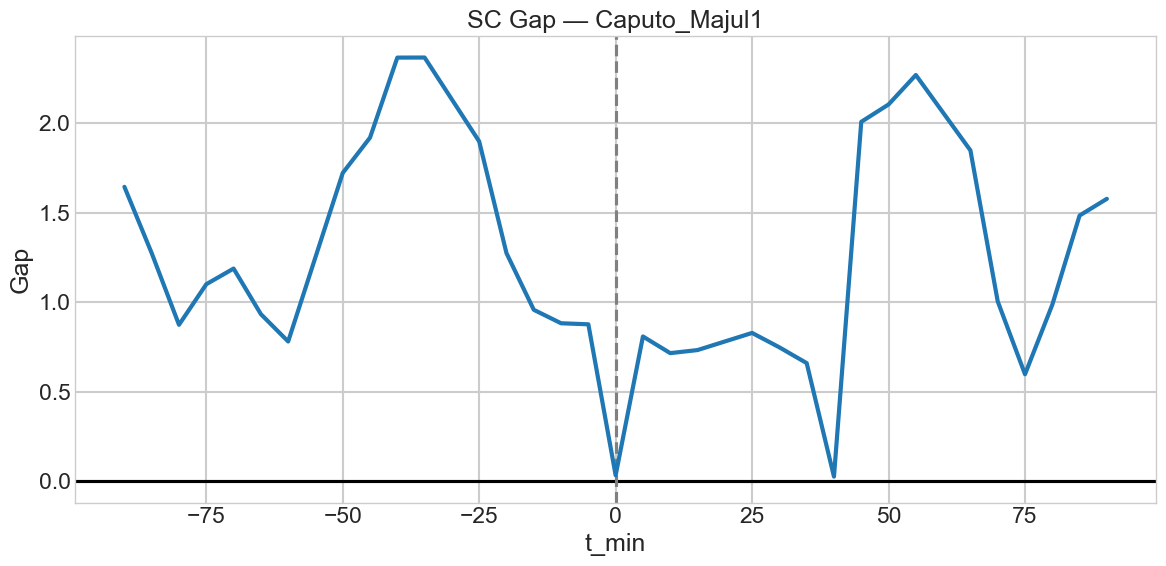


>>> EVENTO: Caputo_Majul2


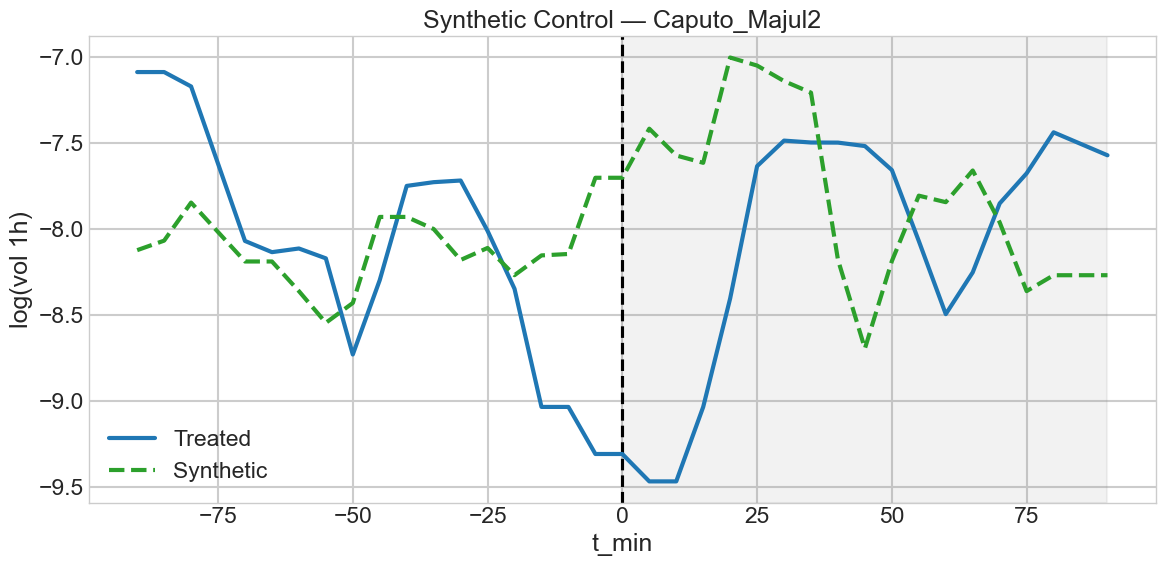

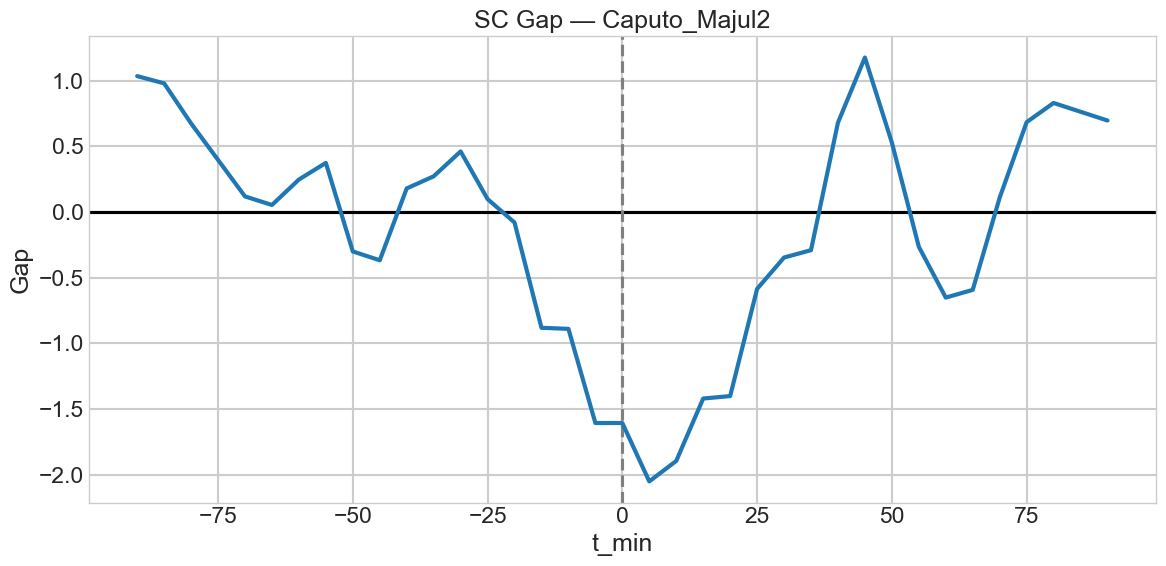


>>> EVENTO: Caputo_Majul3


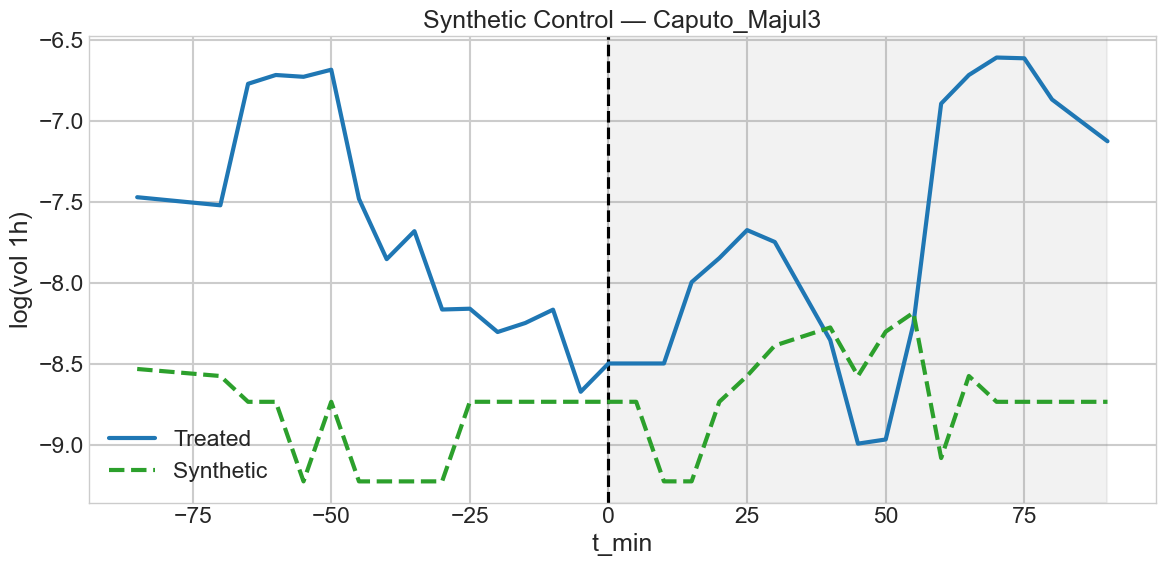

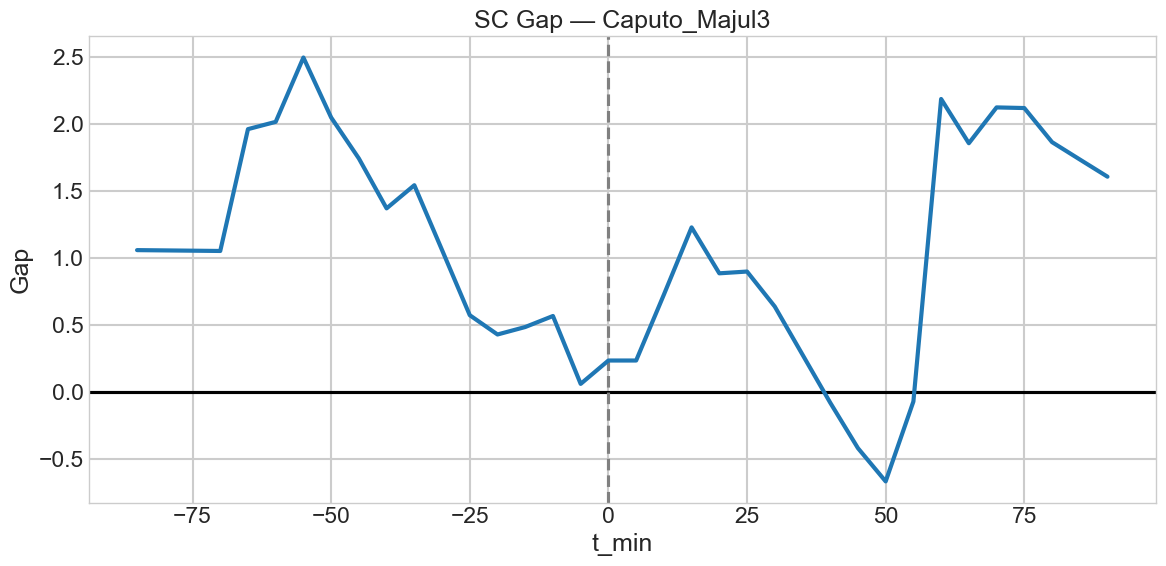


>>> EVENTO: Caputo_Majul4


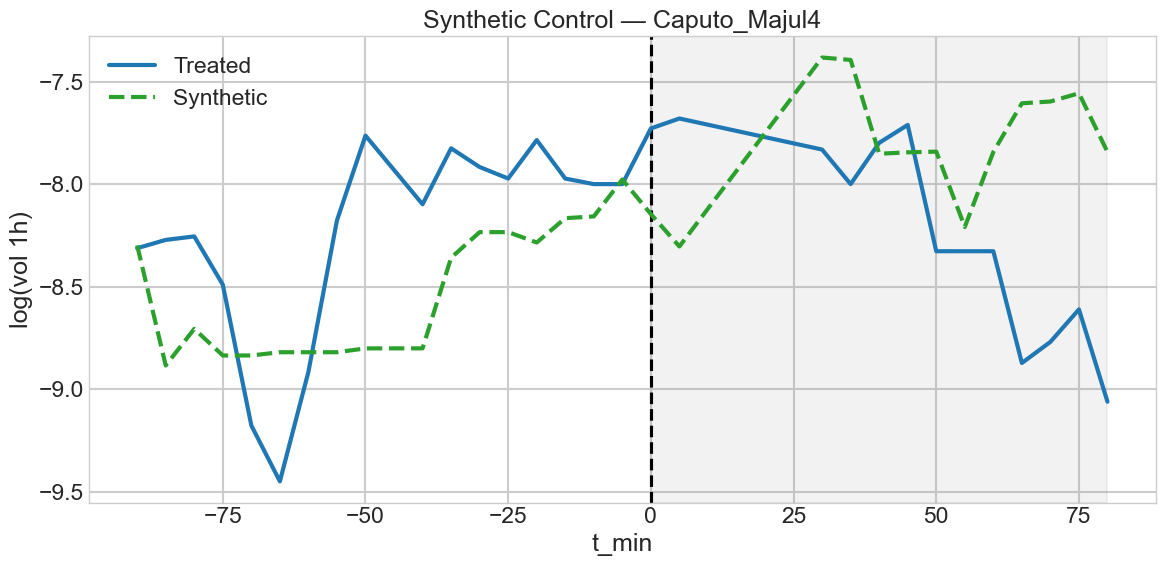

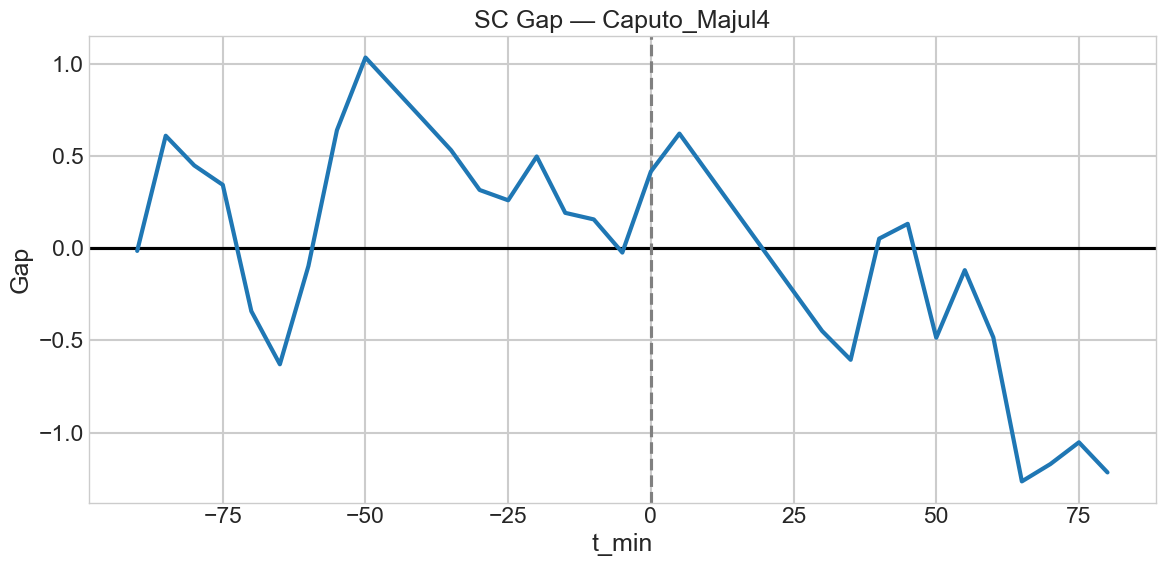


>>> EVENTO: Caputo_RadioMitre


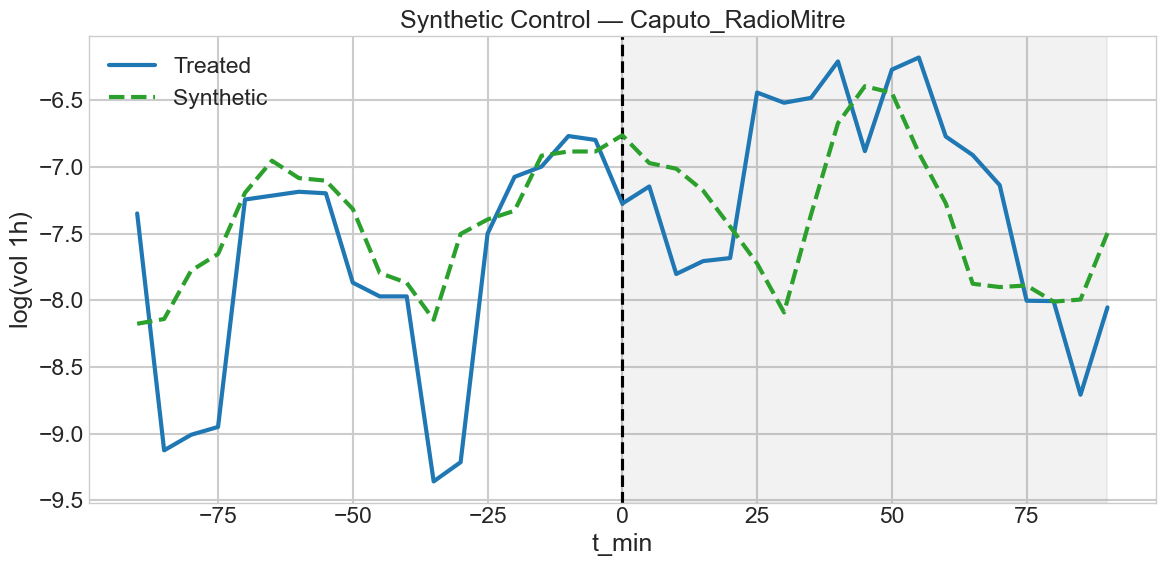

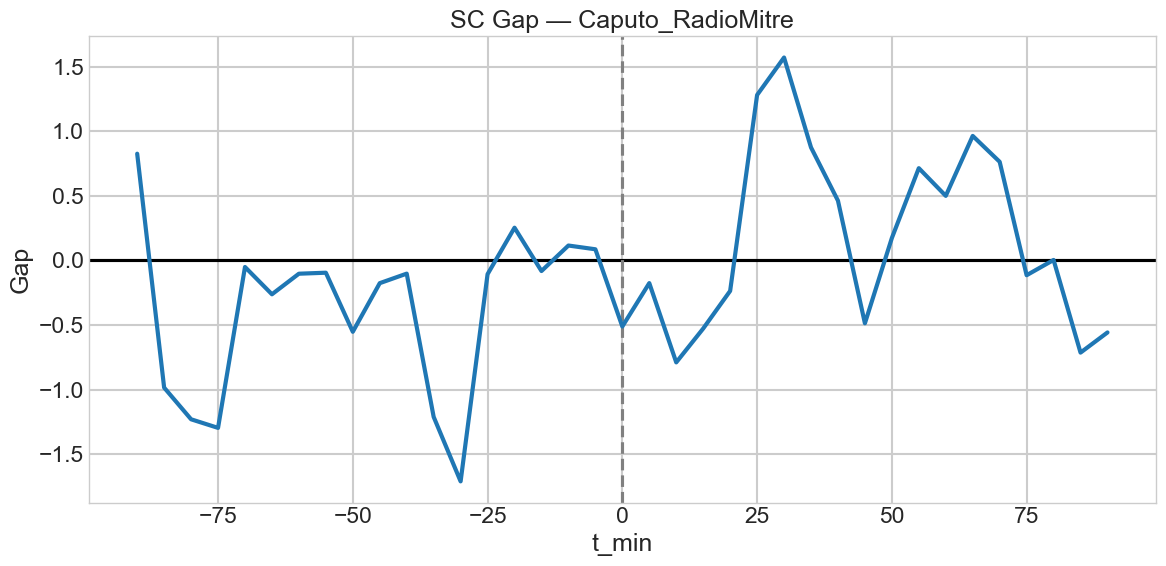


EVENTOS PROCESADOS CON ÉXITO:
['Caputo_BCRA_28jun', 'Caputo_Cereales', 'Caputo_Conf_26ene', 'Caputo_Conf_BCRA', 'Caputo_Feinmann1', 'Caputo_Feinmann2', 'Caputo_Laje1', 'Caputo_Laje2', 'Caputo_Majul1', 'Caputo_Majul2', 'Caputo_Majul3', 'Caputo_Majul4', 'Caputo_RadioMitre']


In [1]:
# ============================================
# CONTROL SINTÉTICO POR EVENTO — VERSIÓN ROBUSTA
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import lstsq

sns.set_context("talk")
plt.style.use("seaborn-v0_8-whitegrid")

# ============================================
# 1. PARÁMETROS
# ============================================

PANEL_PATH = "PANEL_MULTIPAR_USDT_5m.xlsx"

TREATED = "USDTARS"
DONORS_FX = ["USDTBRL", "USDTTRY"]   # DONANTES FX puros
EXCLUDE = ["Caputo_A2Voces"]                   # excluir evento problemático

OUTCOME = "log_vol1h"

# ============================================
# 2. CARGAR PANEL Y PREPARAR OUTCOME
# ============================================

panel = pd.read_excel(PANEL_PATH, sheet_name="panel_5m", parse_dates=["time_local"])

WINDOW_PRE  = -90
WINDOW_POST =  90


panel = panel[(panel["t_min"]>=WINDOW_PRE)&(panel["t_min"]<=WINDOW_POST)].copy()

panel["vol1h"] = panel["roll_vol_1h"].astype(float)
panel.loc[panel["vol1h"] <= 0, "vol1h"] = np.nan
panel["log_vol1h"] = np.log(panel["vol1h"])

# quedarnos solo con tratado + donantes FX
d = panel[panel["symbol"].isin([TREATED] + DONORS_FX)].copy()

# remover eventos excluidos
d = d[~d["event"].isin(EXCLUDE)].copy()

# ordenar
d = d.sort_values(["event","symbol","t_min"])

# ============================================
# 3. FUNCIÓN DE CONTROL SINTÉTICO POR EVENTO
# ============================================

def build_synthetic_for_event(df_event, treated_symbol, donor_symbols, metric):
    # pivot ordenado
    piv = df_event.pivot_table(index="t_min", columns="symbol", values=metric).sort_index()

    needed = [treated_symbol] + donor_symbols
    missing = [s for s in needed if s not in piv.columns]
    if missing:
        print(f"[SKIP] faltan símbolos para este evento: {missing}")
        return None, None

    # quedarnos SOLO con filas donde NO haya NaN en tratado ni donantes
    piv_clean = piv[needed].dropna().copy()
    if piv_clean.empty:
        print("[SKIP] no hay filas completas sin NaN.")
        return None, None

    # PRE periodo (dentro del panel limpio)
    pre = piv_clean.loc[piv_clean.index < 0].copy()
    if pre.shape[0] < 5:
        print("[SKIP] muy pocos datos pre tras limpiar NaNs.")
        return None, None

    y_pre = pre[treated_symbol].values
    X_pre = pre[donor_symbols].values

    # OLS + truncado >= 0
    try:
        w_hat, *_ = lstsq(X_pre, y_pre, rcond=None)
    except Exception as e:
        print("[SKIP] error en OLS:", e)
        return None, None

    w_hat = np.clip(w_hat, 0, None)
    if w_hat.sum() == 0:
        w_hat = np.ones_like(w_hat) / len(w_hat)
    else:
        w_hat = w_hat / w_hat.sum()

    w = pd.Series(w_hat, index=donor_symbols)

    # synthetic para toda la ventana LIMPIA
    X_all = piv_clean[donor_symbols].values
    y_treated_all = piv_clean[treated_symbol].values
    y_synth_all = X_all @ w_hat

    res_df = pd.DataFrame({
        "t_min": piv_clean.index,
        "treated": y_treated_all,
        "synthetic": y_synth_all
    }).reset_index(drop=True)

    res_df["gap"] = res_df["treated"] - res_df["synthetic"]
    res_df["event"] = df_event["event"].iloc[0]

    return res_df, w


# ============================================
# 4. GRAFICOS POR EVENTO
# ============================================

def plot_sc_event(res_ev, ev_name):
    plt.figure(figsize=(12,6))
    plt.axvspan(0, res_ev["t_min"].max(), alpha=0.1, color="grey")
    plt.axvline(0, linestyle="--", color="black")

    plt.plot(res_ev["t_min"], res_ev["treated"], lw=3, color="#1f77b4", label="Treated")
    plt.plot(res_ev["t_min"], res_ev["synthetic"], lw=3, ls="--", color="#2ca02c", label="Synthetic")

    plt.title(f"Synthetic Control — {ev_name}")
    plt.xlabel("t_min")
    plt.ylabel("log(vol 1h)")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()


def plot_sc_gap(res_ev, ev_name):
    plt.figure(figsize=(12,6))
    plt.axhline(0, color="black")
    plt.axvline(0, ls="--", color="grey")

    plt.plot(res_ev["t_min"], res_ev["gap"], lw=3, color="#1f77b4")
    plt.title(f"SC Gap — {ev_name}")
    plt.xlabel("t_min")
    plt.ylabel("Gap")
    plt.tight_layout()
    plt.show()


# ============================================
# 5. CORRER EL CONTROL SINTÉTICO PARA TODOS LOS EVENTOS
# ============================================

events = sorted(d["event"].unique())
results = {}
weights = {}

print("\n=== PROCESANDO EVENTOS ===")
for ev in events:
    print(f"\n>>> EVENTO: {ev}")

    df_event = d[d.event == ev]
    res_ev, w_ev = build_synthetic_for_event(
        df_event=df_event,
        treated_symbol=TREATED,
        donor_symbols=DONORS_FX,
        metric="log_vol1h"
    )

    if res_ev is None:
        print(f"[SKIP] No se pudo construir SC para {ev}")
        continue

    results[ev] = res_ev
    weights[ev] = w_ev

    # graficar automáticamente
    plot_sc_event(res_ev, ev)
    plot_sc_gap(res_ev, ev)

print("\nEVENTOS PROCESADOS CON ÉXITO:")
print(list(results.keys()))


### PLOT AVERAGE TREATED VS ALL SYNTHETICS

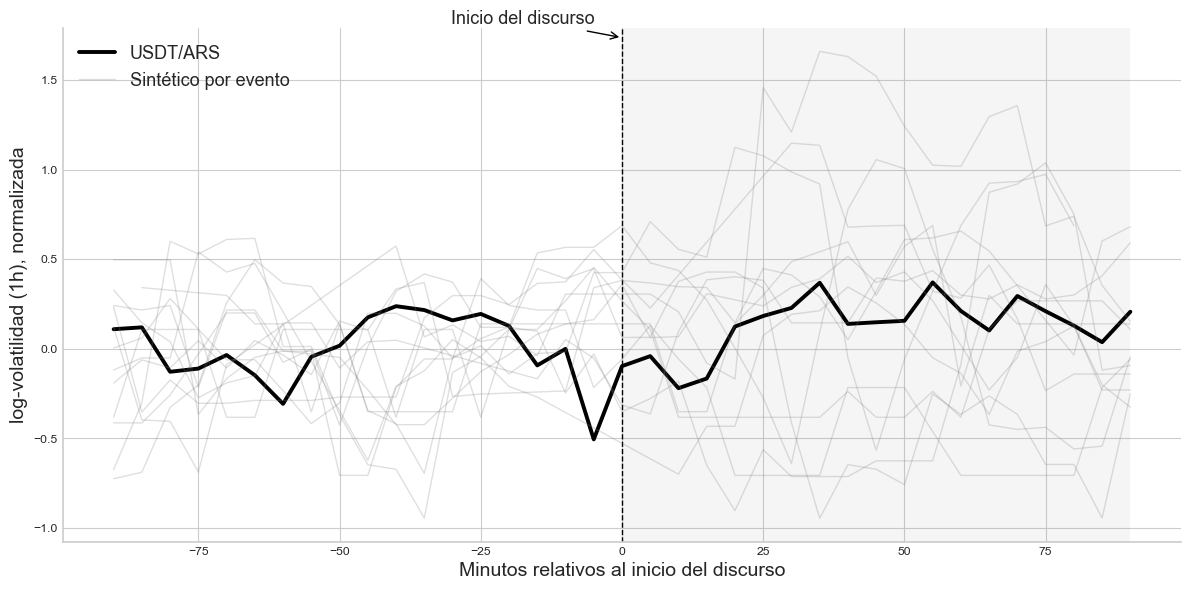

In [ ]:

#  AVERAGE TREATED + ALL SYNTHETIC CURVES — ESTILO FREIRE


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set_context("paper")   # estilo paper
plt.style.use("seaborn-v0_8-whitegrid")


fig, ax = plt.subplots(figsize=(12,6))

# ======= estilo tipo paper =======
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_linewidth(1.2)

# sombreado post-tratamiento
ax.axvspan(0, df_norm["t_min_5"].max(), 
           color="grey", alpha=0.08, linewidth=0)

# línea vertical en el tratamiento
ax.axvline(0, linestyle="--", color="black", lw=1)

# ======= (2) TREATED PROMEDIO =======
ax.plot(
    mean_treated["t_min_5"], mean_treated["treated_norm"],
    color="black",
    lw=2.8,
    label="USDT/ARS"
)

# ======= (1) TODOS LOS SINTÉTICOS =======
for ev in df_norm["event"].unique():
    sub = df_norm[df_norm["event"] == ev].copy()
    sub = sub.drop_duplicates(subset="t_min_5").sort_values("t_min_5")
    
    ax.plot(
        sub["t_min_5"], sub["synthetic_norm"],
        color="gray",
        alpha=0.25,
        lw=1,
        label="Sintético por evento" if ev == df_norm["event"].unique()[0] else ""

    )

ax.set_xlabel("Minutos relativos al inicio del discurso", fontsize=14)
ax.set_ylabel("log-volatilidad (1h), normalizada", fontsize=14)


ax.annotate(
    "Inicio del discurso",
    xy=(0, ax.get_ylim()[1]*0.97),
    xytext=(-20, 10),
    textcoords="offset points",
    ha="right",
    fontsize=13,
    arrowprops=dict(arrowstyle="->", lw=1)
)

# leyenda minimalista
ax.legend(frameon=False, fontsize=13)

plt.tight_layout()
plt.show()



# SDiD

In [ ]:


import numpy as np
import pandas as pd
from numpy.linalg import lstsq

PANEL_PATH = "PANEL_MULTIPAR_USDT_5m.xlsx"

# Tratado
TREATED = "USDTARS"

# Donantes robustos (los que funcionaron bien)
DONORS = [
    "BTCUSDT",
    "ETHUSDT",
    "USDTBRL",
    "USDTTRY"
]

# Excluir este evento si querés
EXCLUDE_EVENTS = ["Caputo_Laje1", "Caputo_Majul4"]

# Ventana de estimación
WINDOW_PRE  = -90
WINDOW_POST =  90


# === cargar panel ===
panel = pd.read_excel(PANEL_PATH, sheet_name="panel_5m", parse_dates=["time_local"])

panel = panel[(panel["t_min"]>=WINDOW_PRE)&(panel["t_min"]<=WINDOW_POST)].copy()

panel["vol1h"] = panel["roll_vol_1h"].astype(float)
panel.loc[panel["vol1h"] <= 0, "vol1h"] = np.nan
panel["log_vol1h"] = np.log(panel["vol1h"])

# quedarnos solo con tratado + donantes
valid_symbols = [TREATED] + DONORS
panel = panel[panel["symbol"].isin(valid_symbols)].copy()

# excluir eventos problemáticos
panel = panel[~panel["event"].isin(EXCLUDE_EVENTS)].copy()

panel = panel.sort_values(["event","symbol","t_min"])


In [ ]:

# BLOQUE 2 — FUNCIÓN DE CONTROL SINTÉTICO ROBUSTA POR EVENTO

def build_synthetic_for_event(df_event, treated_symbol, donor_symbols, metric):

    # pivot (tratado + donantes)
    piv = df_event.pivot_table(index="t_min", columns="symbol", values=metric).sort_index()

    # asegurarse de que el tratado existe
    if treated_symbol not in piv.columns:
        return None, None


    # (A) Imputar SÓLO DONANTES (no el tratado)

    piv2 = piv.copy()

    for s in donor_symbols:
        if s in piv2.columns:
            pre_mean = piv2.loc[piv2.index<0, s].mean()
            piv2[s] = piv2[s].fillna(pre_mean)

    # el tratado NO se imputa → dropna SOLO sobre el tratado
    piv2 = piv2.dropna(subset=[treated_symbol]).copy()


    # (B) PRE / POST
    pre = piv2.loc[piv2.index < 0].copy()
    post = piv2.loc[piv2.index >= 0].copy()

    if len(pre) < 5 or len(post) < 5:
        return None, None


    # (C) Synthetic weights (OLS truncado)

    y_pre = pre[treated_symbol].values
    X_pre = pre[donor_symbols].values

    try:
        w_hat, *_ = lstsq(X_pre, y_pre, rcond=None)
    except:
        return None, None

    w_hat = np.clip(w_hat, 0, None)
    w_hat = w_hat / w_hat.sum()

    X_all = piv2[donor_symbols].values
    treated_all = piv2[treated_symbol].values
    synth_all = X_all @ w_hat

    # resultado del evento
    res = pd.DataFrame({
        "t_min": piv2.index,
        "treated": treated_all,
        "synthetic": synth_all,
    })
    res["gap"] = res["treated"] - res["synthetic"]
    res["event"] = df_event["event"].iloc[0]

    return res, pd.Series(w_hat, index=donor_symbols)


In [ ]:

events = sorted(panel["event"].unique())

results = {}
weights = {}

print("\n=== PROCESANDO EVENTOS ===")
rows = []

for ev in events:
    df_ev = panel[panel["event"] == ev].copy()

    res_ev, w_ev = build_synthetic_for_event(
        df_event=df_ev,
        treated_symbol=TREATED,
        donor_symbols=DONORS,
        metric="log_vol1h"
    )

    if res_ev is None:
        print(f"[SKIP] {ev}")
        continue

    results[ev] = res_ev
    weights[ev] = w_ev

    pre_gap  = res_ev.loc[res_ev["t_min"]<0, "gap"]
    post_gap = res_ev.loc[res_ev["t_min"]>=0, "gap"]

    tau_e = post_gap.mean() - pre_gap.mean()

    rows.append({
        "event": ev,
        "tau_e": tau_e,
        "pre_gap_mean": pre_gap.mean(),
        "post_gap_mean": post_gap.mean(),
        "n_pre": len(pre_gap),
        "n_post": len(post_gap)
    })

# tabla por evento
tbl = pd.DataFrame(rows)
print("\n=== β por evento (SC-DiD tipo DiD sobre el gap) ===")
print(tbl.to_string(index=False))

# === STACKED SC-DiD ===
tau_hat = tbl["tau_e"].mean()

print("\n====================================")
print("    ESTIMACIÓN SC–DiD (STACKED)")

print(f"τ_hat (SC–DiD) = {tau_hat}")
print("Interpretación: cambio promedio en log-vol(1h) post–tratamiento,")
print("neta de la brecha pre (tipo DiD) comparado con su synthetic.")



=== PROCESANDO EVENTOS ===

=== β por evento (SC-DiD tipo DiD sobre el gap) ===
            event     tau_e  pre_gap_mean  post_gap_mean  n_pre  n_post
   Caputo_A2Voces -0.242216      1.713754       1.471539     18      19
Caputo_BCRA_28jun  0.595660     -0.019251       0.576409     18      18
  Caputo_Cereales  0.414297      0.109202       0.523499     18      19
Caputo_Conf_26ene  0.508673      0.291259       0.799932     18      19
 Caputo_Conf_BCRA  0.931704     -0.679565       0.252139     18      19
 Caputo_Feinmann1 -0.185864      0.947697       0.761832     14      19
 Caputo_Feinmann2 -0.145648     -0.389148      -0.534797     18      19
     Caputo_Laje2 -0.212782      0.290213       0.077431     13      19
    Caputo_Majul1 -0.105920      0.278142       0.172222     18      19
    Caputo_Majul2  0.014880     -1.292016      -1.277137     18      19
    Caputo_Majul3 -0.120613      0.149999       0.029386     18      19
Caputo_RadioMitre  0.532862     -0.446832       0.08603

N eventos: 12

     WILD CLUSTER BOOTSTRAP — SC–DiD
 Estimate_tau_hat  Bootstrap_SE  p_value_wild   CI_2.5%  CI_97.5%  N_events  B_replications
          0.16542      0.118301         0.168 -0.225916  0.229379        12            2000


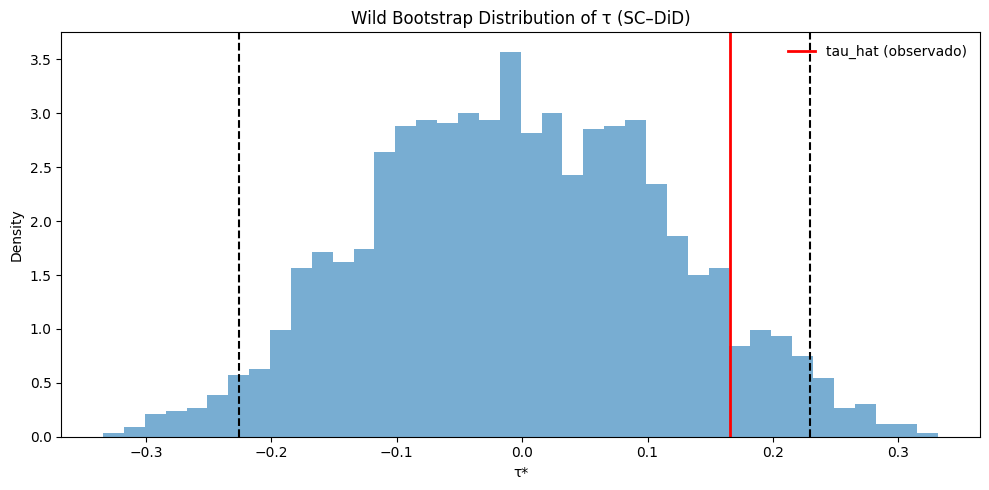

In [ ]:

# WILD CLUSTER BOOTSTRAP FOR SC–DiD 

import numpy as np
import pandas as pd

B = 2000   # número de bootstraps
rng = np.random.default_rng(12345)

boot_taus = []

# τ_e = mean(post) – mean(pre)
orig_taus = tbl["tau_e"].values
E = len(orig_taus)

print(f"N eventos: {E}")


# 2. WILD BOOTSTRAP (Rademacher signs)

for b in range(B):

    # signo aleatorio por evento: +1 o -1
    signs = rng.choice([-1,1], size=E)

    # τ*_e = signo_e * τ_e
    tau_star_e = orig_taus * signs

    # stacked estimator para el bootstrap
    tau_star = tau_star_e.mean()

    boot_taus.append(tau_star)

boot_taus = np.array(boot_taus)


# 3. Estadísticos bootstrap

tau_hat = tbl["tau_e"].mean()

se_boot = boot_taus.std(ddof=1)

# p-value bilateral
pval = ( np.abs(boot_taus) >= np.abs(tau_hat) ).mean()

# intervalos (percentiles)
ci_lower = np.percentile(boot_taus, 2.5)
ci_upper = np.percentile(boot_taus, 97.5)

summary_boot = pd.DataFrame({
    "Estimate_tau_hat": [tau_hat],
    "Bootstrap_SE": [se_boot],
    "p_value_wild": [pval],
    "CI_2.5%": [ci_lower],
    "CI_97.5%": [ci_upper],
    "N_events": [E],
    "B_replications": [B]
})

print("     WILD CLUSTER BOOTSTRAP — SC–DiD")

print(summary_boot.to_string(index=False))


import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(boot_taus, bins=40, alpha=0.6, color="#1f77b4", density=True)
plt.axvline(tau_hat, color="red", lw=2, label="tau_hat (observado)")
plt.axvline(ci_lower, color="black", ls="--")
plt.axvline(ci_upper, color="black", ls="--")
plt.title("Wild Bootstrap Distribution of τ (SC–DiD)")
plt.xlabel("τ*")
plt.ylabel("Density")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


/var/folders/nv/_2c69cnd7kvdvxvytywt_5zm0000gn/T/ipykernel_6963/4044884863.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False, fontsize=14)


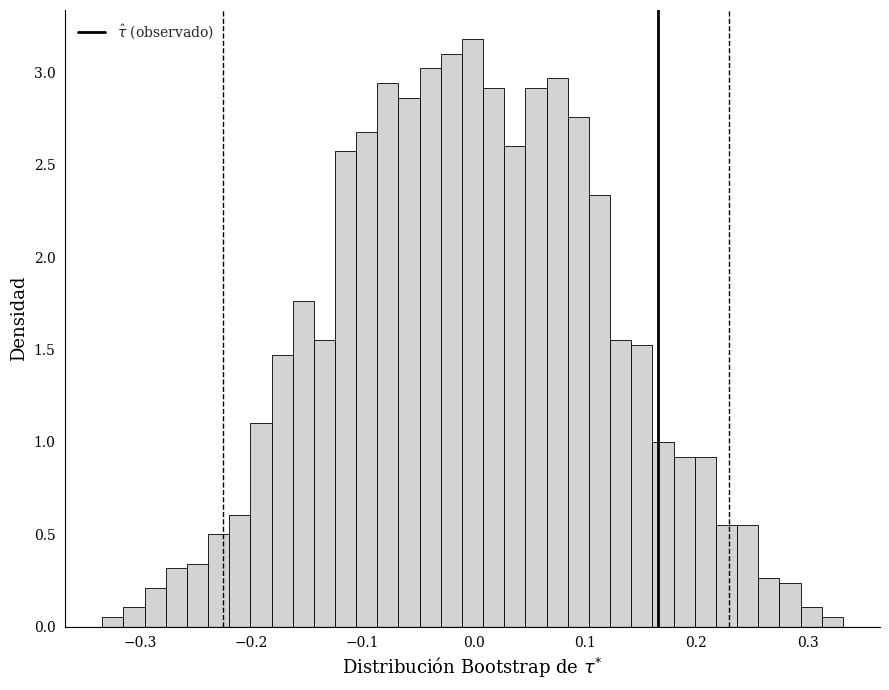

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
plt.rcParams.update({
    "font.family": "serif",
    "axes.edgecolor": "black",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "xtick.color": "black",
    "ytick.color": "black",
    "axes.labelcolor": "black",
    "figure.figsize": (9,7),   # más cuadrado
})

fig, ax = plt.subplots()
ax.legend(frameon=False, fontsize=14)

ax.hist(
    boot_taus, bins=35, density=True,
    color="lightgray", edgecolor="black", linewidth=0.6
)

ax.axvline(tau_hat, color="black", linewidth=2,
           label=r"$\hat{\tau}$ (observado)")

ax.axvline(ci_lower, color="black", linestyle="--", linewidth=1)
ax.axvline(ci_upper, color="black", linestyle="--", linewidth=1)

ax.axhline(0, color="black", linewidth=0.8)

# etiquetas sobrias
ax.set_xlabel(r"Distribución Bootstrap de $\tau^{*}$", fontsize=13)
ax.set_ylabel("Densidad", fontsize=13)


ax.legend(frameon=False)

sns.despine()
plt.tight_layout()
plt.show()


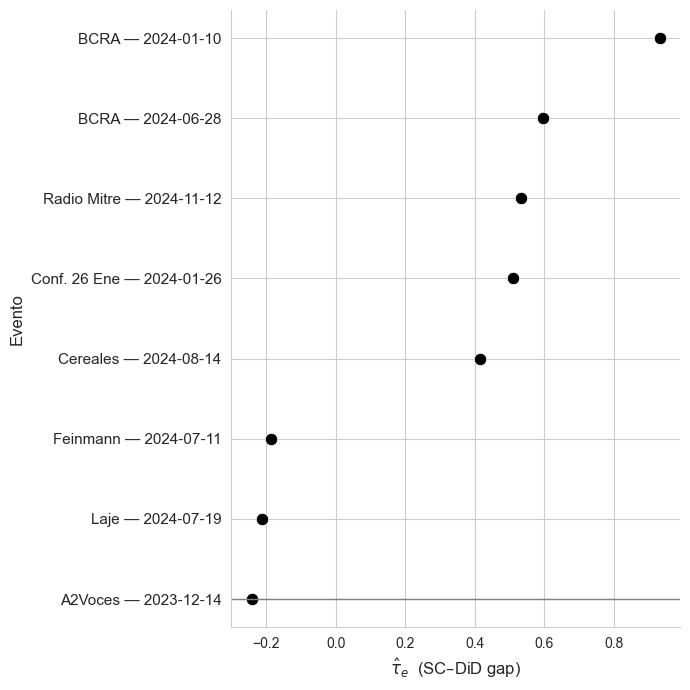

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams.update({
    "font.family": "sans-serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "figure.figsize": (7,7),
})

fig, ax = plt.subplots()

# Línea 0
ax.axhline(0, color="grey", linewidth=1)

# Puntos (negro sobre gris)
ax.scatter(
    tbl8["tau_e"],
    range(len(tbl8)),
    s=80,
    color="black",
    edgecolor="white",
    linewidth=0.6
)

# Etiquetas Y
ax.set_yticks(range(len(tbl8)))
ax.set_yticklabels(tbl8["pretty_name"], fontsize=11)

ax.set_xlabel(r"$\hat{\tau}_e$  (SC–DiD gap)", fontsize=12)
ax.set_ylabel("Evento", fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()


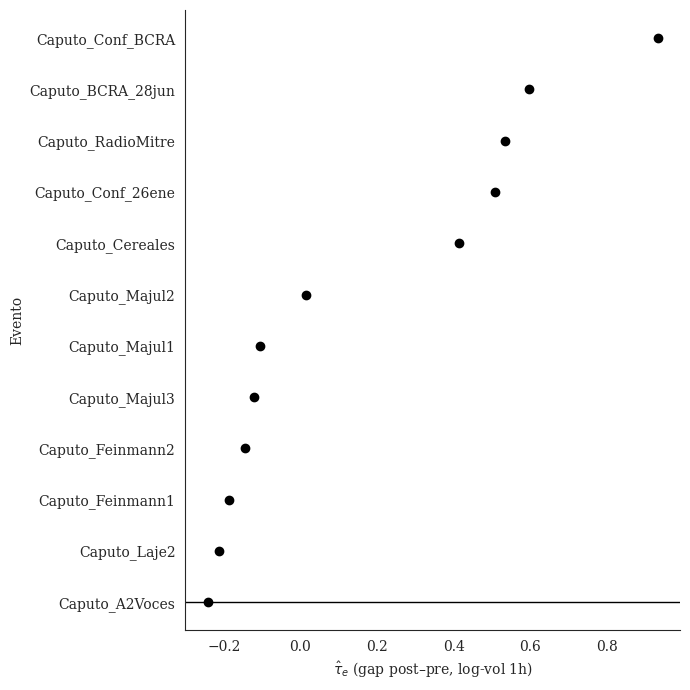

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# tbl: columnas ["event","tau_e", ...]
tbl_sorted = tbl.sort_values("tau_e")

sns.set_style("white")
plt.rcParams.update({
    "font.family": "serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "figure.figsize": (7,7),
})

fig, ax = plt.subplots()

ax.axhline(0, color="black", linewidth=1)

ax.plot(tbl_sorted["tau_e"], range(len(tbl_sorted)), "o", color="black")

ax.set_yticks(range(len(tbl_sorted)))
ax.set_yticklabels(tbl_sorted["event"])
ax.set_xlabel(r"$\hat{\tau}_e$ (gap post–pre, log-vol 1h)")
ax.set_ylabel("Evento")

plt.tight_layout()
plt.show()
